# Optimization

At the neuron level!

Given
i. A dataframe `synapses` of (input) connections to every neuron, with columns `source`, `delay`, and `weight` (to be learned)
ii. A dataframe `spikes` of network activity, with columns `neuron` and `time`
we aim at computing the weights of every synapses of every neurons so that when properly initialized, the network exhibits the desired activity.

We use a `pl.DataFrame` named `states` with the following columns:
- `f_index` (`pl.UInt32`): unique id for the firing event it starts with
- `start` (`pl.Float64`): start time of the state
- `length` (`pl.Float64`): length of the state
- `in_index` (`pl.UInt32`): id of the connections through which the incoming spikes enters the neuron
- `weight` (`pl.Float64`): weight of the connections through which the incoming spikes enters the neuron
- `ic0` and `ic1` (both `pl.Float64`): noncumulative coefficients (to be combined with `weights`)
- `c0` and `c1` (both `pl.Float64`): cumulative state coefficients

# Simulation

At the network level!

We use a `pl.DataFrame` named `states` with the following columns:
- `neuron` (`pl.UInt32`): int, neuron index
- `start` (`pl.Float64`): float, start time of the state
- `end` (`pl.Float64`): float, end time of the state (or `length`?)
- `ic0` and `ic1` (both `pl.Float64`): noncumulative state coefficients
- `c0` and `c1` (both `pl.Float64`): cumulative state coefficients


- `prev_ftime` (`pl.Float64`): float, last firing time of the neuron (could be null if not fired yet)
- `f_time`: float, firing time of the neuron in the interval (null if unset, nan if not applicable)
- `next_ftime`: float, next firing time of the neuron (null if not fired yet)


When simulating the network, we aim at filling the `next_ftime` column based on the current state of the neuron.

When a neuron fires:
1. The states of the firing neuron, previous to the firing event and with null `next_ftime`, are updated with the firing time. A new state at the firing time is added with the reset values for `ic0` and `ic1`.
2. The spike is propagated through the network. New states are created for the receiving neurons, with initial `ic0` and `ic1` values based on the weights and the current state of the firing neuron. 
3. Optionally, sort the states by `start` and fill the `end` column by shifting the `start` column within each neuron group.

## Notes
- We use `null` and `nan` to represent unset values and missing values, respectively. Unset values are used for `next_ftime` when we still need to compute the next firing time, while `nan` is used when the next firing time is not applicable (e.g., for neurons that do not fire).
- For fixed states, we only try to fill the `ftime` column for unset values (containing `null`). Then, based on minimum propagation delays, we accept as many spikes as possible, updating the `next_ftime` column for the firing neurons.
- Use `merge_sorted` to merge new states with existing states.

In [1]:
import numpy as np
from numba import njit, guvectorize, float64, int64, vectorize
import polars as pl
from scipy.special import lambertw
from scipy import sparse
import gurobipy as gp

In [2]:
rng = np.random.default_rng()

In [3]:
def random_states(n_neurons, n_states) -> pl.DataFrame:
    states = pl.DataFrame(
        {
            "neuron": rng.integers(0, n_neurons, size=n_states),
            "start": rng.uniform(0.0, 10.0, size=n_states),
            "w0": rng.normal(size=n_states),
            "w1": rng.normal(size=n_states),
            "f_thresh": rng.normal(1.0, 0.1, size=n_states),
        },
        schema={
            "neuron": pl.UInt32,
            "start": pl.Float64,
            "w0": pl.Float64,
            "w1": pl.Float64,
            "f_thresh": pl.Float64,
        },
    )
    states = states.sort("start")
    states = states.with_columns(
        pl.col("start")
        .diff()
        .shift(-1, fill_value=float("inf"))
        .over("neuron")
        .alias("length"),
        pl.col("w0").alias("c0"),
        pl.col("w1").alias("c1"),
    )
    return states

In [4]:
from rsnn.states import compute_rising_crossing_times
from rsnn.channels import compute_min_delays
from rsnn.rand import rand_synapses

In [5]:
# from rsnn.pl_new.optim.states import create_states
from rsnn.rand import rand_spikes

In [9]:
eps = 0.5
n_neurons = 1

spikes_ref = rand_spikes(n_neurons, 50.0, 1.0)
spikes_ref = spikes_ref.drop("period")
spikes_ref = spikes_ref.sort("time")
print(f"reference spikes: {spikes_ref}")

# spikes = rand_spikes(n_neurons, 10.0, 1.0)
# spikes = spikes.drop("period")
jitters = rng.normal(0, 0.05, size=spikes_ref.height)
spikes = spikes_ref.with_columns(jitter=jitters)
spikes = spikes.with_columns(pl.col("time") + pl.col("jitter")).drop("jitter")
spikes = spikes.sort("time")  # useless
print(f"spikes: {spikes}")


reference spikes: shape: (22, 2)
┌────────┬───────────┐
│ neuron ┆ time      │
│ ---    ┆ ---       │
│ u32    ┆ f64       │
╞════════╪═══════════╡
│ 0      ┆ 2.900284  │
│ 0      ┆ 4.033808  │
│ 0      ┆ 5.898337  │
│ 0      ┆ 6.984027  │
│ 0      ┆ 9.275538  │
│ …      ┆ …         │
│ 0      ┆ 37.879337 │
│ 0      ┆ 40.264202 │
│ 0      ┆ 42.470542 │
│ 0      ┆ 46.977567 │
│ 0      ┆ 49.010598 │
└────────┴───────────┘
spikes: shape: (22, 2)
┌────────┬───────────┐
│ neuron ┆ time      │
│ ---    ┆ ---       │
│ u32    ┆ f64       │
╞════════╪═══════════╡
│ 0      ┆ 2.935436  │
│ 0      ┆ 4.000246  │
│ 0      ┆ 5.849879  │
│ 0      ┆ 7.0204    │
│ 0      ┆ 9.292486  │
│ …      ┆ …         │
│ 0      ┆ 37.932954 │
│ 0      ┆ 40.295464 │
│ 0      ┆ 42.440048 │
│ 0      ┆ 47.041096 │
│ 0      ┆ 49.086087 │
└────────┴───────────┘


In [10]:
n_silent_neurons = n_neurons - spikes.select("neuron").n_unique()
n_silent_neurons

0

In [23]:
eps = 0.5
n_neurons = 1

spikes_ref = pl.DataFrame({"neuron": [0, 0, 0], "time_ref": [1.0, 2.0, 3.0]})
spikes = pl.DataFrame({"neuron": [0, 0], "time": [1.0, 3.0]})

adjustment = spikes.join(spikes_ref, on="neuron").select(
    (pl.col("time_ref") - pl.col("time")).unique().alias("delta_adj")
)

# Precision
n_silent_neurons = n_neurons - spikes.select("neuron").n_unique()
spikes_adj = (
    spikes.join(adjustment, how="cross")
    .with_columns((pl.col("time") + pl.col("delta_adj")).alias("time_adj"))
)
dist_adj = spikes_adj.sort("time_adj").join_asof(
    spikes_ref.sort("time_ref"),
    by="neuron",
    left_on="time_adj",
    right_on="time_ref",
    strategy="nearest",
    tolerance=eps,
    check_sortedness=False,
    coalesce=False,
)
prec_adj = (
    dist_adj.group_by("delta_adj", "neuron")
    .agg(
        (1 - ((pl.col("time_adj") - pl.col("time_ref")).abs() / eps))
        .fill_null(0.0)
        .mean()
        .alias("measure")
    )
    .group_by("delta_adj")
    .agg(pl.col("measure").sum())
)

prec_best = (
    n_silent_neurons + prec_adj.select(pl.col("measure").max()).item()
) / n_neurons
print("best precision:", prec_best)

# Recall
n_silent_neurons_ref = n_neurons - spikes_ref.select("neuron").n_unique()
spikes_ref_adj = spikes_ref.join(adjustment, how="cross").with_columns(
    (pl.col("time_ref") - pl.col("delta_adj")).alias("time_ref_adj")
)
dist_adj = spikes_ref_adj.sort("time_ref_adj").join_asof(
    spikes.sort("time"),
    by="neuron",
    left_on="time_ref_adj",
    right_on="time",
    strategy="nearest",
    tolerance=eps,
    check_sortedness=False,
    coalesce=False,
)
rec_adj = (
    dist_adj.group_by("delta_adj", "neuron")
    .agg(
        (1 - ((pl.col("time_ref_adj") - pl.col("time")).abs() / eps))
        .fill_null(0.0)
        .mean()
        .alias("measure")
    )
    .group_by("delta_adj")
    .agg(pl.col("measure").sum())
)

rec_best = (
    n_silent_neurons_ref + rec_adj.select(pl.col("measure").max()).item()
) / n_neurons
print("best recall:", rec_best)

best precision: 1.0
best recall: 0.6666666666666666


In [ ]:
for f_times_c, r_f_times_c in zip(f_times, ref_f_times):
    if f_times_c.size > 0:
        precision += (
            kernel(r_f_times_c, f_times_c[:, None] + a_times[None, :])
        ).sum(axis=0) / f_times_c.size

    else:
        precision += np.ones_like(a_times)

In [5]:
states = random_states(10, 10, 10)
states,

KeyError: 'input'

In [6]:
n_neurons, n_inputs = 100, 500
rate, period = 1.0, 100.0

# Create random spikes
spikes = rand_spikes(n_neurons, period, rate)

# Create random synapses
synapses = rand_synapses_fin(n_neurons, n_inputs, 1.0, 10.0)

In [7]:
print("spikes:")
print(spikes)

spikes:
shape: (3_653, 2)
┌────────┬───────────┐
│ neuron ┆ time      │
│ ---    ┆ ---       │
│ u32    ┆ f64       │
╞════════╪═══════════╡
│ 0      ┆ 65.666551 │
│ 0      ┆ 67.221621 │
│ 0      ┆ 69.216264 │
│ 0      ┆ 76.197294 │
│ 0      ┆ 77.71129  │
│ …      ┆ …         │
│ 99     ┆ 24.597644 │
│ 99     ┆ 26.317767 │
│ 99     ┆ 31.294987 │
│ 99     ┆ 33.222037 │
│ 99     ┆ 35.472285 │
└────────┴───────────┘


In [8]:
print("synapses:")
print(synapses.sort("target"))

synapses:
shape: (50_000, 6)
┌────────┬────────┬──────────┬─────┬─────┬───────┐
│ source ┆ target ┆ delay    ┆ w0  ┆ w1  ┆ reset │
│ ---    ┆ ---    ┆ ---      ┆ --- ┆ --- ┆ ---   │
│ u32    ┆ u32    ┆ f64      ┆ f64 ┆ f64 ┆ bool  │
╞════════╪════════╪══════════╪═════╪═════╪═══════╡
│ 19     ┆ 0      ┆ 8.980797 ┆ 0.0 ┆ 0.0 ┆ false │
│ 57     ┆ 0      ┆ 2.396842 ┆ 0.0 ┆ 0.0 ┆ false │
│ 20     ┆ 0      ┆ 6.610053 ┆ 0.0 ┆ 0.0 ┆ false │
│ 43     ┆ 0      ┆ 8.00192  ┆ 0.0 ┆ 0.0 ┆ false │
│ 89     ┆ 0      ┆ 7.9854   ┆ 0.0 ┆ 0.0 ┆ false │
│ …      ┆ …      ┆ …        ┆ …   ┆ …   ┆ …     │
│ 62     ┆ 99     ┆ 8.730019 ┆ 0.0 ┆ 0.0 ┆ false │
│ 60     ┆ 99     ┆ 2.182038 ┆ 0.0 ┆ 0.0 ┆ false │
│ 74     ┆ 99     ┆ 1.983507 ┆ 0.0 ┆ 0.0 ┆ false │
│ 72     ┆ 99     ┆ 7.482652 ┆ 0.0 ┆ 0.0 ┆ false │
│ 97     ┆ 99     ┆ 2.092072 ┆ 0.0 ┆ 0.0 ┆ false │
└────────┴────────┴──────────┴─────┴─────┴───────┘


In [ ]:
# import numpy as np
# from numba import float64, guvectorize
# from tqdm import trange

In [10]:
rng = np.random.default_rng()

In [ ]:
# @guvectorize(
#     [(float64[:], float64[:], float64[:], float64[:])],
#     "(n),(n),(n)->(n)",
# )
# def recursively_update_c0(length, ic0, c1, c0):
#     c0[0] = ic0[0]
#     for n in range(1, len(length)):
#         c0[n] = ic0[n] + (c0[n - 1] + c1[n - 1] * length[n - 1]) * np.exp(
#             -length[n - 1]
#         )


# @guvectorize([(float64[:], float64[:], float64[:])], "(n),(n)->(n)")
# def recursively_update_c1(length, ic1, c1):
#     c1[0] = ic1[0]
#     for n in range(1, len(length)):
#         c1[n] = ic1[n] + c1[n - 1] * np.exp(-length[n - 1])


# def compute_coefs(states, inputs):
#     """Update the coefficients in the states based on the inputs coefficients."""
#     # states = (
#     #     states.drop("w0", "w1")
#     #     .join(
#     #         inputs,
#     #         on="in_index",
#     #         how="left",
#     #     )
#     #     .with_columns(
#     #         pl.col("w0").fill_null(0.0),
#     #         pl.col("w1").fill_null(0.0),
#     #         pl.lit(None, pl.Float64).alias("c0"),
#     #         pl.lit(None, pl.Float64).alias("c1"),
#     #     )
#     #     # .select("index", "start", "length", "in_index", "w0", "w1", "active")
#     # )

#     # Recursively update c1 and c0
#     states = states.with_columns(
#         pl.struct(["length", "w1"])
#         .map_batches(
#             lambda batch: recursively_update_c1(
#                 batch.struct.field("length"),
#                 batch.struct.field("w1"),
#             ),
#             return_dtype=pl.Float64,
#         )
#         .over("index")
#         .alias("c1")
#     )
#     states = states.with_columns(
#         pl.struct(["length", "c1", "w0"])
#         .map_batches(
#             lambda batch: recursively_update_c0(
#                 batch.struct.field("length"),
#                 batch.struct.field("c1"),
#                 batch.struct.field("w0"),
#             ),
#             return_dtype=pl.Float64,
#         )
#         .over("index")
#         .alias("c0")
#     )

#     return states

In [13]:
def random_states(n_neurons, n_states) -> pl.DataFrame:
    return pl.DataFrame(
        data={
            "neuron": rng.integers(0, n_neurons, size=n_states),
            "start": rng.random(size=n_states),
            "length": rng.random(size=n_states),
            "c0": rng.normal(size=n_states),
            "c1": rng.normal(size=n_states),
        },
        schema={
            "neuron": pl.Int64,
            "start": pl.Float64,
            "length": pl.Float64,
            "c0": pl.Float64,
            "c1": pl.Float64,
        },
    )

In [ ]:
def get_linear_cstr(times, states, deriv=0):  # returns A and b
    rec_lin_offset = (
        times.with_row_index("index")
        .join(
            states.filter(pl.col("reset")).select("f_index", "start", "ic0", "ic1"),
            on="f_index",
        )
        .filter((pl.col("start") <= pl.col("time")))
        .with_columns(
            (pl.col("time") - pl.col("start")).alias("delta"),
        )
        .group_by("index")
        .agg(
            (
                (
                    pl.col("ic0")
                    - deriv * pl.col("ic1")
                    + pl.col("ic1") * pl.col("delta")
                )
                * (-pl.col("delta")).exp()
            )
            .sum()
            .alias("coef")
        )
    )

    syn_lin_map = (
        times.with_row_index("index")
        .join(
            states.filter(pl.col("in_index").is_not_null()).select(
                "f_index", "in_index", "start"
            ),
            on="f_index",
        )
        .filter((pl.col("start") <= pl.col("time")))
        .with_columns(
            (pl.col("time") - pl.col("start")).alias("delta"),
        )
        .group_by("index", "in_index")
        .agg(
            (
                (pl.col("ic1") * pl.col("delta") - deriv * pl.col("ic1"))
                * (-pl.col("delta")).exp()
            )
            .sum()
            .alias("coef")
        )
    )

    A = sparse.csr_array(
        (
            (
                syn_lin_map.get_column("coef")
                if deriv % 2 == 0
                else -syn_lin_map.get_column("coef")
            ),
            (
                syn_lin_map.get_column("index"),
                syn_lin_map.get_column("in_index"),
            ),
        ),
    )
    b = sparse.csr_array(
        (
            (
                rec_lin_offset.get_column("coef")
                if deriv % 2 == 0
                else -rec_lin_offset.get_column("coef")
            ),
            (
                rec_lin_offset.get_column("index"),
                0,
            ),
        ),
    )

    return A, b

In [ ]:
# def modulo_with_offset(x, period, offset):
#     return x - period * (x - offset).floordiv(period)

In [19]:
# n_neurons, n_inputs = 100, 500
# n_spikes, period = 10, 5.0

# # Create random spikes
# spikes = random_spikes(n_neurons, n_spikes, period)

# # Create random synapses
# synapses = random_synapses(n_neurons, n_inputs)

In [20]:
n_neurons, n_inputs = 100, 100
rate, period = 1.0, 50.0

# Create random spikes
spikes = rand_spikes(n_neurons, period, rate)

# Create random synapses
# synapses = rand_synapses_fin(n_neurons, n_inputs, 0.1, 10.0)
# synapses = rand_synapses_fin_fout(n_neurons, n_inputs, 0.1, 10.0)
synapses = rand_synapses_fc(n_neurons, 0.1, 10.0)

In [21]:
FIRING_THRESHOLD = 1.0
REFRACTORY_RESET = -1.0
FEAS_TOL = 1e-5

eps = 0.2
zmax, dzmin = 0.0, -np.inf
wmin, wmax = -np.inf, np.inf
n_iter = 50

In [22]:
# spikes_part = spikes.partition_by("neuron", include_key=False, as_dict=True)
# synapses_part = synapses.partition_by("target", include_key=False, as_dict=True)

# for (neuron,) in spikes_part.keys():
#     # Setup the intervals in between periodic extension of spikes
#     intervals = (
#         spikes_part[(neuron,)]
#         .sort("time")
#         .with_row_index("f_index")
#         .with_columns(
#             # pl.int_range(pl.len()).alias("index"),
#             time_prev=modulo_with_offset(
#                 pl.col("time").gather((pl.arange(pl.len()) - 1) % pl.len()),
#                 period,
#                 pl.col("time") - period,
#             ),
#         )
#         .select("f_index", "time_prev", "time")
#     )
#     t0 = intervals.get_column("time_prev").first()

#     # Setup the input channels and states
#     refr_channel = pl.DataFrame(
#         data={
#             "in_index": 0,
#             "source": neuron,
#             "delay": 0.0,
#             "weight": REFRACTORY_RESET,
#             "ic0": 1.0,
#             "ic1": 0.0,
#         },
#         schema={
#             "in_index": pl.UInt32,
#             "source": pl.UInt32,
#             "delay": pl.Float64,
#             "weight": pl.Float64,
#             "ic0": pl.Float64,
#             "ic1": pl.Float64,
#         },
#     )
#     syn_channels = (
#         synapses_part[(neuron,)]
#         .with_row_index("in_index", offset=1)
#         .with_columns(
#             pl.lit(0.0, pl.Float64).alias("ic0"), pl.lit(1.0, pl.Float64).alias("ic1")
#         )
#     )
#     in_channels = refr_channel.merge_sorted(syn_channels, key="in_index")

#     # Setup the input states
#     refr_states = (
#         intervals.with_columns(
#             start=pl.col("time_prev"),
#             in_index=pl.lit(0, pl.UInt32),
#             weight=pl.lit(REFRACTORY_RESET, pl.Float64),
#             ic0=pl.lit(1.0, pl.Float64),
#             ic1=pl.lit(0.0, pl.Float64),
#             active=pl.lit(None, pl.Boolean),
#         )
#         .select("f_index", "start", "in_index", "weight", "ic0", "ic1", "active")
#         .sort("start")
#     )
#     syn_states = (
#         syn_channels.join(spikes, left_on="source", right_on="neuron", how="inner")
#         .with_columns(
#             f_index=pl.lit(None, pl.UInt32),
#             start=modulo_with_offset(pl.col("time") + pl.col("delay"), period, t0),
#             active=pl.lit(None, pl.Boolean),
#         )
#         .select("f_index", "start", "in_index", "weight", "ic0", "ic1", "active")
#         .sort("start")
#     )
#     in_states = refr_states.merge_sorted(syn_states, key="start").with_columns(
#         pl.col("f_index").forward_fill(),
#     )

#     # Setup the virtual states, before firings
#     virt_states = (
#         intervals.with_columns(
#             start=(pl.col("time") - eps).clip(lower_bound=pl.col("time_prev")),
#             in_index=pl.lit(None, pl.UInt32),
#             weight=pl.lit(0.0, pl.Float64),
#             ic0=pl.lit(0.0, pl.Float64),
#             ic1=pl.lit(0.0, pl.Float64),
#             active=pl.lit(True, pl.Boolean),
#         )
#         .vstack(
#             intervals.with_columns(
#                 start=pl.col("time"),
#                 in_index=pl.lit(None, pl.UInt32),
#                 weight=pl.lit(0.0, pl.Float64),
#                 ic0=pl.lit(0.0, pl.Float64),
#                 ic1=pl.lit(0.0, pl.Float64),
#                 active=pl.lit(True, pl.Boolean),
#             )
#         )
#         .select("f_index", "start", "in_index", "weight", "ic0", "ic1", "active")
#         .sort("start")
#     )

#     # Combine all states
#     states = in_states.extend(virt_states).sort("f_index", "start")
#     states = states.with_columns(
#         pl.col("active").forward_fill().fill_null(False).over("f_index"),
#         pl.col("start")
#         .diff()
#         .shift(-1, fill_value=0.0)
#         .over("f_index")
#         .alias("length"),
#     )

#     # Setup the Gurobi solver for optimization
#     gb_model = gp.Model("qp_model")
#     gb_model.setParam("OutputFlag", 0)  # Disable output

#     # Setup the variables
#     gb_var = gb_model.addMVar(syn_channels.height, lb=wmin, ub=wmax)

#     # Set objective
#     gb_model.setObjective(gb_var @ gb_var, sense=gp.GRB.MINIMIZE)  # to be adapted

#     # Set constraints at firing times
#     A = get_linear_map_cstr(
#         intervals.select("f_index", "time"), states, in_channels.height
#     )
#     gb_model.addConstr(
#         A[:, 1:] @ gb_var + A[:, 0] * REFRACTORY_RESET == FIRING_THRESHOLD
#     )

#     for i in trange(n_iter):
#         # solve current gb_model
#         gb_model.optimize()

#         if gb_model.status != gp.GRB.OPTIMAL:
#             if gb_model.status == gp.GRB.INFEASIBLE:
#                 print(f"Neuron {neuron}: Infeasible!")
#             elif gb_model.status == gp.GRB.INF_OR_UNBD:
#                 print(f"Neuron {neuron}: Infeasible (or unbounded)!")
#             elif gb_model.status == gp.GRB.UNBOUNDED:
#                 print(f"Neuron {neuron}: Unbounded!")
#             else:
#                 print(f"Neuron {neuron}: Unknown status: {gb_model.status}")
#             break

#         # update states from current optimal weights
#         states = states.update(
#             pl.DataFrame({"weight": gb_var.X}).with_row_index("in_index", offset=1),
#             on="in_index",
#         )
#         states = states.with_columns(
#             pl.struct(["weight", "length", "ic1"])
#             .map_batches(
#                 lambda batch: recursively_update_c1(
#                     batch.struct.field("weight"),
#                     batch.struct.field("length"),
#                     batch.struct.field("ic1"),
#                 ),  # type: ignore
#                 return_dtype=pl.Float64,
#             )
#             .over("f_index")
#             .alias("c1")
#         )
#         states = states.with_columns(
#             pl.struct(["weight", "length", "ic0", "c1"])
#             .map_batches(
#                 lambda batch: recursively_update_c0(
#                     batch.struct.field("weight"),
#                     batch.struct.field("length"),
#                     batch.struct.field("ic0"),
#                     batch.struct.field("c1"),
#                 ),  # type: ignore
#                 return_dtype=pl.Float64,
#             )
#             .over("f_index")
#             .alias("c0")
#         )

#         # compute maximal constraints
#         states_partition = states.partition_by(
#             "active", as_dict=True, include_key=False
#         )

#         # silent area: z <= zmax
#         states_silent = states_partition[(False,)]
#         max_violations_silent = compute_max_violations(
#             states_silent, FEAS_TOL + zmax, k=1, by="f_index"
#         )

#         if max_violations_silent.height > 0:
#             A = get_linear_map_cstr(
#                 max_violations_silent.select("f_index", "time"),
#                 states,
#                 in_channels.height,
#             )
#             gb_model.addConstr(A[:, 1:] @ gb_var + A[:, 0] * REFRACTORY_RESET <= zmax)

#         # active: dz >= dzmin
#         states_active = states_partition[(True,)].with_columns(
#             (pl.col("c0") - pl.col("c1")).alias("c0")
#         )
#         max_violations_active = compute_max_violations(
#             states_active, FEAS_TOL - dzmin, k=1, by="f_index"
#         )

#         if max_violations_active.height > 0:
#             A = get_linear_map_cstr(
#                 max_violations_active.select("f_index", "time"),
#                 states,
#                 in_channels.height,
#                 deriv=1,
#             )
#             gb_model.addConstr(A[:, 1:] @ gb_var + A[:, 0] * REFRACTORY_RESET >= dzmin)

#         if max_violations_active.height == 0 and max_violations_silent.height == 0:
#             print(f"Neuron {neuron}: Optimal (in {i} iterations)")
#             break

SchemaError: column name mismatch: left-hand = 'weight', right-hand = 'w0'

In [ ]:
# spikes_part = spikes.partition_by("neuron", include_key=False, as_dict=True)
# synapses_part = synapses.partition_by("target", include_key=False, as_dict=True)

# for (neuron,) in spikes_part.keys():
#     # Setup the intervals in between periodic extension of spikes
#     intervals = (
#         spikes_part[(neuron,)]
#         .sort("time")
#         .with_row_index("f_index")
#         .with_columns(
#             # pl.int_range(pl.len()).alias("index"),
#             time_prev=modulo_with_offset(
#                 pl.col("time").gather((pl.arange(pl.len()) - 1) % pl.len()),
#                 period,
#                 pl.col("time") - period,
#             ),
#         )
#         .select("f_index", "time_prev", "time")
#     )
#     t0 = intervals.get_column("time_prev").first()

#     # Setup the input channels and states
#     refr_channel = pl.DataFrame(
#         data={
#             "in_index": 0,
#             "source": neuron,
#             "delay": 0.0,
#             "weight": REFRACTORY_RESET,
#             "ic0": 1.0,
#             "ic1": 0.0,
#             "reset":True,
#         },
#         schema={
#             "in_index": pl.UInt32,
#             "source": pl.UInt32,
#             "delay": pl.Float64,
#             "weight": pl.Float64,
#             "ic0": pl.Float64,
#             "ic1": pl.Float64,
#             "reset":pl.Boolean,
#         },
#     )
#     syn_channels = (
#         synapses_part[(neuron,)]
#         .with_row_index("in_index", offset=1)
#         .with_columns(
#             pl.lit(0.0, pl.Float64).alias("ic0"), pl.lit(1.0, pl.Float64).alias("ic1"), pl.lit(False, pl.Boolean).alias("reset")
#         )
#     )
#     in_channels = refr_channel.merge_sorted(syn_channels, key="in_index")

#     # Setup the input states
#     in_states = 

    
#     # refr_states = (
#     #     intervals.with_columns(
#     #         start=pl.col("time_prev"),
#     #         in_index=pl.lit(0, pl.UInt32),
#     #         weight=pl.lit(REFRACTORY_RESET, pl.Float64),
#     #         ic0=pl.lit(1.0, pl.Float64),
#     #         ic1=pl.lit(0.0, pl.Float64),
#     #         active=pl.lit(None, pl.Boolean),
#     #     )
#     #     .select("f_index", "start", "in_index", "weight", "ic0", "ic1", "active")
#     #     .sort("start")
#     # )
#     # syn_states = (
#     #     syn_channels.join(spikes, left_on="source", right_on="neuron", how="inner")
#     #     .with_columns(
#     #         f_index=pl.lit(None, pl.UInt32),
#     #         start=modulo_with_offset(pl.col("time") + pl.col("delay"), period, t0),
#     #         active=pl.lit(None, pl.Boolean),
#     #     )
#     #     .select("f_index", "start", "in_index", "weight", "ic0", "ic1", "active")
#     #     .sort("start")
#     # )
#     # in_states = refr_states.merge_sorted(syn_states, key="start").with_columns(
#     #     pl.col("f_index").forward_fill(),
#     # )

#     # Setup the virtual states, before firings
#     virt_states = (
#         intervals.with_columns(
#             start=(pl.col("time") - eps).clip(lower_bound=pl.col("time_prev")),
#             in_index=pl.lit(None, pl.UInt32),
#             weight=pl.lit(0.0, pl.Float64),
#             ic0=pl.lit(0.0, pl.Float64),
#             ic1=pl.lit(0.0, pl.Float64),
#             active=pl.lit(True, pl.Boolean),
#         )
#         .vstack(
#             intervals.with_columns(
#                 start=pl.col("time"),
#                 in_index=pl.lit(None, pl.UInt32),
#                 weight=pl.lit(0.0, pl.Float64),
#                 ic0=pl.lit(0.0, pl.Float64),
#                 ic1=pl.lit(0.0, pl.Float64),
#                 active=pl.lit(True, pl.Boolean),
#             )
#         )
#         .select("f_index", "start", "in_index", "weight", "ic0", "ic1", "active")
#         .sort("start")
#     )

#     # Combine all states
#     states = in_states.extend(virt_states).sort("f_index", "start")
#     states = states.with_columns(
#         pl.col("active").forward_fill().fill_null(False).over("f_index"),
#         pl.col("start")
#         .diff()
#         .shift(-1, fill_value=0.0)
#         .over("f_index")
#         .alias("length"),
#     )

#     # Setup the Gurobi solver for optimization
#     gb_model = gp.Model("qp_model")
#     gb_model.setParam("OutputFlag", 0)  # Disable output

#     # Setup the variables
#     gb_var = gb_model.addMVar(syn_channels.height, lb=wmin, ub=wmax)

#     # Set objective
#     gb_model.setObjective(gb_var @ gb_var, sense=gp.GRB.MINIMIZE)  # to be adapted

#     # Set constraints at firing times
#     A = get_linear_map_cstr(
#         intervals.select("f_index", "time"), states, in_channels.height
#     )
#     gb_model.addConstr(
#         A[:, 1:] @ gb_var + A[:, 0] * REFRACTORY_RESET == FIRING_THRESHOLD
#     )

#     for i in trange(n_iter):
#         # solve current gb_model
#         gb_model.optimize()

#         if gb_model.status != gp.GRB.OPTIMAL:
#             if gb_model.status == gp.GRB.INFEASIBLE:
#                 print(f"Neuron {neuron}: Infeasible!")
#             elif gb_model.status == gp.GRB.INF_OR_UNBD:
#                 print(f"Neuron {neuron}: Infeasible (or unbounded)!")
#             elif gb_model.status == gp.GRB.UNBOUNDED:
#                 print(f"Neuron {neuron}: Unbounded!")
#             else:
#                 print(f"Neuron {neuron}: Unknown status: {gb_model.status}")
#             break

#         # update states from current optimal weights
#         states = states.update(
#             pl.DataFrame({"weight": gb_var.X}).with_row_index("in_index", offset=1),
#             on="in_index",
#         )
#         states = states.with_columns(
#             pl.struct(["weight", "length", "ic1"])
#             .map_batches(
#                 lambda batch: recursively_update_c1(
#                     batch.struct.field("weight"),
#                     batch.struct.field("length"),
#                     batch.struct.field("ic1"),
#                 ),  # type: ignore
#                 return_dtype=pl.Float64,
#             )
#             .over("f_index")
#             .alias("c1")
#         )
#         states = states.with_columns(
#             pl.struct(["weight", "length", "ic0", "c1"])
#             .map_batches(
#                 lambda batch: recursively_update_c0(
#                     batch.struct.field("weight"),
#                     batch.struct.field("length"),
#                     batch.struct.field("ic0"),
#                     batch.struct.field("c1"),
#                 ),  # type: ignore
#                 return_dtype=pl.Float64,
#             )
#             .over("f_index")
#             .alias("c0")
#         )

#         # compute maximal constraints
#         states_partition = states.partition_by(
#             "active", as_dict=True, include_key=False
#         )

#         # silent area: z <= zmax
#         states_silent = states_partition[(False,)]
#         max_violations_silent = compute_max_violations(
#             states_silent, FEAS_TOL + zmax, k=1, by="f_index"
#         )

#         if max_violations_silent.height > 0:
#             A = get_linear_map_cstr(
#                 max_violations_silent.select("f_index", "time"),
#                 states,
#                 in_channels.height,
#             )
#             gb_model.addConstr(A[:, 1:] @ gb_var + A[:, 0] * REFRACTORY_RESET <= zmax)

#         # active: dz >= dzmin
#         states_active = states_partition[(True,)].with_columns(
#             (pl.col("c0") - pl.col("c1")).alias("c0")
#         )
#         max_violations_active = compute_max_violations(
#             states_active, FEAS_TOL - dzmin, k=1, by="f_index"
#         )

#         if max_violations_active.height > 0:
#             A = get_linear_map_cstr(
#                 max_violations_active.select("f_index", "time"),
#                 states,
#                 in_channels.height,
#                 deriv=1,
#             )
#             gb_model.addConstr(A[:, 1:] @ gb_var + A[:, 0] * REFRACTORY_RESET >= dzmin)

#         if max_violations_active.height == 0 and max_violations_silent.height == 0:
#             print(f"Neuron {neuron}: Optimal (in {i} iterations)")
#             break

# Network Simulation

In [23]:
import polars as pl

In [24]:
def random_states(n_neurons, n_states) -> pl.DataFrame:
    return pl.DataFrame(
        data={
            "neuron": rng.integers(0, n_neurons, size=n_states),
            "f_thresh": rng.normal(size=n_states),
            "start": rng.uniform(0.0, 10.0, size=n_states),
            "length": None,  # to be computed
            "ic0": rng.normal(size=n_states),
            "ic1": rng.normal(size=n_states),
            "c0": None,
            "c1": None,
            "tbd": True,
            "f_time": None,  # to be computed
        },
        schema={
            "neuron": pl.Int64,
            "f_thresh": pl.Float64,
            "start": pl.Float64,
            "length": pl.Float64,
            "ic0": pl.Float64,
            "ic1": pl.Float64,
            "c0": pl.Float64,
            "c1": pl.Float64,
            "tbd": pl.Boolean,
            "f_time": pl.Float64,
        },
    )

## Recursive update of all coefficients and lengths

In [25]:
@guvectorize([(float64[:], float64[:], float64[:], float64[:])], "(n),(n),(n)->(n)")
def update_c0(length, ic0, c1, c0):
    c0[0] = ic0[0]
    for n in range(1, len(length)):
        c0[n] = ic0[n] + (c0[n - 1] + c1[n - 1] * length[n - 1]) * np.exp(
            -length[n - 1]
        )


@guvectorize([(float64[:], float64[:], float64[:])], "(n),(n)->(n)")
def update_c1(length, ic1, c1):
    c1[0] = ic1[0]
    for n in range(1, len(length)):
        c1[n] = ic1[n] + c1[n - 1] * np.exp(-length[n - 1])

In [ ]:
# def update_length(states, over=None, fill_value=None):
#     states = states.with_columns(
#         pl.col("start")
#         .diff()
#         .shift(-1, fill_value=fill_value)
#         .over(over)
#         .alias("length"),
#     )
#     return states


# def update_c(states, over=None):
#     states = states.with_columns(
#         pl.struct(["length", "ic1"])
#         .map_batches(
#             lambda batch: update_c1(
#                 batch.struct.field("length"),
#                 batch.struct.field("ic1"),
#             ),  # type: ignore
#             return_dtype=pl.Float64,
#         )
#         .over(over)
#         .alias("c1")
#     )
#     states = states.with_columns(
#         pl.struct(["length", "ic0", "c1"])
#         .map_batches(
#             lambda batch: update_c0(
#                 batch.struct.field("length"),
#                 batch.struct.field("ic0"),
#                 batch.struct.field("c1"),
#             ),  # type: ignore
#             return_dtype=pl.Float64,
#         )
#         .over(over)
#         .alias("c0")
#     )
#     return states

In [27]:
states = random_states(100, 10000)
states = states.sort("start")
print("states is sorted:", states["start"].flags["SORTED_ASC"])

new_states = random_states(100, 10000)
new_states = new_states.sort("start")
print("new_states is sorted:", new_states["start"].flags["SORTED_ASC"])

states = states.merge_sorted(new_states, key="start")
states = states.set_sorted("start")
print("states is sorted:", states["start"].flags["SORTED_ASC"])

states is sorted: True
new_states is sorted: True
states is sorted: True


In [28]:
states = random_states(100, 10000)
states = update_length(states, over="neuron", fill_value=float("inf"))
states = update_c(states, over="neuron")
states, states["start"].flags["SORTED_ASC"]

(shape: (10_000, 10)
 ┌────────┬───────────┬──────────┬──────────┬───┬───────────┬───────────┬──────┬────────┐
 │ neuron ┆ f_thresh  ┆ start    ┆ length   ┆ … ┆ c0        ┆ c1        ┆ tbd  ┆ f_time │
 │ ---    ┆ ---       ┆ ---      ┆ ---      ┆   ┆ ---       ┆ ---       ┆ ---  ┆ ---    │
 │ i64    ┆ f64       ┆ f64      ┆ f64      ┆   ┆ f64       ┆ f64       ┆ bool ┆ f64    │
 ╞════════╪═══════════╪══════════╪══════════╪═══╪═══════════╪═══════════╪══════╪════════╡
 │ 58     ┆ 0.91766   ┆ 0.002384 ┆ 0.253947 ┆ … ┆ -0.259598 ┆ -0.71346  ┆ true ┆ null   │
 │ 62     ┆ -1.937473 ┆ 0.00316  ┆ 0.18836  ┆ … ┆ -0.38418  ┆ 1.366784  ┆ true ┆ null   │
 │ 20     ┆ 0.309797  ┆ 0.003399 ┆ 0.114773 ┆ … ┆ -0.503783 ┆ -0.525637 ┆ true ┆ null   │
 │ 71     ┆ 0.001891  ┆ 0.003676 ┆ 0.210476 ┆ … ┆ 0.120366  ┆ 0.788482  ┆ true ┆ null   │
 │ 99     ┆ -0.470359 ┆ 0.003688 ┆ 0.024561 ┆ … ┆ 0.767074  ┆ 1.189823  ┆ true ┆ null   │
 │ …      ┆ …         ┆ …        ┆ …        ┆ … ┆ …         ┆ …         ┆ …    

## Add new states to states with a to-be-determined column

In [29]:
def merge_states(states, new_states, over=None):
    states = states.with_columns(pl.lit(None, pl.Boolean).alias("tbd")).sort(
        "start"
    )
    new_states = new_states.with_columns(
        pl.lit(True, pl.Boolean).alias("tbd")
    ).sort("start")
    states = states.merge_sorted(new_states, key="start").set_sorted("start")
    states = states.with_columns(
        pl.col("tbd").forward_fill().fill_null(False).over(over)
    )
    return states

In [30]:
states = random_states(100, 100000)
states = update_length(states, over="neuron", fill_value=float("inf"))
states = update_c(states, over="neuron")

new_states = random_states(100, 1000)
states = merge_states(states, new_states, over="neuron")
states = update_length(states, over="neuron", fill_value=float("inf"))
states = update_c(states, over="neuron")

states, states["start"].flags["SORTED_ASC"]

(shape: (101_000, 10)
 ┌────────┬───────────┬──────────┬──────────┬───┬────────────┬────────────┬───────┬────────┐
 │ neuron ┆ f_thresh  ┆ start    ┆ length   ┆ … ┆ c0         ┆ c1         ┆ tbd   ┆ f_time │
 │ ---    ┆ ---       ┆ ---      ┆ ---      ┆   ┆ ---        ┆ ---        ┆ ---   ┆ ---    │
 │ i64    ┆ f64       ┆ f64      ┆ f64      ┆   ┆ f64        ┆ f64        ┆ bool  ┆ f64    │
 ╞════════╪═══════════╪══════════╪══════════╪═══╪════════════╪════════════╪═══════╪════════╡
 │ 17     ┆ -1.559771 ┆ 0.000159 ┆ 0.000388 ┆ … ┆ 0.916548   ┆ 0.293207   ┆ false ┆ null   │
 │ 2      ┆ -1.62256  ┆ 0.000198 ┆ 0.014689 ┆ … ┆ 1.014602   ┆ 0.59679    ┆ false ┆ null   │
 │ 17     ┆ 0.323618  ┆ 0.000547 ┆ 0.001058 ┆ … ┆ 0.769348   ┆ 1.779483   ┆ false ┆ null   │
 │ 61     ┆ -0.90324  ┆ 0.000552 ┆ 0.000918 ┆ … ┆ 0.12381    ┆ -0.864905  ┆ false ┆ null   │
 │ 67     ┆ 0.40099   ┆ 0.000664 ┆ 0.000492 ┆ … ┆ 0.927975   ┆ 1.521285   ┆ false ┆ null   │
 │ …      ┆ …         ┆ …        ┆ …        ┆ … 

## Determine the crossing time, if any, for each state

In [31]:
from scipy.special import lambertw

In [ ]:
# def update_f_thresh(states):
#     """Update firing threshold based on the last spike time for each neuron. Warning: states must be sorted by start"""
#     states = states.with_columns(pl.col("threshold").forward_fill().over("neuron"))
#     return states


def update_f_times(states):
    states = states.with_row_index("index")
    
    new_states = states.filter(pl.col("tbd"))
    f_times = compute_rising_crossing_times(
        new_states.get_column("f_thresh").to_numpy(),
        new_states.get_column("start").to_numpy(),
        new_states.get_column("length").to_numpy(),
        new_states.get_column("c0").to_numpy(),
        new_states.get_column("c1").to_numpy(),
    )
    new_states = new_states.with_columns(f_time=f_times, tbd=False)

    return states.update(new_states, on="index").drop("index")

def compute_rising_crossing_times(f_thresh, start, length, c0, c1):
    dt = np.where(
        c0 < f_thresh,
        np.where(
            c1 > 0.0,
            -(lambertw(-f_thresh / c1 * np.exp(-c0 / c1), 0)) - c0 / c1,
            np.where(
                c1 < 0.0,
                -(lambertw(-f_thresh / c1 * np.exp(-c0 / c1), -1)) - c0 / c1,
                np.log(c0 / f_thresh),
            ),
        ),
        0.0,
    )
    dt[(dt < 0.0) | (dt >= length) | np.iscomplex(dt)] = np.nan
    return start + dt.real

In [33]:
states = random_states(3, 100)

states = update_length(states, over="neuron", fill_value=float("inf"))
states = update_c(states, over="neuron")

states = states.with_row_index("index")
new_states = update_f_times(states.filter(pl.col("tbd")))
states = states.update(new_states, on="index")
states,

/var/folders/p1/wl8__y5x6jgfhz_d47k5gq9m0000gn/T/ipykernel_39686/3986314688.py:26: RuntimeWarning: invalid value encountered in log
  np.log(c0 / f_thresh),


(shape: (100, 11)
 ┌───────┬────────┬───────────┬──────────┬───┬───────────┬───────────┬───────┬──────────┐
 │ index ┆ neuron ┆ f_thresh  ┆ start    ┆ … ┆ c0        ┆ c1        ┆ tbd   ┆ f_time   │
 │ ---   ┆ ---    ┆ ---       ┆ ---      ┆   ┆ ---       ┆ ---       ┆ ---   ┆ ---      │
 │ u32   ┆ i64    ┆ f64       ┆ f64      ┆   ┆ f64       ┆ f64       ┆ bool  ┆ f64      │
 ╞═══════╪════════╪═══════════╪══════════╪═══╪═══════════╪═══════════╪═══════╪══════════╡
 │ 0     ┆ 1      ┆ 0.124033  ┆ 0.123014 ┆ … ┆ 0.886526  ┆ -1.328774 ┆ false ┆ 0.123014 │
 │ 1     ┆ 2      ┆ 0.983898  ┆ 0.220264 ┆ … ┆ -0.195961 ┆ 1.24589   ┆ false ┆ NaN      │
 │ 2     ┆ 1      ┆ 1.138308  ┆ 0.221457 ┆ … ┆ 0.592581  ┆ -3.280831 ┆ false ┆ NaN      │
 │ 3     ┆ 1      ┆ -1.375434 ┆ 0.229591 ┆ … ┆ 0.70036   ┆ -2.624631 ┆ false ┆ 0.229591 │
 │ 4     ┆ 0      ┆ -0.105545 ┆ 0.236356 ┆ … ┆ -3.274573 ┆ -0.844252 ┆ false ┆ NaN      │
 │ …     ┆ …      ┆ …         ┆ …        ┆ … ┆ …         ┆ …         ┆ …     ┆ …  

In [34]:
new_states = random_states(3, 10)

states = merge_states(states.drop("index"), new_states, over="neuron")
states = update_length(states, over="neuron", fill_value=float("inf"))
states = update_c(states, over="neuron")

states = states.with_row_index("index")
new_states = update_f_times(states.filter(pl.col("tbd")))
states = states.update(new_states, on="index")
states.select("f_thresh", "start", "length", "c0", "c1", "f_time"),

/var/folders/p1/wl8__y5x6jgfhz_d47k5gq9m0000gn/T/ipykernel_39686/3986314688.py:26: RuntimeWarning: invalid value encountered in log
  np.log(c0 / f_thresh),


(shape: (110, 6)
 ┌───────────┬──────────┬──────────┬───────────┬───────────┬──────────┐
 │ f_thresh  ┆ start    ┆ length   ┆ c0        ┆ c1        ┆ f_time   │
 │ ---       ┆ ---      ┆ ---      ┆ ---       ┆ ---       ┆ ---      │
 │ f64       ┆ f64      ┆ f64      ┆ f64       ┆ f64       ┆ f64      │
 ╞═══════════╪══════════╪══════════╪═══════════╪═══════════╪══════════╡
 │ 0.124033  ┆ 0.123014 ┆ 0.098443 ┆ 0.886526  ┆ -1.328774 ┆ 0.123014 │
 │ 0.983898  ┆ 0.220264 ┆ 0.165862 ┆ -0.195961 ┆ 1.24589   ┆ NaN      │
 │ 1.138308  ┆ 0.221457 ┆ 0.008133 ┆ 0.592581  ┆ -3.280831 ┆ NaN      │
 │ -1.375434 ┆ 0.229591 ┆ 0.254149 ┆ 0.70036   ┆ -2.624631 ┆ 0.229591 │
 │ -0.105545 ┆ 0.236356 ┆ 0.090768 ┆ -3.274573 ┆ -0.844252 ┆ NaN      │
 │ …         ┆ …        ┆ …        ┆ …         ┆ …         ┆ …        │
 │ -0.494054 ┆ 9.520137 ┆ 0.130394 ┆ -6.886547 ┆ -3.606251 ┆ NaN      │
 │ -0.581945 ┆ 9.650531 ┆ 0.075485 ┆ -5.983498 ┆ -2.029246 ┆ NaN      │
 │ 2.11024   ┆ 9.726016 ┆ inf      ┆ -5.140936 

## Accept as many spikes as possible, based on Floyd-Warshall algorithm

In [35]:
from scipy.sparse.csgraph import floyd_warshall
from scipy.sparse import csr_array


def compute_min_delays(synapses, n_neurons):
    """Compute the fastest synapses between nodes in a directed graph."""

    # Initialize fast synapses by grouping and aggregating the minimum delay
    fast_synapses = synapses.group_by(["source", "target"]).agg(
        pl.min("delay").alias("delay")
    )

    # Convert to a sparse matrix for Floyd-Warshall algorithm
    row_ind = fast_synapses.get_column("source").to_numpy()
    col_ind = fast_synapses.get_column("target").to_numpy()
    data = fast_synapses.get_column("delay").to_numpy()
    graph = csr_array((data, (row_ind, col_ind)), shape=(n_neurons, n_neurons))
    graph = floyd_warshall(graph, directed=True, overwrite=True)

    # Convert back to DataFrame
    fast_synapses = pl.DataFrame(
        {
            "source": np.repeat(np.arange(n_neurons), n_neurons),
            "target": np.tile(np.arange(n_neurons), n_neurons),
            "delay": graph.flatten(),
        }
    )
    fast_synapses = fast_synapses.filter(pl.col("delay").is_finite())

    return fast_synapses


def filter_spikes(spikes, min_delays):
    max_times = (
        min_delays.join(spikes, left_on="source", right_on="neuron", how="inner")
        .with_columns(
            (pl.col("time") + pl.col("delay")).alias("max_time"),
        )
        .group_by("target")
        .agg(pl.min("max_time"))
    )

    # spikes = spikes.join(
    #     max_times, left_on="neuron", right_on="target", how="left"
    # ).remove(pl.col("time") > pl.col("max_time"))
    spikes = spikes.join_where(
        max_times,
        pl.col("neuron") == pl.col("target"),
        pl.col("time") <= pl.col("max_time"),
    )

    return spikes

In [36]:
n_neurons = 5
synapses = pl.DataFrame(
    {
        "source": [0, 0, 1, 1, 2, 2, 3, 3, 4, 4],
        "target": [1, 3, 2, 4, 0, 3, 2, 4, 0, 3],
        "delay": [4.0, 5.0, 1.0, 6.0, 2.0, 3.0, 1.0, 2.0, 1.0, 4.0],
    }
)
min_delays = compute_min_delays(synapses, n_neurons)
min_delays.filter(pl.col("target") == 4), 

(shape: (5, 3)
 ┌────────┬────────┬───────┐
 │ source ┆ target ┆ delay │
 │ ---    ┆ ---    ┆ ---   │
 │ i64    ┆ i64    ┆ f64   │
 ╞════════╪════════╪═══════╡
 │ 0      ┆ 4      ┆ 7.0   │
 │ 1      ┆ 4      ┆ 6.0   │
 │ 2      ┆ 4      ┆ 5.0   │
 │ 3      ┆ 4      ┆ 2.0   │
 │ 4      ┆ 4      ┆ 0.0   │
 └────────┴────────┴───────┘,)

In [37]:
new_spikes = pl.DataFrame(
    {
        "neuron": [0, 1, 2, 4],
        "time": [1.0, 2.0, 3.0, 12.0],
    }
)
new_spikes, 

(shape: (4, 2)
 ┌────────┬──────┐
 │ neuron ┆ time │
 │ ---    ┆ ---  │
 │ i64    ┆ f64  │
 ╞════════╪══════╡
 │ 0      ┆ 1.0  │
 │ 1      ┆ 2.0  │
 │ 2      ┆ 3.0  │
 │ 4      ┆ 12.0 │
 └────────┴──────┘,)

In [38]:
max_times = min_delays.join(
    new_spikes, left_on="source", right_on="neuron", how="inner"
).with_columns(
    (pl.col("time") + pl.col("delay")).alias("max_time"),
).group_by(
    "target"
).agg(
    pl.min("max_time")
)
max_times, 

(shape: (5, 2)
 ┌────────┬──────────┐
 │ target ┆ max_time │
 │ ---    ┆ ---      │
 │ i64    ┆ f64      │
 ╞════════╪══════════╡
 │ 4      ┆ 8.0      │
 │ 0      ┆ 1.0      │
 │ 2      ┆ 3.0      │
 │ 1      ┆ 2.0      │
 │ 3      ┆ 6.0      │
 └────────┴──────────┘,)

In [39]:
accepted_new_spikes = new_spikes.join_where(
    max_times,
    pl.col("neuron") == pl.col("target"),
    pl.col("time") <= pl.col("max_time"),
)
accepted_new_spikes,

(shape: (3, 4)
 ┌────────┬──────┬────────┬──────────┐
 │ neuron ┆ time ┆ target ┆ max_time │
 │ ---    ┆ ---  ┆ ---    ┆ ---      │
 │ i64    ┆ f64  ┆ i64    ┆ f64      │
 ╞════════╪══════╪════════╪══════════╡
 │ 0      ┆ 1.0  ┆ 0      ┆ 1.0      │
 │ 2      ┆ 3.0  ┆ 2      ┆ 3.0      │
 │ 1      ┆ 2.0  ┆ 1      ┆ 2.0      │
 └────────┴──────┴────────┴──────────┘,)

In [40]:
# accepted_new_spikes = new_spikes.join(
#     max_times, left_on="neuron", right_on="target", how="left"
# ).remove(pl.col("time") > pl.col("max_time"))
# accepted_new_spikes,

In [ ]:
n_neurons, n_inputs = 1000, 1000
rate, period = 0.1, 5.0

# Create random spikes
new_spikes = rand_spikes(n_neurons, period, rate)

# Create random synapses
synapses = rand_synapses_fc(n_neurons, 0.1, 10.0)
min_delays = compute_min_delays(synapses, n_neurons)

# Filter spikes based on minimum propagation delays between neurons
new_spikes = filter_spikes(new_spikes, min_delays)

## Propagate new spikes through communication channels

In [12]:
def propagate_spikes(spikes, channels):
    return (
        channels.join(spikes, left_on="source", right_on="neuron", how="inner")
        .with_columns(
            (pl.col("time") + pl.col("delay")).alias("start"),
        )
        .drop("source", "delay", "time")
        .rename({"target": "neuron"})
    )

In [91]:
synapses = rand_synapses_fc(3, 0.1, 10.0)
synapses = synapses.with_columns(
    pl.col("source").cum_count().over("target").alias("in_index")
)

In [ ]:
# def create_recovery_channels(neurons, weight=-1.0):
#     return pl.DataFrame(
#         {
#             "source": neurons,
#             "target": neurons,
#             "delay": 0.0,
#             "weight": weight,
#             "reset": True,
#         },
#         schema=CHANNEL_SCHEMA,
#     )

In [86]:
n_neurons = 3
rate, period = 0.5, 10.0

spikes = rand_spikes(n_neurons, period, rate)
origins = spikes.group_by("neuron").agg((pl.max("time") - period).alias("time_origin"))
print(spikes, origins)

shape: (6, 2)
┌────────┬──────────┐
│ neuron ┆ time     │
│ ---    ┆ ---      │
│ u32    ┆ f64      │
╞════════╪══════════╡
│ 0      ┆ 2.908405 │
│ 0      ┆ 8.879291 │
│ 1      ┆ 2.809679 │
│ 1      ┆ 0.050284 │
│ 2      ┆ 5.558038 │
│ 2      ┆ 9.536206 │
└────────┴──────────┘ shape: (3, 2)
┌────────┬─────────────┐
│ neuron ┆ time_origin │
│ ---    ┆ ---         │
│ u32    ┆ f64         │
╞════════╪═════════════╡
│ 0      ┆ -1.120709   │
│ 2      ┆ -0.463794   │
│ 1      ┆ -7.190321   │
└────────┴─────────────┘


In [87]:
# synapses = rand_synapses_fc(n_neurons, 0.1, 10.0)
# synapses = synapses.with_columns(
#     pl.col("source").cum_count().over("target").alias("in_index"),
#     pl.lit(0, pl.Float64).alias("ic0"),
#     pl.lit(1, pl.Float64).alias("ic1"),
# )
# refractory = create_recovery_channels(spikes.get_column("neuron").unique())
# refractory = refractory.with_columns(
#     pl.lit(0, pl.UInt32).alias("in_index"),
#     pl.lit(1, pl.Float64).alias("ic0"),
#     pl.lit(0, pl.Float64).alias("ic1"),
# )
# channels = synapses.vstack(refractory)
# print(channels)

ValueError: the given column-schema names do not match the data dictionary

In [69]:
# in_states = propagate_spikes(spikes, channels)
# in_states = in_states.drop("source", "delay", "time")
# in_states = origins.join(in_states, left_on="neuron", right_on="target")
# in_states = in_states.with_columns(
#     start=modulo_with_offset(pl.col("in_time"), period, pl.col("time_origin")),
#     active=pl.lit(None, pl.Boolean),
# )
# in_states = in_states.select("neuron", "start", "in_index", "weight", "ic0", "ic1", "active", "reset")
# in_states, 

NameError: name 'channels' is not defined

## Fires the spikes, applying threshold noise

In [ ]:
def simulate(spikes, synapses, tmin, tmax):
    ...

# OLD STUFF BELOW...

In [ ]:
synaptic_states = (
    synapses.join(origins, left_on="target", right_on="neuron", how="inner")
    .join(spikes, left_on="source", right_on="neuron", how="inner", suffix="_source")
    .with_columns(
        pl.col("target").alias("neuron"),
        pl.lit(None, pl.Int64).alias("index"),
        (
            pl.col("time")
            + pl.col("delay")
            - period
            * (pl.col("time") + pl.col("delay") - pl.col("ref_time")).floordiv(period)
        ).alias("start"),
        pl.lit(0.0, pl.Float64).alias("w0"),
        pl.lit(0.0, pl.Float64).alias("w1"),
    )
)
synaptic_states.select("neuron", "start").sort("neuron", "start"),

(shape: (50, 2)
 ┌────────┬───────────┐
 │ neuron ┆ start     │
 │ ---    ┆ ---       │
 │ i64    ┆ f64       │
 ╞════════╪═══════════╡
 │ 0      ┆ -1.148552 │
 │ 0      ┆ -0.854032 │
 │ 0      ┆ -0.775337 │
 │ 0      ┆ -0.228352 │
 │ 0      ┆ 1.253374  │
 │ …      ┆ …         │
 │ 2      ┆ 6.952272  │
 │ 2      ┆ 8.137953  │
 │ 2      ┆ 8.519045  │
 │ 2      ┆ 9.151154  │
 │ 2      ┆ 9.583466  │
 └────────┴───────────┘,)

In [ ]:
def modulo_with_offset(value, period, offset):
    return value - period * (value - offset).floordiv(period)

In [ ]:
eps = 0.2

last_firings = spikes.group_by("neuron").agg(
    pl.col("time").max().alias("last_firing_time"),
)

firing_states = (
    spikes.sort("time")
    .with_columns(
        (
            pl.int_range(pl.len()).over("neuron").alias("firing_index"),
            pl.col("time").alias("start"),
            pl.lit(None, pl.Int64).alias("syn_index"),
            pl.lit(0.0, pl.Float64).alias("w0"),
            pl.lit(0.0, pl.Float64).alias("w1"),
        )
    )
    .select("neuron", "firing_index", "start", "syn_index", "w0", "w1")
)
firing_states = firing_states.join(last_firings, on="neuron", suffix="_last")
firing_states = firing_states.select(
    "neuron",
    "firing_index",
    "start",
    "syn_index",
    "w0",
    "w1",
    "last_firing_time",
)

active_states = firing_states.with_columns(
    (pl.col("start") - eps).alias("start"),
    pl.lit(None, pl.Int64).alias("firing_index"),
    pl.lit(None, pl.Int64).alias("syn_index"),
    pl.lit(0.0, pl.Float64).alias("w0"),
    pl.lit(0.0, pl.Float64).alias("w1"),
)

In [ ]:
refractory_states = firing_states.with_columns(
    modulo_with_offset(
        pl.col("start"), pl.col("period"), pl.col("last_firing_time") - pl.col("period")
    ).alias("start"),
    pl.lit(None, pl.Int64).alias("firing_index"),
    pl.lit(None, pl.Int64).alias("syn_index"),
    pl.lit(-1.0, pl.Float64).alias("w0"),
    pl.lit(0.0, pl.Float64).alias("w1"),
)
refractory_states = refractory_states.select(
    "neuron", "firing_index", "start", "syn_index", "w0", "w1", "last_firing_time", "period"
)
refractory_states,

(shape: (10, 8)
 ┌────────┬──────────────┬───────────┬───────────┬──────┬─────┬──────────────────┬────────┐
 │ neuron ┆ firing_index ┆ start     ┆ syn_index ┆ ic0  ┆ ic1 ┆ last_firing_time ┆ period │
 │ ---    ┆ ---          ┆ ---       ┆ ---       ┆ ---  ┆ --- ┆ ---              ┆ ---    │
 │ i64    ┆ i64          ┆ f64       ┆ i64       ┆ f64  ┆ f64 ┆ f64              ┆ f64    │
 ╞════════╪══════════════╪═══════════╪═══════════╪══════╪═════╪══════════════════╪════════╡
 │ 0      ┆ null         ┆ 0.456594  ┆ null      ┆ -1.0 ┆ 0.0 ┆ 8.641418         ┆ 10.0   │
 │ 1      ┆ null         ┆ 1.572984  ┆ null      ┆ -1.0 ┆ 0.0 ┆ 4.31923          ┆ 10.0   │
 │ 1      ┆ null         ┆ 2.00645   ┆ null      ┆ -1.0 ┆ 0.0 ┆ 4.31923          ┆ 10.0   │
 │ 2      ┆ null         ┆ 2.465313  ┆ null      ┆ -1.0 ┆ 0.0 ┆ 9.481347         ┆ 10.0   │
 │ 1      ┆ null         ┆ 4.068527  ┆ null      ┆ -1.0 ┆ 0.0 ┆ 4.31923          ┆ 10.0   │
 │ 1      ┆ null         ┆ -5.68077  ┆ null      ┆ -1.0 ┆ 0.0 ┆ 

In [ ]:
synaptic_states = (
    synapses.join(last_firings, left_on="target", right_on="neuron", how="inner")
    .join(
        spikes,
        left_on="source",
        right_on="neuron",
        how="inner",
    )
    .with_columns(
        pl.col("target").alias("neuron"),
        pl.lit(None, pl.Int64).alias("firing_index"),
        modulo_with_offset(
            pl.col("time") + pl.col("delay"),
            pl.col("period"),
            pl.col("last_firing_time") - pl.col("period"),
        ).alias("start"),
        pl.lit(0.0, pl.Float64).alias("w0"),
        pl.lit(0.0, pl.Float64).alias("w1"),
    )
)
synaptic_states = synaptic_states.select(
    "neuron", "firing_index", "start", "syn_index", "w0", "w1", "last_firing_time", "period"
)
synaptic_states,

(shape: (53, 8)
 ┌────────┬──────────────┬──────────┬───────────┬─────┬─────┬──────────────────┬────────┐
 │ neuron ┆ firing_index ┆ start    ┆ syn_index ┆ ic0 ┆ ic1 ┆ last_firing_time ┆ period │
 │ ---    ┆ ---          ┆ ---      ┆ ---       ┆ --- ┆ --- ┆ ---              ┆ ---    │
 │ i64    ┆ i64          ┆ f64      ┆ i64       ┆ f64 ┆ f64 ┆ f64              ┆ f64    │
 ╞════════╪══════════════╪══════════╪═══════════╪═════╪═════╪══════════════════╪════════╡
 │ 0      ┆ null         ┆ 2.691607 ┆ 0         ┆ 0.0 ┆ 0.0 ┆ 8.641418         ┆ 10.0   │
 │ 0      ┆ null         ┆ 5.004388 ┆ 0         ┆ 0.0 ┆ 0.0 ┆ 8.641418         ┆ 10.0   │
 │ 0      ┆ null         ┆ 2.258142 ┆ 0         ┆ 0.0 ┆ 0.0 ┆ 8.641418         ┆ 10.0   │
 │ 0      ┆ null         ┆ 4.753685 ┆ 0         ┆ 0.0 ┆ 0.0 ┆ 8.641418         ┆ 10.0   │
 │ 0      ┆ null         ┆ 6.832374 ┆ 1         ┆ 0.0 ┆ 0.0 ┆ 8.641418         ┆ 10.0   │
 │ …      ┆ …            ┆ …        ┆ …         ┆ …   ┆ …   ┆ …                ┆ …  

In [ ]:
states = firing_states.vstack(refractory_states).vstack(synaptic_states).sort("start", maintain_order=True)
states = states.with_columns(
    pl.col("firing_index").backward_fill().over("neuron").alias("firing_index"),
    pl.col("start")
        .diff()
        .shift(-1)
        .fill_null(0.0)
        .over("neuron")
        .alias("length")
)
first_firing_times = states.group_by("neuron", "firing_index").agg(
    pl.col("start").min().alias("first_firing_time"))
states = states.join(first_firing_times, on=["neuron", "firing_index"], how="left").with_columns(
    (pl.col("start") - pl.col("first_firing_time")).alias("start")
).select(
    "neuron", "firing_index", "start", "length", "syn_index", "w0", "w1"
)

with pl.Config(tbl_rows=50, tbl_cols=10):
    print("\nSpikes:")
    print(spikes)

    print("\nSynapses:")
    print(synapses)

    print("\nStates:")
    print(states.filter(pl.col("neuron") == 0))


Spikes:
shape: (10, 3)
┌────────┬──────────┬────────┐
│ neuron ┆ time     ┆ period │
│ ---    ┆ ---      ┆ ---    │
│ i64    ┆ f64      ┆ f64    │
╞════════╪══════════╪════════╡
│ 0      ┆ 6.605356 ┆ 10.0   │
│ 2      ┆ 6.051372 ┆ 10.0   │
│ 2      ┆ 9.481347 ┆ 10.0   │
│ 1      ┆ 2.00645  ┆ 10.0   │
│ 1      ┆ 4.31923  ┆ 10.0   │
│ 2      ┆ 2.465313 ┆ 10.0   │
│ 1      ┆ 1.572984 ┆ 10.0   │
│ 1      ┆ 4.068527 ┆ 10.0   │
│ 0      ┆ 0.456594 ┆ 10.0   │
│ 0      ┆ 8.641418 ┆ 10.0   │
└────────┴──────────┴────────┘

Synapses:
shape: (15, 5)
┌────────┬───────────┬────────┬──────────┬────────┐
│ target ┆ syn_index ┆ source ┆ delay    ┆ weight │
│ ---    ┆ ---       ┆ ---    ┆ ---      ┆ ---    │
│ i64    ┆ i64       ┆ i64    ┆ f64      ┆ f64    │
╞════════╪═══════════╪════════╪══════════╪════════╡
│ 0      ┆ 0         ┆ 1      ┆ 0.685158 ┆ 0.0    │
│ 0      ┆ 1         ┆ 2      ┆ 0.781001 ┆ 0.0    │
│ 0      ┆ 2         ┆ 2      ┆ 0.915437 ┆ 0.0    │
│ 0      ┆ 3         ┆ 0      ┆ 0.7983

In [ ]:
first_firing_times = states.group_by("neuron", "firing_index").agg(
    pl.col("start").min().alias("first_firing_time"))
states = states.join(first_firing_times, on=["neuron", "firing_index"], how="left")
states = states.with_columns(
    (pl.col("start") - pl.col("first_firing_time")).alias("start")
)
states,

(shape: (73, 10)
 ┌────────┬──────────────┬───────────┬──────────┬───┬─────┬────────────────┬────────┬───────────────┐
 │ neuron ┆ firing_index ┆ start     ┆ length   ┆ … ┆ ic1 ┆ last_firing_ti ┆ period ┆ first_firing_ │
 │ ---    ┆ ---          ┆ ---       ┆ ---      ┆   ┆ --- ┆ me             ┆ ---    ┆ time          │
 │ i64    ┆ i64          ┆ f64       ┆ f64      ┆   ┆ f64 ┆ ---            ┆ f64    ┆ ---           │
 │        ┆              ┆           ┆          ┆   ┆     ┆ f64            ┆        ┆ f64           │
 ╞════════╪══════════════╪═══════════╪══════════╪═══╪═════╪════════════════╪════════╪═══════════════╡
 │ 1      ┆ 0            ┆ -5.68077  ┆ 0.161123 ┆ … ┆ 0.0 ┆ 4.31923        ┆ 10.0   ┆ -5.68077      │
 │ 1      ┆ 0            ┆ -5.519647 ┆ 0.048127 ┆ … ┆ 0.0 ┆ 4.31923        ┆ 10.0   ┆ -5.68077      │
 │ 1      ┆ 0            ┆ -5.47152  ┆ 0.250702 ┆ … ┆ 0.0 ┆ 4.31923        ┆ 10.0   ┆ -5.68077      │
 │ 1      ┆ 0            ┆ -5.220818 ┆ 1.826767 ┆ … ┆ 0.0 ┆ 4.319

In [ ]:
eps, f_thresh, zmax, dzmin = 0.1, 1.0, 0.0, 2.0
spikes, synapses, states = create_states(spikes, synapses, period, eps, f_thresh, zmax, dzmin)

with pl.Config(tbl_rows=10):
    print("\nSpikes:")
    print(spikes)

    print("\nSynapses:")
    print(synapses)

    print("\nStates:")
    print(states.sort("neuron", "start"))


Spikes:
shape: (50, 4)
┌────────┬───────────┬────────┬───────────┐
│ neuron ┆ time      ┆ period ┆ origin    │
│ ---    ┆ ---       ┆ ---    ┆ ---       │
│ i64    ┆ f64       ┆ f64    ┆ f64       │
╞════════╪═══════════╪════════╪═══════════╡
│ 33     ┆ 89.77492  ┆ 10.0   ┆ 89.77492  │
│ 42     ┆ 19.468401 ┆ 10.0   ┆ 19.468401 │
│ 11     ┆ 98.195099 ┆ 10.0   ┆ 98.195099 │
│ 55     ┆ 93.321271 ┆ 10.0   ┆ 93.321271 │
│ 66     ┆ 11.05113  ┆ 10.0   ┆ 11.05113  │
│ …      ┆ …         ┆ …      ┆ …         │
│ 50     ┆ 63.287717 ┆ 10.0   ┆ 63.287717 │
│ 71     ┆ 22.448902 ┆ 10.0   ┆ 22.448902 │
│ 73     ┆ 90.39845  ┆ 10.0   ┆ 90.39845  │
│ 44     ┆ 63.018392 ┆ 10.0   ┆ 40.111477 │
│ 65     ┆ 66.8927   ┆ 10.0   ┆ 66.8927   │
└────────┴───────────┴────────┴───────────┘

Synapses:
shape: (4_000, 5)
┌────────┬───────────┬────────┬──────────┬────────┐
│ target ┆ syn_index ┆ source ┆ delay    ┆ weight │
│ ---    ┆ ---       ┆ ---    ┆ ---      ┆ ---    │
│ i64    ┆ i64       ┆ i64    ┆ f64      ┆ 

In [ ]:
for neuron, neuron_states in states.group_by("neuron"):
    # Process each neuron's states
    print(neuron, neuron_states.get_column("syn_index").max())

(15,) 99
(30,) 98
(48,) 96
(6,) 97
(42,) 99
(33,) 97
(36,) 99
(9,) 98
(57,) 98
(93,) 98
(96,) 99
(66,) 98
(63,) 92
(7,) 97
(99,) 95
(22,) 96
(52,) 98
(34,) 94
(31,) 98
(55,) 99
(25,) 99
(94,) 99
(79,) 99
(73,) 95
(88,) 97
(85,) 95
(67,) 98
(91,) 99
(17,) 98
(11,) 99
(50,) 99
(38,) 97
(44,) 99
(65,) 95
(41,) 99
(71,) 98
(47,) 95
(83,) 99
(95,) 99
(89,) 99


In [ ]:
states.filter(pl.col("neuron") == 4).get_column("syn_index")

Int64

In [ ]:
REFRACTORY_RESET = -1.0
n_neurons, n_inputs = 4, 3
n_spikes, period = 3, 10.0

# Create random spikes
spikes = random_spikes(n_neurons, n_spikes, period)

origins = spikes.group_by("neuron").agg(pl.col("time").first().alias("origin"))
with pl.Config(tbl_rows=100):
    print("\nOrigins:")
    print(origins.sort("neuron", "origin"))

spikes = spikes.join(origins, on="neuron")
# .with_columns(
# (pl.col("time") - pl.col("origin")).alias("c_time") # more efficient
# ((pl.col("time") - pl.col("origin")) % period).alias("c_time")
# )
# # spikes = spikes.with_columns(
# #     pl.col("time").first().over("neuron").alias("origin"),
# # )
# spikes = spikes.with_columns(
#     (pl.col("time") - pl.col("origin")).alias("c_time"),
# )
with pl.Config(tbl_rows=100):
    print("\nSpikes:")
    print(spikes.sort("neuron", "time"))

synapses = random_synapses(n_neurons, n_inputs)
# we only need the synapses that are connected to the neurons that fired
synapses = synapses.join(origins, left_on="target", right_on="neuron")
# set synapse index for each target neuron
synapses = synapses.with_columns(
    (pl.int_range(pl.len()).over("target").alias("synapse_index"))
)
with pl.Config(tbl_rows=100):
    print("\nSynapses:")
    print(synapses.sort("target", "synapse_index"))

# # ######

refractory_states = (
    spikes.with_columns(
        pl.int_range(pl.len()).over("neuron").alias("spike_index"),
        (pl.col("time") - pl.col("origin")).mod(period).alias("start"),
        pl.lit(None, pl.Int64).alias("synapse_index"),
        pl.lit(REFRACTORY_RESET, pl.Float64).alias("w0"),
        pl.lit(0.0, pl.Float64).alias("w1"),
    )
    .sort("start")
    .select("neuron", "spike_index", "start", "synapse_index", "w0", "w1")
)
with pl.Config(tbl_rows=100):
    print("\nRefractory States:")
    print(refractory_states)

synaptic_states = (
    (
        spikes.join(
            synapses,
            left_on="neuron",
            right_on="source",
            how="inner",
        ).with_columns(
            pl.col("target").alias("neuron"),
            pl.lit(None, pl.Int64).alias("spike_index"),
            (pl.col("time") - pl.col("origin_right") + pl.col("delay"))
            .mod(period)
            .alias("start"),
            # pl.lit(None, pl.Float64).alias("length"),
            pl.lit(0.0, pl.Float64).alias("w0"),
            pl.lit(None, pl.Float64).alias("w1"),
        )
    )
    .sort("start")
    .select("neuron", "spike_index", "start", "synapse_index", "w0", "w1")
)
with pl.Config(tbl_rows=100, tbl_cols=20):
    print("\nSynaptic States:")
    print(synaptic_states)

states = refractory_states.merge_sorted(synaptic_states, key="start")
states = states.with_columns(
    pl.col("spike_index").forward_fill().over("neuron").alias("spike_index"),
    pl.col("start")
    .diff()
    .shift(-1)
    .fill_null(period - pl.col("start"))
    .over("neuron")
    .alias("length"),
)
with pl.Config(tbl_rows=100):
    print("\nStates:")
    print(states.sort("neuron", "start"))


# # states = refr_states.vstack(syn_states)
# # states = origins.join(states, on="neuron", how="left")
# # states = states.with_columns(
# #     ((pl.col("start") - pl.col("origin")).mod(pl.col("period"))).alias("start")
# # ).sort("neuron", "start")
# # states = states.with_columns(
# #     pl.col("start")
# #     .diff()
# #     .shift(-1)
# #     .fill_null(period - pl.col("start"))
# #     .over("neuron")
# #     .alias("length"),
# # )
# # with pl.Config(tbl_rows=100, tbl_cols=10):
# #     print("\nStates:")
# #     print(states)

# # # Update coefficients for new weights
# # with pl.Config(tbl_rows=100):
# #     print("\nSynapses:")
# #     print(synapses.sort("target", "source"))

# # states = states.join(
# #     synapses.select("target", "index", "weight"),
# #     left_on=["neuron", "syn_index"],
# #     right_on=["target", "index"],
# #     how="left",
# # )
# # states = states.with_columns(pl.col("weight").fill_null(pl.col("w1")).alias("w1"))
# # with pl.Config(tbl_rows=100, tbl_cols=10):
# #     print("\nUpdated States:")
# #     print(states)

# # # propagate ic0 and ic1 over "neuron" and "int_index"


Origins:
shape: (2, 2)
┌────────┬──────────┐
│ neuron ┆ origin   │
│ ---    ┆ ---      │
│ i64    ┆ f64      │
╞════════╪══════════╡
│ 1      ┆ 5.209391 │
│ 2      ┆ 9.625733 │
└────────┴──────────┘

Spikes:
shape: (3, 4)
┌────────┬──────────┬────────┬──────────┐
│ neuron ┆ time     ┆ period ┆ origin   │
│ ---    ┆ ---      ┆ ---    ┆ ---      │
│ i64    ┆ f64      ┆ f64    ┆ f64      │
╞════════╪══════════╪════════╪══════════╡
│ 1      ┆ 5.209391 ┆ 10.0   ┆ 5.209391 │
│ 2      ┆ 4.58135  ┆ 10.0   ┆ 9.625733 │
│ 2      ┆ 9.625733 ┆ 10.0   ┆ 9.625733 │
└────────┴──────────┴────────┴──────────┘

Synapses:
shape: (6, 6)
┌────────┬────────┬──────────┬───────────┬──────────┬───────────────┐
│ source ┆ target ┆ delay    ┆ weight    ┆ origin   ┆ synapse_index │
│ ---    ┆ ---    ┆ ---      ┆ ---       ┆ ---      ┆ ---           │
│ i64    ┆ i64    ┆ f64      ┆ f64       ┆ f64      ┆ i64           │
╞════════╪════════╪══════════╪═══════════╪══════════╪═══════════════╡
│ 0      ┆ 1      ┆ 0.52

In [ ]:
# n_neurons, n_inputs = 3, 3
# n_spikes, period = 5, 10.0

# synapses = random_synapses(n_neurons, n_inputs)
# synapses = synapses.with_columns((pl.int_range(pl.len()).over("target").alias("index")))
# with pl.Config(tbl_rows=100):
#     print("\nSynapses:")
#     print(synapses.sort("target", "source"))

# # Create random spikes
# # spikes = random_spikes(n_neurons, n_spikes, period)
# # spikes = spikes.sort("time")
# with pl.Config(tbl_rows=100):
#     print("\nSpikes:")
#     print(spikes.sort("neuron", "time"))

# # Extract the intervals from the spikes
# start_intervals = spikes.with_columns(
#     # ((pl.int_range(pl.len()) + 1) % pl.len()).over("neuron").alias("int_index"),
#     (pl.int_range(pl.len())).over("neuron").alias("int_index"),
#     # pl.col("time").alias("start"),
# )
# with pl.Config(tbl_rows=100):
#     print("\nStart Intervals:")
#     print(start_intervals.sort("neuron", "time"))

# end_intervals = spikes.with_columns(
#     # (pl.int_range(pl.len())).over("neuron").alias("int_index"),  # modulo not needed here
#     ((pl.int_range(pl.len()) - 1) % pl.len()).over("neuron").alias("int_index"),
#     # pl.col("time").alias("end"),
# )
# with pl.Config(tbl_rows=100):
#     print("\nEnd Intervals:")
#     print(end_intervals.sort("neuron", "time"))

# intervals = end_intervals.join(
#     start_intervals, on=["neuron", "int_index"], how="inner", suffix="_start"
# ).sort("neuron", "int_index")

# intervals = intervals.with_columns(
#     (
#         pl.col("time_start")
#         - pl.col("period")
#         * (pl.col("time_start") - (pl.col("time") - pl.col("period"))).floordiv(
#             pl.col("period")
#         )
#     ).alias("int_start"),
#     pl.col("time").alias("int_end"),
# )
# intervals = intervals.drop("time", "time_start", "period_start")
# with pl.Config(tbl_rows=100):
#     print("\nIntervals:")
#     print(intervals.sort("neuron", "int_start"))

# origins = intervals.group_by("neuron").agg(
#     pl.col("int_start").min().alias("origin"),
#     pl.col("period").first().alias("period"),
# )  # origin is the minimum start time for each neuron
# with pl.Config(tbl_rows=100):
#     print("\nOrigins:")
#     print(origins)

# ######

# refr_states = spikes.with_columns(
#     pl.int_range(pl.len()).over("neuron").alias("int_index"),
#     pl.col("time").alias("start"),
#     pl.lit(None, pl.Int64).alias("syn_index"),
#     pl.lit(0.0, pl.Float64).alias("w0"),
#     pl.lit(REFRACTORY_RESET, pl.Float64).alias("w1"),
# ).select("neuron", "int_index", "start", "syn_index", "w0", "w1")
# with pl.Config(tbl_rows=100):
#     print("\nRefractory States:")
#     print(refr_states.sort("neuron", "start"))

# syn_states = (
#     spikes.join(
#         synapses,
#         left_on="neuron",
#         right_on="source",
#         how="inner",
#     ).with_columns(
#         pl.col("target").alias("neuron"),
#         pl.lit(None, pl.Int64).alias("int_index"),
#         (pl.col("time") + pl.col("delay")).alias("start"),
#         # pl.lit(None, pl.Float64).alias("length"),
#         pl.col("index").alias("syn_index"),
#         pl.lit(0.0, pl.Float64).alias("w0"),
#         pl.lit(None, pl.Float64).alias("w1"),
#     )
#     # .sort("start")
# ).select("neuron", "int_index", "start", "syn_index", "w0", "w1")
# with pl.Config(tbl_rows=100):
#     print("\nSynaptic States:")
#     print(syn_states.sort("neuron", "start"))

# states = refr_states.vstack(syn_states)
# states = origins.join(states, on="neuron", how="left")
# states = states.with_columns(
#     ((pl.col("start") - pl.col("origin")).mod(pl.col("period"))).alias("start")
# ).sort("neuron", "start")
# states = states.with_columns(
#     pl.col("int_index").forward_fill().over("neuron").alias("int_index")
# )
# states = states.with_columns(
#     pl.col("start")
#     .diff()
#     .shift(-1)
#     .fill_null(period - pl.col("start"))
#     .over("neuron")
#     .alias("length"),
# )
# with pl.Config(tbl_rows=100, tbl_cols=10):
#     print("\nStates:")
#     print(states)

# # Update coefficients for new weights

# with pl.Config(tbl_rows=100):
#     print("\nSynapses:")
#     print(synapses.sort("target", "source"))

# states = states.join(
#     synapses.select("target", "index", "weight"),
#     left_on=["neuron", "syn_index"],
#     right_on=["target", "index"],
#     how="left",
# )
# states = states.with_columns(pl.col("weight").fill_null(pl.col("w1")).alias("w1"))
# with pl.Config(tbl_rows=100, tbl_cols=10):
#     print("\nUpdated States:")
#     print(states)

# # propagate ic0 and ic1 over "neuron" and "int_index"

NameError: name 'random_synapses' is not defined

In [ ]:
REFRACTORY_RESET = -1.0
n_neurons, n_inputs = 3, 3
n_spikes, period = 5, 10.0

# Create random spikes
spikes = random_spikes(n_neurons, n_spikes, period)
# spikes = spikes.sort("time")
origins = spikes.unique("neuron")
with pl.Config(tbl_rows=100):
    print("\nOrigins:")
    print(origins.sort("time"))

spikes = spikes.join(origins, on="neuron", suffix="_origin")
# spikes = spikes.with_columns(
#     pl.col("time").first().over("neuron").alias("origin"),
# )
spikes = spikes.with_columns(
    (pl.col("time") - pl.col("origin")).alias("c_time"),
)
with pl.Config(tbl_rows=100):
    print("\nSpikes:")
    print(spikes.sort("time"))

synapses = random_synapses(n_neurons, n_inputs)
# synapses = spikes.group_by("neuron").agg(pl.col("neuron")
synapses = synapses.with_columns((pl.int_range(pl.len()).over("target").alias("index")))
with pl.Config(tbl_rows=100):
    print("\nSynapses:")
    print(synapses.sort("target", "source"))

# ######

refractory_states = (
    spikes.with_columns(
        pl.int_range(pl.len()).over("neuron").alias("spike_index"),
        (pl.col("c_time") % period).alias("start"),
        pl.lit(None, pl.Int64).alias("synapse_index"),
        pl.lit(0.0, pl.Float64).alias("w0"),
        pl.lit(REFRACTORY_RESET, pl.Float64).alias("w1"),
    )
    .sort("start")
    .select("neuron", "spike_index", "start", "synapse_index", "w0", "w1")
)
with pl.Config(tbl_rows=100):
    print("\nRefractory States:")
    print(refractory_states)

synaptic_states = (
    (
        spikes.join(
            synapses,
            left_on="neuron",
            right_on="source",
            how="inner",
        ).with_columns(
            pl.col("target").alias("neuron"),
            pl.lit(None, pl.Int64).alias("spike_index"),
            ((pl.col("c_time") + pl.col("delay")) % period).alias("start"),
            # pl.lit(None, pl.Float64).alias("length"),
            pl.col("index").alias("synapse_index"),
            pl.lit(0.0, pl.Float64).alias("w0"),
            pl.lit(None, pl.Float64).alias("w1"),
        )
        # .sort("start")
    )
    .sort("start")
    .select("neuron", "spike_index", "start", "synapse_index", "w0", "w1")
)
with pl.Config(tbl_rows=100):
    print("\nSynaptic States:")
    print(synaptic_states)

states = refractory_states.merge_sorted(synaptic_states, key="start")
with pl.Config(tbl_rows=100):
    print("\nStates:")
    print(states)
# states = refr_states.vstack(syn_states)
# states = origins.join(states, on="neuron", how="left")
# states = states.with_columns(
#     ((pl.col("start") - pl.col("origin")).mod(pl.col("period"))).alias("start")
# ).sort("neuron", "start")
# states = states.with_columns(
#     pl.col("int_index").forward_fill().over("neuron").alias("int_index")
# )
# states = states.with_columns(
#     pl.col("start")
#     .diff()
#     .shift(-1)
#     .fill_null(period - pl.col("start"))
#     .over("neuron")
#     .alias("length"),
# )
# with pl.Config(tbl_rows=100, tbl_cols=10):
#     print("\nStates:")
#     print(states)

# # Update coefficients for new weights

# with pl.Config(tbl_rows=100):
#     print("\nSynapses:")
#     print(synapses.sort("target", "source"))

# states = states.join(
#     synapses.select("target", "index", "weight"),
#     left_on=["neuron", "syn_index"],
#     right_on=["target", "index"],
#     how="left",
# )
# states = states.with_columns(pl.col("weight").fill_null(pl.col("w1")).alias("w1"))
# with pl.Config(tbl_rows=100, tbl_cols=10):
#     print("\nUpdated States:")
#     print(states)

# # propagate ic0 and ic1 over "neuron" and "int_index"

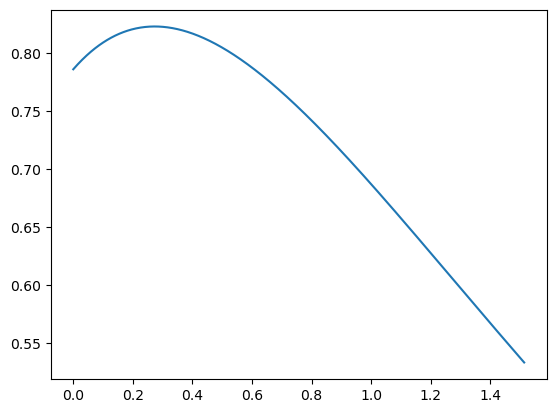

In [ ]:
import matplotlib.pyplot as plt

c0, c1, T = 0.786354, 1.081868, 1.51348
t = np.linspace(0, T, 1000)
plt.plot(t, (c0 + c1 * t) * np.exp(-t))

In [ ]:
states = pl.DataFrame(
    {
        "neuron": rng.integers(0, 3, 7),
        "start": rng.uniform(0, 10, 7),
        "length": rng.uniform(0.1, 2, 7),
        "c0": rng.normal(0, 1, 7),
        "c1": rng.normal(0, 1, 7),
        "value": rng.normal(0, 1, 7),
    }
)
states = states.sort("start")
print("states:", states)
new_states = pl.DataFrame(
    {
        "neuron": rng.integers(0, 3, 5),
        "start": rng.uniform(0, 10, 5),
        "length": rng.uniform(0.1, 2, 5),
        "c0": rng.normal(0, 1, 5),
        "c1": rng.normal(0, 1, 5),
    }
)
new_states = new_states.with_columns(pl.lit(None).cast(pl.Float64).alias("value"))

new_states = new_states.sort("start")

states = states.merge_sorted(new_states, key="start")

first_new_states = new_states.group_by("neuron").agg(pl.first("start").alias("start")).sort("start")

ext_states = states.join(first_new_states, on="neuron", how="left", suffix="_first")

ext_states = ext_states.with_columns(pl.when(pl.col("start") < pl.col("start_first")).then(pl.col("value")).otherwise(None).alias("value"))
ext_states = ext_states.drop("start_first").sort("start")
print("extended states:", ext_states)

states: shape: (7, 6)
┌────────┬──────────┬──────────┬───────────┬───────────┬───────────┐
│ neuron ┆ start    ┆ length   ┆ c0        ┆ c1        ┆ value     │
│ ---    ┆ ---      ┆ ---      ┆ ---       ┆ ---       ┆ ---       │
│ i64    ┆ f64      ┆ f64      ┆ f64       ┆ f64       ┆ f64       │
╞════════╪══════════╪══════════╪═══════════╪═══════════╪═══════════╡
│ 1      ┆ 0.517644 ┆ 0.693048 ┆ 0.398262  ┆ -0.09555  ┆ 0.206139  │
│ 0      ┆ 3.010048 ┆ 0.319528 ┆ 0.288788  ┆ 0.10511   ┆ 2.759038  │
│ 0      ┆ 3.023465 ┆ 0.884372 ┆ -0.039095 ┆ 0.26895   ┆ 0.171145  │
│ 2      ┆ 4.192321 ┆ 0.252082 ┆ -0.084539 ┆ 0.409223  ┆ 0.471024  │
│ 1      ┆ 6.533474 ┆ 0.51511  ┆ 1.117587  ┆ -0.397513 ┆ -0.981237 │
│ 1      ┆ 7.561096 ┆ 1.644174 ┆ 1.440162  ┆ -0.30481  ┆ 0.347847  │
│ 2      ┆ 8.446649 ┆ 1.9385   ┆ 0.358035  ┆ 1.21072   ┆ 0.386212  │
└────────┴──────────┴──────────┴───────────┴───────────┴───────────┘
extended states: shape: (12, 6)
┌────────┬──────────┬──────────┬───────────┬─────

In [ ]:
new_spikes = pl.DataFrame(
    {
        "neuron": [],
        "time": [],
    }
)
new_spikes = new_spikes.sort("time")
new_spikes["time"].first() or 1.0

1.0

In [ ]:
spikes = pl.DataFrame({
    "neuron": [0, 1, 2, 3],
    "time": [0.0, 1.0, 2.0, 3.0],
})

fast_synapses = pl.DataFrame({
    "source": [0, 0, 1],
    "target": [1, 2, 2],
    "delay": [3.0, 1.0, 5.0],
})

paths_to_spikes = spikes.join(
    fast_synapses, left_on="neuron", right_on="target", how="left"
)
spikes_to_spikes = paths_to_spikes.join(
    spikes, left_on="source", right_on="neuron", how="left", suffix="_source"
)
spikes_to_spikes = spikes_to_spikes.select(
    [
        pl.col("neuron"),
        pl.col("time"),
        (pl.col("time_source") + pl.col("delay")).alias("time_in_target"),
    ]
)
spikes_to_spikes,
spikes = spikes_to_spikes.group_by(["neuron", "time"]).agg(pl.col("time_in_target").min())
spikes = spikes.remove(pl.col("time_in_target") < pl.col("time")).drop("time_in_target")
spikes,

(shape: (3, 2)
 ┌────────┬──────┐
 │ neuron ┆ time │
 │ ---    ┆ ---  │
 │ i64    ┆ f64  │
 ╞════════╪══════╡
 │ 1      ┆ 1.0  │
 │ 0      ┆ 0.0  │
 │ 3      ┆ 3.0  │
 └────────┴──────┘,)

In [ ]:
n_nodes = 3
np.repeat(np.arange(n_nodes), n_nodes), np.tile(np.arange(n_nodes), n_nodes),

(array([0, 0, 0, 1, 1, 1, 2, 2, 2]), array([0, 1, 2, 0, 1, 2, 0, 1, 2]))

In [ ]:
from scipy.sparse.csgraph import floyd_warshall
from scipy.sparse import csr_array

def compute_fast_synapses(synapses):
    """ Compute the fastest synapses between nodes in a directed graph."""

    # Initialize fast synapses by grouping and aggregating the minimum delay
    fast_synapses = synapses.group_by(["source", "target"]).agg(
        pl.min("delay").alias("delay")
    )

    # Convert to a sparse matrix for Floyd-Warshall algorithm
    row_ind = fast_synapses.get_column("source").to_numpy()
    col_ind = fast_synapses.get_column("target").to_numpy()
    data = fast_synapses.get_column("delay").to_numpy()
    n_nodes = max(row_ind.max(), col_ind.max()) + 1
    graph = csr_array((data, (row_ind, col_ind)), shape=(n_nodes, n_nodes))
    graph = floyd_warshall(graph, directed=True, overwrite=True)

    # Convert back to DataFrame
    fast_synapses = pl.DataFrame({
        "source": np.repeat(np.arange(n_nodes), n_nodes),
        "target": np.tile(np.arange(n_nodes), n_nodes),
        "delay": graph.flatten(),
    })
    fast_synapses = fast_synapses.filter((pl.col("delay") < np.inf))

    return fast_synapses

synapses = pl.DataFrame({
    "source": [0, 1, 1, 0],
    "target": [1, 2, 2, 2],
    "delay": [3.0, 5.0, 1.0, 10.0],
})
fast_synapses = compute_fast_synapses(synapses)

In [ ]:
from scipy.sparse.csgraph import floyd_warshall
from scipy.sparse import csr_matrix

FIRING_THRESHOLD = 1.0
REFRACTORY_RESET = -1.0


def compute_fast_synapses(synapses):
    """Compute the fastest synapses between nodes in a directed graph."""

    # Initialize fast synapses by grouping and aggregating the minimum delay
    fast_synapses = synapses.group_by(["source", "target"]).agg(
        pl.min("delay").alias("delay")
    )

    # Convert to a sparse matrix for Floyd-Warshall algorithm
    row_ind = fast_synapses.get_column("source").to_numpy()
    col_ind = fast_synapses.get_column("target").to_numpy()
    data = fast_synapses.get_column("delay").to_numpy()
    n_nodes = max(row_ind.max(), col_ind.max()) + 1
    graph = csr_array((data, (row_ind, col_ind)), shape=(n_nodes, n_nodes))
    graph = floyd_warshall(graph, directed=True, overwrite=True)

    # Convert back to DataFrame
    fast_synapses = pl.DataFrame(
        {
            "source": np.repeat(np.arange(n_nodes), n_nodes),
            "target": np.tile(np.arange(n_nodes), n_nodes),
            "delay": graph.flatten(),
        }
    )
    fast_synapses = fast_synapses.filter((pl.col("delay") < np.inf))

    return fast_synapses


def find_first_crossing(
    start,
    length,
    c0,
    c1,
    threshold,
) -> np.ndarray:
    """
    Calculate the first (ascending) crossing time of the states defined by the coefficients `c0` and `c1` with the threshold `threshold`, in their respective time intervals.
    If a crossing does not occur within the interval, NaN is returned for that state.

    Parameters
    ----------
    start : float64 ndarray of shape (n_states,)
        Start times for each state.
    length : float64 ndarray of shape (n_states,)
        Lengths of the states for each state.
    c0 : float64 ndarray of shape (n_states,)
        First-order coefficients for each state.
    c1 : float64 ndarray of shape (n_states,)
        Second-order coefficients for each state.
    threshold : float64 ndarray of shape (n_states,)
        Firing threshold for each state.

    Returns
    -------
    float64 np.ndarray
        First crossing times for each state.
    """

    dt = np.where(
        c0 < threshold,
        np.where(
            c1 > 0.0,
            -(lambertw(-threshold / c1 * np.exp(-c0 / c1), 0)) - c0 / c1,
            np.where(
                c1 < 0.0,
                -(lambertw(-threshold / c1 * np.exp(-c0 / c1), -1)) - c0 / c1,
                np.log(c0 / threshold),
            ),
        ),
        0.0,
    )
    dt[(dt < 0.0) | (dt >= length) | np.iscomplex(dt)] = np.nan
    return start + dt.real


@guvectorize([(float64[:], float64[:], float64[:], float64[:])], "(n),(n),(n)->(n)")
def update_c0(start, c1, ic0, c0):
    c0[0] = ic0[0]
    for n in range(1, len(start)):
        c0[n] = ic0[n] + (c0[n - 1] + c1[n - 1] * (start[n] - start[n - 1])) * np.exp(
            -(start[n] - start[n - 1])
        )


@guvectorize([(float64[:], float64[:], float64[:])], "(n),(n)->(n)")
def update_c1(start, ic1, c1):
    c1[0] = ic1[0]
    for n in range(1, len(start)):
        c1[n] = ic1[n] + c1[n - 1] * np.exp(-(start[n] - start[n - 1]))


def update_coefs(states):
    # Recursively update c1 and c0
    states = states.with_columns(
        pl.struct(["start", "w1"])
        .map_batches(
            lambda batch: update_c1(
                batch.struct.field("start"),
                batch.struct.field("w1"),
            ),
        )
        .alias("c1")
    )
    states = states.with_columns(
        pl.struct(["start", "c1", "w0"])
        .map_batches(
            lambda batch: update_c0(
                batch.struct.field("start"),
                batch.struct.field("c1"),
                batch.struct.field("w0"),
            ),
        )
        .alias("c0")
    )

    return states


def update_lengths(states):
    states = states.with_columns(pl.col("start").diff().over("neuron").alias("length"))
    return states


def update_thresholds(states):
    """Update firing threshold based on the last spike time for each neuron."""
    states = states.with_columns(pl.col("threshold").forward_fill().over("neuron"))
    return states


def update_crossing_times(states):
    """Update only unitialized crossing_time."""

    new_states = states.filter(pl.col("crossing_time").is_null())

    crossing_time = find_first_crossing(
        new_states.get_column("start").to_numpy(),
        new_states.get_column("length").to_numpy(),
        new_states.get_column("c0").to_numpy(),
        new_states.get_column("c1").to_numpy(),
        new_states.get_column("threshold").to_numpy(),
    )
    new_states = new_states.with_columns(crossing_time=crossing_time)
    states = states.update(new_states, on="index")
    return states


def create_synaptic_states(spikes, synapses):
    """Create states from spikes and synaptic synapses. States are sorted by start time.

    states is a DataFrame with columns:
    - neuron: neuron index
    - start: start time of the state
    - ic0: initial condition for c0
    - ic1: initial condition for c1
    - c0: current value of c0
    - c1: current value of c1
    - threshold: firing threshold (not used in this function)

    new_spikes and spikes are DataFrame with columns:
    - neuron: neuron index
    - time: time of the spike
    - next_threshold: next firing threshold after the spike

    synapses is a DataFrame with columns:
    - source: source neuron index
    - target: target neuron index
    - delay: delay of the connection
    - weight: weight of the connection
    """
    states = spikes.join(synapses, left_on="neuron", right_on="source", how="inner")
    states = states.with_columns(
        # pl.lit(None).cast(pl.Int64).alias("index"),
        pl.col("target").alias("neuron"),
        (pl.col("time") + pl.col("delay")).alias("start"),
        pl.lit(0.0).cast(pl.Float64).alias("w0"),
        pl.col("weight").alias("w1"),
        pl.lit(None).cast(pl.Float64).alias("c0"),
        pl.lit(None).cast(pl.Float64).alias("c1"),
        pl.lit(None).cast(pl.Float64).alias("threshold"),
        pl.lit(None).cast(pl.Float64).alias("crossing_time"),
    ).select(
        [
            # "index",
            "neuron",
            "start",
            "w0",
            "w1",
            "c0",
            "c1",
            "threshold",
            "crossing_time",
        ]
    )
    states = states.sort("start")

    return states


def create_refractory_states(spikes):
    # Add refractory reset states
    states = spikes.with_columns(
        # pl.lit(None).cast(pl.Int64).alias("index"),
        pl.col("time").alias("start"),
        pl.lit(REFRACTORY_RESET).cast(pl.Float64).alias("w0"),
        pl.lit(0.0).cast(pl.Float64).alias("w1"),
        pl.lit(REFRACTORY_RESET).cast(pl.Float64).alias("c0"),
        pl.lit(0.0).cast(pl.Float64).alias("c1"),
        pl.col("next_threshold").alias("threshold"),
        pl.lit(None).cast(pl.Float64).alias("crossing_time"),
    ).select(
        [
            # "index",
            "neuron",
            "start",
            "w0",
            "w1",
            "c0",
            "c1",
            "threshold",
            "crossing_time",
        ]
    )
    states = states.sort("start")

    return states


def merge_states(states, new_states):
    first_new_states = (
        new_states.group_by("neuron")
        .agg(pl.first("start").alias("start"))
        .sort("start")
    )

    new_states = new_states.sort("start")
    states = states.drop("index").merge_sorted(new_states, key="start")

    # Deinitialize c0, c1, and crossing_time for states after the inserted new states
    states = states.join(first_new_states, on="neuron", how="left", suffix="_first")
    states = states.with_columns(
        pl.when(pl.col("start") < pl.col("start_first"))
        .then(pl.col("c0"))
        .otherwise(None)
        .alias("c0"),
        pl.when(pl.col("start") <= pl.col("start_first"))
        .then(pl.col("c1"))
        .otherwise(None)
        .alias("c1"),
        pl.when(pl.col("start") < pl.col("start_first"))
        .then(pl.col("crossing_time"))
        .otherwise(None)
        .alias("crossing_time"),
    )
    states = states.drop("start_first")
    states = states.sort("start")
    states = states.with_row_index("index")

    return states


def cleanse_states(states, spikes):
    """
    Cleanse states based on spikes. For each neuron:
    1. Remove all states that start before the last neuron spike
    2. Update the firing threshold of all states that start after
    """
    # Sort spikes by time in descending order, then group by neuron to recover the last firing time
    spikes = spikes.sort("time", descending=True)
    spikes = spikes.group_by("neuron").agg(pl.col("time").first()).sort("time")

    # Join states with spikes on neuron, then filter where start > time
    states = states.join(spikes, on="neuron", how="left").filter(
        pl.col("start") >= pl.col("time")
    )
    states = states.with_columns(
        pl.when(pl.col("start") > pl.col("time"))
        .then(pl.lit(None).cast(pl.Float64))
        .otherwise(pl.col("threshold"))
        .alias("threshold"),
    )
    return states.drop("time").sort("start")


def extract_new_spikes(states, fast_synapses):
    """Accept spikes based on the minimum propagation delay.

    states is a DataFrame with columns:
    - neuron: neuron index
    - start: start time of the state
    - crossing_time: time when the state crosses the threshold

    fast_synapses is a DataFrame with columns:
    - source: source neuron index
    - target: target neuron index
    - delay: delay of the connection
    """

    spikes = states.group_by("neuron").agg(
        pl.col("crossing_time").min().alias("time"),
    )

    paths_to_spikes = spikes.join(
        fast_synapses, left_on="neuron", right_on="target", how="left"
    )
    spikes_to_spikes = paths_to_spikes.join(
        spikes, left_on="source", right_on="neuron", how="left", suffix="_source"
    )
    spikes_to_spikes = spikes_to_spikes.select(
        [
            pl.col("neuron"),
            pl.col("time"),
            (pl.col("time_source") + pl.col("delay")).alias("time_in_target"),
        ]
    )
    spikes = spikes_to_spikes.group_by(["neuron", "time"]).agg(
        pl.col("time_in_target").min()
    )
    spikes = spikes.remove(pl.col("time_in_target") < pl.col("time"))
    spikes = spikes.drop("time_in_target")

    return spikes.sort("time")


def process_new_spikes(new_spikes, spikes, states, synapses):
    """Propagate spikes through the states.

    states is a DataFrame with columns:
    - neuron: neuron index
    - start: start time of the state
    - ic0: initial condition for c0
    - ic1: initial condition for c1
    - c0: current value of c0
    - c1: current value of c1
    - threshold: firing threshold (optional, can be None)

    new_spikes and spikes are DataFrame with columns:
    - neuron: neuron index
    - time: time of the spike
    - next_threshold: next firing threshold after the spike

    synapses is a DataFrame with columns:
    - source: source neuron index
    - target: target neuron index
    - delay: delay of the connection
    - weight: weight of the connection
    """
    # Sort new spikes by time and add them to existing spikes
    spikes = spikes.merge_sorted(new_spikes.sort("time"), key="time")

    # Create new states, corresponding to the propagation of the new spikes through the synaptic synapses and add them to the existing states
    new_states = create_synaptic_states(new_spikes, synapses)
    states = merge_states(states, new_states)
    # states = states.merge_sorted(new_states, key="start")

    # Cleanse states based on the new spikes
    states = cleanse_states(states, new_spikes)

    # Create new states, corresponding to the refractory reset and add them to the existing states
    new_states = create_refractory_states(new_spikes)
    states = merge_states(states, new_states)
    # states = states.merge_sorted(new_states, key="start")

    # Forward update recursions
    states = update_coefs(states)
    states = update_lengths(states)
    states = update_thresholds(states)

    return spikes, states


def create_initial_states(spikes, synapses):
    old_spikes = pl.DataFrame(
        schema={"neuron": pl.Int64, "time": pl.Float64, "next_threshold": pl.Float64}
    )
    old_states = pl.DataFrame(
        schema={
            "index": pl.Int64,
            "neuron": pl.Int64,
            "start": pl.Float64,
            "w0": pl.Float64,
            "w1": pl.Float64,
            "c0": pl.Float64,
            "c1": pl.Float64,
            "threshold": pl.Float64,
            "crossing_time": pl.Float64,
        }
    )
    spikes, states = process_new_spikes(spikes, old_spikes, old_states, synapses)
    return spikes, states


def run(
    spikes, states, synapses, fast_synapses, start, end, threshold_noise=None
):
    """
    Run the simulation from tmin to tmax.
    """
    if threshold_noise is None:
        threshold_noise = lambda size: np.full(size, FIRING_THRESHOLD, dtype=np.float64)

    time = start

    # Main simulation loop
    while time <= end:
        # Get the current spikes
        states = update_crossing_times(states)

        # accept as many spikes as possible, based on the minimum propagation delay
        new_spikes = extract_new_spikes(states, fast_synapses)

        # Add threshold noise for new spikes
        next_threshold = threshold_noise(new_spikes.height)
        new_spikes = new_spikes.with_columns(next_threshold=next_threshold)

        # Process the new spikes
        spikes, states = process_new_spikes(new_spikes, spikes, states, synapses)

        # Update the simulation time
        time = (
            new_spikes["time"].first() or end
        )  # if no new spikes are found, set tmin to tmax

    return spikes, states

In [ ]:
n_neurons = 100
n_spikes = 1_000
n_synapses = 10_000
spikes = pl.DataFrame(
    {
        "neuron": rng.integers(0, n_neurons, n_spikes),
        "time": rng.uniform(0, 10, n_spikes),
        "next_threshold": np.full(n_spikes, FIRING_THRESHOLD) # rng.normal(FIRING_THRESHOLD, 0.2, n_spikes),
    }
)
synapses = pl.DataFrame(
    {
        "source": rng.integers(0, n_neurons, n_synapses),
        "target": rng.integers(0, n_neurons, n_synapses),
        "delay": rng.uniform(0.1, 2.0, n_synapses),
        "weight": rng.normal(1.0, 0.1, n_synapses),
    }
)
start = 0.0
end = 100.0
spikes, states = create_initial_states(spikes, synapses)
fast_synapses = compute_fast_synapses(synapses)
print("spikes:", spikes)
print("states:", states)

spikes: shape: (1_000, 3)
┌────────┬──────────┬────────────────┐
│ neuron ┆ time     ┆ next_threshold │
│ ---    ┆ ---      ┆ ---            │
│ i64    ┆ f64      ┆ f64            │
╞════════╪══════════╪════════════════╡
│ 90     ┆ 0.030195 ┆ 1.041849       │
│ 69     ┆ 0.040688 ┆ 1.442563       │
│ 83     ┆ 0.040768 ┆ 1.081488       │
│ 23     ┆ 0.050385 ┆ 1.086282       │
│ 51     ┆ 0.061624 ┆ 0.540111       │
│ …      ┆ …        ┆ …              │
│ 97     ┆ 9.939605 ┆ 0.839722       │
│ 80     ┆ 9.943738 ┆ 1.017525       │
│ 20     ┆ 9.951609 ┆ 0.790581       │
│ 67     ┆ 9.99156  ┆ 0.913315       │
│ 63     ┆ 9.995116 ┆ 0.866869       │
└────────┴──────────┴────────────────┘
states: shape: (20_390, 10)
┌───────┬────────┬───────────┬──────┬───┬─────────────┬───────────┬───────────────┬──────────┐
│ index ┆ neuron ┆ start     ┆ ic0  ┆ … ┆ c1          ┆ threshold ┆ crossing_time ┆ length   │
│ ---   ┆ ---    ┆ ---       ┆ ---  ┆   ┆ ---         ┆ ---       ┆ ---           ┆ ---      

In [ ]:
spikes, states = run(spikes, states, synapses, fast_synapses, start, end)
print("spikes:", spikes)
print("states:", states)

/var/folders/p1/wl8__y5x6jgfhz_d47k5gq9m0000gn/T/ipykernel_1681/542024657.py:71: RuntimeWarning: divide by zero encountered in divide
  -(lambertw(-threshold / c1 * np.exp(-c0 / c1), 0)) - c0 / c1,
/var/folders/p1/wl8__y5x6jgfhz_d47k5gq9m0000gn/T/ipykernel_1681/542024657.py:71: RuntimeWarning: invalid value encountered in subtract
  -(lambertw(-threshold / c1 * np.exp(-c0 / c1), 0)) - c0 / c1,
/var/folders/p1/wl8__y5x6jgfhz_d47k5gq9m0000gn/T/ipykernel_1681/542024657.py:74: RuntimeWarning: divide by zero encountered in divide
  -(lambertw(-threshold / c1 * np.exp(-c0 / c1), -1)) - c0 / c1,
/var/folders/p1/wl8__y5x6jgfhz_d47k5gq9m0000gn/T/ipykernel_1681/542024657.py:74: RuntimeWarning: invalid value encountered in subtract
  -(lambertw(-threshold / c1 * np.exp(-c0 / c1), -1)) - c0 / c1,
/var/folders/p1/wl8__y5x6jgfhz_d47k5gq9m0000gn/T/ipykernel_1681/542024657.py:75: RuntimeWarning: invalid value encountered in log
  np.log(c0 / threshold),
/var/folders/p1/wl8__y5x6jgfhz_d47k5gq9m0000gn/T

spikes: shape: (156_760, 3)
┌────────┬────────────┬────────────────┐
│ neuron ┆ time       ┆ next_threshold │
│ ---    ┆ ---        ┆ ---            │
│ i64    ┆ f64        ┆ f64            │
╞════════╪════════════╪════════════════╡
│ 90     ┆ 0.030195   ┆ 1.041849       │
│ 69     ┆ 0.040688   ┆ 1.442563       │
│ 83     ┆ 0.040768   ┆ 1.081488       │
│ 23     ┆ 0.050385   ┆ 1.086282       │
│ 51     ┆ 0.061624   ┆ 0.540111       │
│ …      ┆ …          ┆ …              │
│ 2      ┆ 100.000878 ┆ 1.0            │
│ 56     ┆ 100.000971 ┆ 1.0            │
│ 46     ┆ 100.001693 ┆ 1.0            │
│ 86     ┆ 100.002122 ┆ 1.0            │
│ 45     ┆ 100.003661 ┆ 1.0            │
└────────┴────────────┴────────────────┘
states: shape: (109_568, 10)
┌────────┬────────┬────────────┬──────┬───┬──────────────┬───────────┬───────────────┬──────────┐
│ index  ┆ neuron ┆ start      ┆ ic0  ┆ … ┆ c1           ┆ threshold ┆ crossing_time ┆ length   │
│ ---    ┆ ---    ┆ ---        ┆ ---  ┆   ┆ ---   

In [ ]:
states.tail(10)

index,neuron,start,ic0,ic1,c0,c1,threshold,crossing_time,length
u32,i64,f64,f64,f64,f64,f64,f64,f64,f64
109558,84,101.995002,0.0,1.084226,35422.008939,33005.886819,1.0,null,0.001247
109559,70,101.9962,0.0,1.141488,35419.092167,32967.506567,1.0,null,0.031897
109560,3,101.99631,0.0,1.12145,35418.822786,32965.008212,1.0,null,0.00336
109561,55,101.998012,0.0,1.055832,35414.600736,32909.985389,1.0,null,0.011718
109562,35,101.998281,0.0,1.057302,35413.926174,32902.194755,1.0,null,0.034208
109563,70,101.998509,0.0,0.987324,35413.353657,32895.693606,1.0,null,0.002309
109564,22,101.999231,0.0,0.865229,35411.526262,32872.79431,1.0,null,0.033713
109565,60,101.999547,0.0,0.911739,35410.723191,32863.328697,1.0,null,0.017573
109566,72,101.999833,0.0,1.176862,35409.994068,32855.116613,1.0,null,0.019042


In [ ]:
n_neurons, n_synapses = 100, 10_000
spikes = pl.DataFrame(
    schema={"neuron": pl.Int64, "time": pl.Float64, "f_thresh": pl.Float64}
)
states = pl.DataFrame(
    schema={
        "neuron": pl.Int64,
        "start": pl.Float64,
        "w0": pl.Float64,
        "w1": pl.Float64,
        "c0": pl.Float64,
        "c1": pl.Float64,
        "f_thresh": pl.Float64,
    }
)
synapses = pl.DataFrame(
    {
        "source": rng.integers(0, n_neurons, n_synapses),
        "target": rng.integers(0, n_neurons, n_synapses),
        "delay": rng.random(n_synapses),
        "weight": rng.random(n_synapses),
    }
)

# states = pl.DataFrame(
#     {
#         "neuron": rng.integers(0, 5, 4),
#         "start": rng.random(4),
#         "w0": rng.random(4),
#         "w1": rng.random(4),
#         "c0": rng.random(4),
#         "c1": rng.random(4),
#         "f_thresh": 1.0
#     }
# )
# states = states.sort("start")

In [ ]:
for tmin in range(50):
    n_new_spikes = rng.integers(1, 5)
    new_spikes = pl.DataFrame(
        {
            "neuron": rng.integers(0, n_neurons, n_new_spikes),
            "time": rng.uniform(tmin, tmin + 1.0, n_new_spikes),
            "f_thresh": rng.normal(1.0, 0.1, n_new_spikes),
        }
    )
    spikes, states = propagate_spikes(new_spikes, spikes, states, synapses)

In [ ]:
spikes, states

(shape: (21, 3)
 ┌────────┬──────────┬──────────┐
 │ neuron ┆ time     ┆ f_thresh │
 │ ---    ┆ ---      ┆ ---      │
 │ i64    ┆ f64      ┆ f64      │
 ╞════════╪══════════╪══════════╡
 │ 143    ┆ 0.25045  ┆ 0.985988 │
 │ 402    ┆ 0.286166 ┆ 1.078251 │
 │ 754    ┆ 0.288164 ┆ 1.029571 │
 │ 291    ┆ 0.746777 ┆ 0.98139  │
 │ 545    ┆ 1.764763 ┆ 0.90327  │
 │ …      ┆ …        ┆ …        │
 │ 570    ┆ 6.495557 ┆ 0.948187 │
 │ 844    ┆ 6.892507 ┆ 1.076367 │
 │ 226    ┆ 7.908981 ┆ 0.885833 │
 │ 56     ┆ 8.800529 ┆ 0.898133 │
 │ 536    ┆ 9.694097 ┆ 0.824307 │
 └────────┴──────────┴──────────┘,
 shape: (10_470, 7)
 ┌────────┬───────────┬──────┬──────────┬────────────┬────────────┬──────────┐
 │ neuron ┆ start     ┆ ic0  ┆ ic1      ┆ c0         ┆ c1         ┆ f_thresh │
 │ ---    ┆ ---       ┆ ---  ┆ ---      ┆ ---        ┆ ---        ┆ ---      │
 │ i64    ┆ f64       ┆ f64  ┆ f64      ┆ f64        ┆ f64        ┆ f64      │
 ╞════════╪═══════════╪══════╪══════════╪════════════╪════════════╪══

In [ ]:
spikes, states.filter(pl.col("neuron") == 0)

(shape: (21, 3)
 ┌────────┬──────────┬──────────┐
 │ neuron ┆ time     ┆ f_thresh │
 │ ---    ┆ ---      ┆ ---      │
 │ i64    ┆ f64      ┆ f64      │
 ╞════════╪══════════╪══════════╡
 │ 143    ┆ 0.25045  ┆ 0.985988 │
 │ 402    ┆ 0.286166 ┆ 1.078251 │
 │ 754    ┆ 0.288164 ┆ 1.029571 │
 │ 291    ┆ 0.746777 ┆ 0.98139  │
 │ 545    ┆ 1.764763 ┆ 0.90327  │
 │ …      ┆ …        ┆ …        │
 │ 570    ┆ 6.495557 ┆ 0.948187 │
 │ 844    ┆ 6.892507 ┆ 1.076367 │
 │ 226    ┆ 7.908981 ┆ 0.885833 │
 │ 56     ┆ 8.800529 ┆ 0.898133 │
 │ 536    ┆ 9.694097 ┆ 0.824307 │
 └────────┴──────────┴──────────┘,
 shape: (11, 7)
 ┌────────┬───────────┬─────┬──────────┬────────────┬────────────┬──────────┐
 │ neuron ┆ start     ┆ ic0 ┆ ic1      ┆ c0         ┆ c1         ┆ f_thresh │
 │ ---    ┆ ---       ┆ --- ┆ ---      ┆ ---        ┆ ---        ┆ ---      │
 │ i64    ┆ f64       ┆ f64 ┆ f64      ┆ f64        ┆ f64        ┆ f64      │
 ╞════════╪═══════════╪═════╪══════════╪════════════╪════════════╪══════════╡

In [ ]:
states.tail(10)

neuron,start,ic0,ic1,c0,c1,f_thresh
i64,f64,f64,f64,f64,f64,f64
3,0.573135,0.333887,0.562286,0.270527,0.750053,1.0
2,0.689576,0.0,0.253539,null,null,1.027005
2,0.712082,0.972272,0.972697,0.73119,0.894274,1.0
4,0.811003,-1.0,0.0,-1.0,0.0,1.007108
3,0.838468,0.0,0.390043,null,null,1.007108
0,0.888993,0.777885,0.086873,0.613156,0.8375,1.0
3,1.019643,0.0,0.86917,null,null,1.007108
2,1.197403,0.0,0.204441,null,null,1.027005
0,1.376575,0.0,0.862695,null,null,1.007108


In [ ]:
new_states = new_spikes.join(synapses, left_on="neuron", right_on="source", how="inner")
new_states = new_states.with_columns(
    start=(pl.col("time") + pl.col("delay")),
    neuron=pl.col("target"),
    ic0=0.0,
    ic1=pl.col("weight"),
    c0=pl.lit(None).cast(pl.Float64),
    c1=pl.lit(None).cast(pl.Float64),
)
new_states = new_states.drop(["time", "target", "weight", "delay"])
new_states = new_states.sort("start")
new_states,

(shape: (8, 6)
 ┌────────┬──────────┬─────┬──────────┬──────┬──────┐
 │ neuron ┆ start    ┆ ic0 ┆ ic1      ┆ c0   ┆ c1   │
 │ ---    ┆ ---      ┆ --- ┆ ---      ┆ ---  ┆ ---  │
 │ i64    ┆ f64      ┆ f64 ┆ f64      ┆ f64  ┆ f64  │
 ╞════════╪══════════╪═════╪══════════╪══════╪══════╡
 │ 9      ┆ 0.430378 ┆ 0.0 ┆ 0.420269 ┆ null ┆ null │
 │ 9      ┆ 0.543191 ┆ 0.0 ┆ 0.547473 ┆ null ┆ null │
 │ 0      ┆ 0.588939 ┆ 0.0 ┆ 0.465409 ┆ null ┆ null │
 │ 7      ┆ 0.654131 ┆ 0.0 ┆ 0.051046 ┆ null ┆ null │
 │ 9      ┆ 1.288046 ┆ 0.0 ┆ 0.420269 ┆ null ┆ null │
 │ 9      ┆ 1.400859 ┆ 0.0 ┆ 0.547473 ┆ null ┆ null │
 │ 0      ┆ 1.446606 ┆ 0.0 ┆ 0.465409 ┆ null ┆ null │
 │ 7      ┆ 1.511799 ┆ 0.0 ┆ 0.051046 ┆ null ┆ null │
 └────────┴──────────┴─────┴──────────┴──────┴──────┘,)

In [ ]:

states = states.merge_sorted(new_states, key="start")
states,

(shape: (55, 6)
 ┌────────┬──────────┬──────────┬──────────┬──────────┬──────────┐
 │ neuron ┆ start    ┆ ic0      ┆ ic1      ┆ c0       ┆ c1       │
 │ ---    ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      │
 │ i64    ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64      │
 ╞════════╪══════════╪══════════╪══════════╪══════════╪══════════╡
 │ 4      ┆ 0.004448 ┆ 0.628231 ┆ 0.995093 ┆ 0.953112 ┆ 0.329923 │
 │ 2      ┆ 0.027197 ┆ 0.73377  ┆ 0.742915 ┆ 0.920421 ┆ 0.654787 │
 │ 0      ┆ 0.033175 ┆ 0.358285 ┆ 0.015897 ┆ 0.12986  ┆ 0.642515 │
 │ 1      ┆ 0.095392 ┆ 0.912651 ┆ 0.134949 ┆ 0.310924 ┆ 0.827695 │
 │ 5      ┆ 0.120341 ┆ 0.826516 ┆ 0.229221 ┆ 0.289833 ┆ 0.886167 │
 │ …      ┆ …        ┆ …        ┆ …        ┆ …        ┆ …        │
 │ 1      ┆ 0.989216 ┆ 0.8218   ┆ 0.581064 ┆ 0.308825 ┆ 0.794376 │
 │ 4      ┆ 1.044756 ┆ 0.0      ┆ 0.831804 ┆ null     ┆ null     │
 │ 2      ┆ 1.288653 ┆ 0.0      ┆ 0.577928 ┆ null     ┆ null     │
 │ 5      ┆ 1.441824 ┆ 0.0      ┆ 0.343562 ┆ n

In [ ]:
# Join states with spikes on neuron, then filter where start > time
states = (
    states.join(new_spikes, on="neuron", how="left")
    .remove(pl.col("start") < pl.col("time"))
    .drop("time")
)
states,

(shape: (49, 6)
 ┌────────┬──────────┬──────────┬──────────┬──────────┬──────────┐
 │ neuron ┆ start    ┆ ic0      ┆ ic1      ┆ c0       ┆ c1       │
 │ ---    ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      │
 │ i64    ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64      │
 ╞════════╪══════════╪══════════╪══════════╪══════════╪══════════╡
 │ 2      ┆ 0.027197 ┆ 0.73377  ┆ 0.742915 ┆ 0.920421 ┆ 0.654787 │
 │ 0      ┆ 0.033175 ┆ 0.358285 ┆ 0.015897 ┆ 0.12986  ┆ 0.642515 │
 │ 1      ┆ 0.095392 ┆ 0.912651 ┆ 0.134949 ┆ 0.310924 ┆ 0.827695 │
 │ 5      ┆ 0.120341 ┆ 0.826516 ┆ 0.229221 ┆ 0.289833 ┆ 0.886167 │
 │ 1      ┆ 0.132745 ┆ 0.005027 ┆ 0.71322  ┆ 0.887983 ┆ 0.66593  │
 │ …      ┆ …        ┆ …        ┆ …        ┆ …        ┆ …        │
 │ 1      ┆ 0.989216 ┆ 0.8218   ┆ 0.581064 ┆ 0.308825 ┆ 0.794376 │
 │ 4      ┆ 1.044756 ┆ 0.0      ┆ 0.831804 ┆ null     ┆ null     │
 │ 2      ┆ 1.288653 ┆ 0.0      ┆ 0.577928 ┆ null     ┆ null     │
 │ 5      ┆ 1.441824 ┆ 0.0      ┆ 0.343562 ┆ n

In [ ]:
REFRACTORY_RESET = -1.0
new_states = new_spikes.with_columns(
    start=pl.col("time"),
    ic0=REFRACTORY_RESET,
    ic1=0.0,
    c0=REFRACTORY_RESET,
    c1=0.0,
)
new_states = new_states.drop(["time"])
new_states = new_states.sort("start")
new_states,

(shape: (2, 6)
 ┌────────┬──────────┬──────┬─────┬──────┬─────┐
 │ neuron ┆ start    ┆ ic0  ┆ ic1 ┆ c0   ┆ c1  │
 │ ---    ┆ ---      ┆ ---  ┆ --- ┆ ---  ┆ --- │
 │ i64    ┆ f64      ┆ f64  ┆ f64 ┆ f64  ┆ f64 │
 ╞════════╪══════════╪══════╪═════╪══════╪═════╡
 │ 7      ┆ 0.294198 ┆ -1.0 ┆ 0.0 ┆ -1.0 ┆ 0.0 │
 │ 4      ┆ 0.661398 ┆ -1.0 ┆ 0.0 ┆ -1.0 ┆ 0.0 │
 └────────┴──────────┴──────┴─────┴──────┴─────┘,)

In [ ]:
states = states.merge_sorted(new_states, key="start")
states,

(shape: (51, 6)
 ┌────────┬──────────┬──────────┬──────────┬──────────┬──────────┐
 │ neuron ┆ start    ┆ ic0      ┆ ic1      ┆ c0       ┆ c1       │
 │ ---    ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      │
 │ i64    ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64      │
 ╞════════╪══════════╪══════════╪══════════╪══════════╪══════════╡
 │ 2      ┆ 0.027197 ┆ 0.73377  ┆ 0.742915 ┆ 0.920421 ┆ 0.654787 │
 │ 0      ┆ 0.033175 ┆ 0.358285 ┆ 0.015897 ┆ 0.12986  ┆ 0.642515 │
 │ 1      ┆ 0.095392 ┆ 0.912651 ┆ 0.134949 ┆ 0.310924 ┆ 0.827695 │
 │ 5      ┆ 0.120341 ┆ 0.826516 ┆ 0.229221 ┆ 0.289833 ┆ 0.886167 │
 │ 1      ┆ 0.132745 ┆ 0.005027 ┆ 0.71322  ┆ 0.887983 ┆ 0.66593  │
 │ …      ┆ …        ┆ …        ┆ …        ┆ …        ┆ …        │
 │ 1      ┆ 0.989216 ┆ 0.8218   ┆ 0.581064 ┆ 0.308825 ┆ 0.794376 │
 │ 4      ┆ 1.044756 ┆ 0.0      ┆ 0.831804 ┆ null     ┆ null     │
 │ 2      ┆ 1.288653 ┆ 0.0      ┆ 0.577928 ┆ null     ┆ null     │
 │ 5      ┆ 1.441824 ┆ 0.0      ┆ 0.343562 ┆ n

In [ ]:
# 0. Sort states and add end times
states = states.sort("start")
states = states.with_columns(
    pl.col("start").shift(-1).over("neuron").alias("end")
)

# 1. Clean states, only those that end after tmin are kept
states = clean_states(tmin, states)

# 2. Calculate next firing times
new_spikes = next_ftimes(
    states, # needs to add f_thresh
    min_delays, # optional??
)

# 4. Fire spikes and reset states
fire_spikes(
    new_f_times,
    new_f_sources,
    f_times,
    f_sources,
    f_thresh,
    start,
    c0,
    c1,
    ic0,
    ic1,
    f_thresh_noise,
)

# 5.a. Sort new firing times and sources
new_f_sorter = np.argsort(new_f_sources, axis=0)
new_f_sources = np.take_along_axis(new_f_sources, new_f_sorter, axis=0)
new_f_times = np.take_along_axis(new_f_times, new_f_sorter, axis=0)
f_neurons_counts = neurons_counts_in_sources(new_f_sources, neurons)

# 5.b. Propagate spikes through the network
propagate_spikes(
    new_f_times,
    new_f_sources,
    f_neurons_counts,
    in_sources,
    in_delays,
    in_weights,
    in_neurons_counts,
    start,
    ic0,
    ic1,
)

# 6. Sort states
sorter = np.argsort(start, axis=0)
start = np.take_along_axis(start, sorter, axis=0)
c0 = np.take_along_axis(c0, sorter, axis=0)
c1 = np.take_along_axis(c1, sorter, axis=0)
ic0 = np.take_along_axis(ic0, sorter, axis=0)
ic1 = np.take_along_axis(ic1, sorter, axis=0)

tmin = np.nanmin(
    new_f_times, initial=np.inf
)  # if no firings, tmin is set to inf


NameError: name 'tmin' is not defined

In [ ]:
%%timeit
n_states = 1000
n_jits = 1000
start = np.sort(rng.random(n_states))
inds = rng.choice(n_states, size=n_jits, replace=False)
start[inds] = rng.random(n_jits)
states = pl.DataFrame(
    {
        "start": start,
        "neuron": np.random.randint(0, 50, n_states),
        "w0": np.random.random(n_states),
        "w1": np.random.random(n_states),
        "c0": np.random.random(n_states),
        "c1": np.random.random(n_states),
    }
)

174 μs ± 4.5 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
%%timeit
n_states = 1000
n_jits = 100 # 10 -> 615us - 155us = 460us # 100 -> 640us - 160us = 480us # 1000 -> 750us - 174us = 576us
start = np.sort(rng.random(n_states))
inds = rng.choice(n_states, size=n_jits, replace=False)
start[inds] = rng.random(n_jits)
states = pl.DataFrame(
    {
        "start": start,
        "neuron": np.random.randint(0, 50, n_states),
        "w0": np.random.random(n_states),
        "w1": np.random.random(n_states),
        "c0": np.random.random(n_states),
        "c1": np.random.random(n_states),
    }
)
states = states.sort("start")
states = states.with_columns(
    pl.col("start").shift(-1).over("neuron").alias("end")
)
states = states.with_columns(
    length=pl.col("end") - pl.col("start")
)
# states = states.with_columns(
#     pl.struct(["start"])
#     .map_batches(
#         lambda batch: update_length(
#             batch.struct.field("start"),
#         ),
#         return_dtype=pl.Float64
#     )
#     .over("neuron")
#     .alias("length")
# )
states

706 μs ± 38.9 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
@guvectorize([(float64[:], float64[:], float64[:], float64[:])], "(n),(n),(n)->(n)")
def update_c0(start, c1, ic0, c0):
    c0[0] = ic0[0]
    for n in range(1, len(start)):
        c0[n] = ic0[n] + (c0[n - 1] + c1[n - 1] * (start[n] - start[n - 1])) * np.exp(
            -(start[n] - start[n - 1])
        )


@guvectorize([(float64[:], float64[:], float64[:])], "(n),(n)->(n)")
def update_c1(start, ic1, c1):
    c1[0] = ic1[0]
    for n in range(1, len(start)):
        c1[n] = ic1[n] + c1[n - 1] * np.exp(-(start[n] - start[n - 1]))


# @guvectorize([(float64[:], float64[:])], "(n)->(n)")
# def update_length(start, length):
#     for n in range(len(start) - 1):
#         length[n] = start[n + 1] - start[n]
#     length[-1] = np.inf


# @guvectorize([(float64[:], float64[:])], "(n)->(n)")
# def next_ftime(c0, next_ftime):
#     next_f_time = lambertw(c0 / np.exp(1)).real

In [ ]:
states = states.with_columns(next_ftime=1.0)
states = states.with_columns(
    pl.when(pl.col("c0") < 0.5)
    .then(0.0)
    .otherwise(pl.col("next_ftime"))
    .alias("next_ftime")
)
states,

(shape: (10, 7)
 ┌──────────┬────────┬──────────┬──────────┬──────────┬──────────┬────────────┐
 │ start    ┆ neuron ┆ ic0      ┆ ic1      ┆ c0       ┆ c1       ┆ next_ftime │
 │ ---      ┆ ---    ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---        │
 │ f64      ┆ i64    ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64        │
 ╞══════════╪════════╪══════════╪══════════╪══════════╪══════════╪════════════╡
 │ 0.819545 ┆ 43     ┆ 0.877414 ┆ 0.338312 ┆ 0.641435 ┆ 0.358827 ┆ 1.0        │
 │ 0.730509 ┆ 51     ┆ 0.443433 ┆ 0.788105 ┆ 0.838718 ┆ 0.513039 ┆ 1.0        │
 │ 0.101613 ┆ 72     ┆ 0.131372 ┆ 0.009238 ┆ 0.371216 ┆ 0.995022 ┆ 0.0        │
 │ 0.150167 ┆ 65     ┆ 0.729987 ┆ 0.268464 ┆ 0.917346 ┆ 0.932514 ┆ 1.0        │
 │ 0.510867 ┆ 18     ┆ 0.400894 ┆ 0.161901 ┆ 0.401202 ┆ 0.722686 ┆ 0.0        │
 │ 0.133081 ┆ 59     ┆ 0.568217 ┆ 0.5984   ┆ 0.523992 ┆ 0.16478  ┆ 1.0        │
 │ 0.898621 ┆ 84     ┆ 0.637247 ┆ 0.512808 ┆ 0.592398 ┆ 0.405422 ┆ 1.0        │
 │ 0.219749 ┆ 5      ┆ 0

In [ ]:
states,

(shape: (1_000, 7)
 ┌──────────┬────────┬──────────┬──────────┬──────────┬──────────┬──────┐
 │ start    ┆ neuron ┆ ic0      ┆ ic1      ┆ c0       ┆ c1       ┆ next │
 │ ---      ┆ ---    ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---  │
 │ f64      ┆ i64    ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64  │
 ╞══════════╪════════╪══════════╪══════════╪══════════╪══════════╪══════╡
 │ 0.000089 ┆ 33     ┆ 0.580879 ┆ 0.010093 ┆ 0.119609 ┆ 0.300751 ┆ 0.0  │
 │ 0.001414 ┆ 75     ┆ 0.478914 ┆ 0.018988 ┆ 0.344865 ┆ 0.422729 ┆ 0.0  │
 │ 0.004552 ┆ 51     ┆ 0.56261  ┆ 0.489714 ┆ 0.180255 ┆ 0.27264  ┆ 0.0  │
 │ 0.004812 ┆ 47     ┆ 0.076357 ┆ 0.946887 ┆ 0.833717 ┆ 0.66463  ┆ 0.0  │
 │ 0.005743 ┆ 18     ┆ 0.137823 ┆ 0.797412 ┆ 0.126421 ┆ 0.573593 ┆ 0.0  │
 │ …        ┆ …      ┆ …        ┆ …        ┆ …        ┆ …        ┆ …    │
 │ 0.995538 ┆ 6      ┆ 0.802132 ┆ 0.873365 ┆ 0.295051 ┆ 0.31586  ┆ 0.0  │
 │ 0.997571 ┆ 48     ┆ 0.434478 ┆ 0.188441 ┆ 0.231101 ┆ 0.283834 ┆ 0.0  │
 │ 0.997883 ┆ 25   

In [ ]:
states = states.with_columns(
    pl.struct(["start"])
    .map_batches(
        lambda batch: update_length(
            batch.struct.field("start"),
        ),
        return_dtype=pl.Float64
    )
    .over("neuron")
    .alias("length")
)
states

start,neuron,ic0,ic1,c0,c1,length
f64,i64,f64,f64,f64,f64,f64
0.084957,21,0.362213,0.73146,0.475511,0.280716,inf
0.183064,68,0.060556,0.041368,0.60143,0.33072,inf
0.379184,88,0.407451,0.830762,0.026508,0.416371,inf
0.557785,63,0.026347,0.094625,0.502867,0.324953,inf
0.659117,71,0.308135,0.757711,0.694859,0.735153,inf
0.686445,12,0.018598,0.730712,0.790994,0.792236,inf
0.699856,89,0.269918,0.959601,0.082207,0.765383,inf
0.790458,8,0.452634,0.484391,0.162194,0.933384,inf
0.880243,81,0.189221,0.695962,0.342864,0.733968,inf


In [ ]:
states = states.with_columns(
    pl.struct(["start", "w1"])
    .map_batches(
        lambda batch: update_c1(
            batch.struct.field("start"),
            batch.struct.field("w1"),
        ),
    )
    .alias("c1")
)
states = states.with_columns(
    pl.struct(["start", "c1", "w0"])
    .map_batches(
        lambda batch: update_c0(
            batch.struct.field("start"),
            batch.struct.field("c1"),
            batch.struct.field("w0"),
        ),
    )
    .alias("c0")
)
states

start,neuron,ic0,ic1,c0,c1
f64,i64,f64,f64,f64,f64
0.160309,38,0.505856,0.505856,0.0,0.505856
0.918213,78,0.541265,0.067128,2.9708e-313,0.304196
0.240586,36,1.726408,0.061528,6.9289e-310,0.660551
0.902165,99,2.189846,0.958089,2.1220e-314,1.298957
0.257596,2,6.665917,0.019166,0.0,2.493896
…,…,…,…,…,…
0.766683,17,NaN,0.346971,1.8767e-152,388.154393
0.724443,64,NaN,0.036817,3.3720e257,404.938185
0.199963,99,NaN,0.716353,3.1830e-313,684.891491


In [ ]:
# Compare polars and numpy (+ numba) performances
# - f_times,
# - f_sources,
# - in_sources,
# - in_weights,
# - in_delays,
# - start,
# - ic0,
# - ic1,

In [ ]:
from rsnn.new.sim import clean_states

In [ ]:
rng = np.random.default_rng()

n_neurons, n_states = 1000, 10_000
tmin = 0.5
start = rng.random((n_states, n_neurons))
start[:-9000] = np.nan
start = np.sort(start, axis=0)
c0 = rng.random((n_states, n_neurons))
c1 = rng.random((n_states, n_neurons))
ic0 = rng.random((n_states, n_neurons))
ic1 = rng.random((n_states, n_neurons))

In [ ]:
tmin = 0.5
n_neurons, n_states = 1000, 10000

start = rng.random((n_states, n_neurons))
# start[:9000] = np.nan
start[:9000] = np.nan
start[-2] = -np.inf
start[-1] = np.inf
start.sort(axis=0)
c0 = rng.random((n_states, n_neurons))
c1 = rng.random((n_states, n_neurons))
ic0 = rng.random((n_states, n_neurons))
ic1 = rng.random((n_states, n_neurons))

In [ ]:
%timeit clean_states(tmin, start, c0, c1, ic0, ic1)

24.5 ms ± 8.04 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:

# states_df
# # # states_df = states_df.sort("start")

In [ ]:
n_neurons, n_states = 100, 1000

start = rng.random((n_states, n_neurons))
start[:900] = np.nan
start[-2] = -np.inf
start[-1] = np.inf
start.sort(axis=0)

c0 = rng.random((n_states, n_neurons))
c1 = rng.random((n_states, n_neurons))
ic0 = rng.random((n_states, n_neurons))
ic1 = rng.random((n_states, n_neurons))

for tmin in np.linspace(0.1, 1.0, 1000):
    n_new_states = rng.integers(0, 10, size=1).item()
    clean_states(tmin, start, c0, c1, ic0, ic1)

    # start[-n_new_states-1:-1] = rng.random((n_new_states, n_neurons))
    # c0[-n_new_states-1:-1] = rng.random((n_new_states, n_neurons))
    # c1[-n_new_states-1:-1] = rng.random((n_new_states, n_neurons))
    # ic0[-n_new_states-1:-1] = rng.random((n_new_states, n_neurons))
    # ic1[-n_new_states-1:-1] = rng.random((n_new_states, n_neurons))

    # start[-n_new_states-1:-1] = 1.0
    # c0[-n_new_states-1:-1] = 1.0
    # c1[-n_new_states-1:-1] = 1.0
    # ic0[-n_new_states-1:-1] = 1.0
    # ic1[-n_new_states-1:-1] = 1.0


In [ ]:
n_neurons = 100
n_states = 1000

states_df = pl.DataFrame(
    {
        "neuron": rng.integers(0, n_neurons, n_states),
        "start": rng.random(n_states),
        "c0": rng.random(n_states),
        "c1": rng.random(n_states),
        "w0": rng.random(n_states),
        "w1": rng.random(n_states),
    }
)
states_df = states_df.sort("start")
states_df = states_df.with_columns(
    pl.col("start").shift(-1).over("neuron").alias("end")
)
states_df = states_df.with_columns(length=(pl.col("end") - pl.col("start")))

for tmin in np.linspace(0.1, 1.0, 1000):
    n_new_states = rng.integers(0, 1000, size=1)
    states_df = states_df.filter(pl.col("end") < tmin)
    states_df = states_df.extend(
        pl.DataFrame(
            {
                "neuron": rng.integers(0, n_neurons, n_new_states),
                "start": rng.random(n_new_states),
                "c0": rng.random(n_new_states),
                "c1": rng.random(n_new_states),
                "w0": rng.random(n_new_states),
                "w1": rng.random(n_new_states),
                "end": np.nan,  # Placeholder for end, will be computed later
                "length": np.nan,  # Placeholder for length, will be computed later
            }
        )
    )
    states_df = states_df.sort("start")
    states_df = states_df.with_columns(
        pl.col("start").shift(-1).over("neuron").alias("end")
    )
    states_df = states_df.with_columns(length=(pl.col("end") - pl.col("start")))

states_df, 

(shape: (189_557, 8)
 ┌────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┐
 │ neuron ┆ start    ┆ c0       ┆ c1       ┆ ic0      ┆ ic1      ┆ end      ┆ length   │
 │ ---    ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      │
 │ i64    ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64      │
 ╞════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╡
 │ 87     ┆ 0.000006 ┆ 0.05629  ┆ 0.589354 ┆ 0.594608 ┆ 0.936022 ┆ 0.000073 ┆ 0.000067 │
 │ 96     ┆ 0.000007 ┆ 0.275432 ┆ 0.572601 ┆ 0.857916 ┆ 0.466608 ┆ 0.000042 ┆ 0.000035 │
 │ 15     ┆ 0.000008 ┆ 0.178395 ┆ 0.691266 ┆ 0.600907 ┆ 0.252706 ┆ 0.000992 ┆ 0.000985 │
 │ 43     ┆ 0.000012 ┆ 0.106537 ┆ 0.026693 ┆ 0.92496  ┆ 0.856872 ┆ 0.000079 ┆ 0.000067 │
 │ 8      ┆ 0.000013 ┆ 0.62187  ┆ 0.150635 ┆ 0.695512 ┆ 0.91766  ┆ 0.000255 ┆ 0.000242 │
 │ …      ┆ …        ┆ …        ┆ …        ┆ …        ┆ …        ┆ …        ┆ …        │


In [ ]:
# numpy
n_neurons, _ = in_sources.shape

for l in range(n_neurons):
    in_times, in_weights = receive_in_spikes(
        f_times,
        f_sources,
        f_sources_counts[l],
        in_sources[l],
        in_weights[l],
        in_delays[l],
        in_sources_counts[l],
    )

    start[-in_times.size :, l] = in_times
    ic0[-in_times.size :, l] = np.zeros_like(in_weights)
    ic1[-in_times.size :, l] = in_weights

In [ ]:
# polars


In [ ]:
def create_spikes_df(neurons, times):
    """A dataframe representing spikes of neurons at given times."""
    spikes = pl.DataFrame({"time": times, "neuron": neurons})
    spikes = spikes.sort("time")
    spikes = spikes.with_columns(
        pl.col("time").shift(1).over("neuron").alias("last_time")
    )
    spikes = spikes.with_row_index()
    return spikes


def create_synapses_df(sources, targets, delays, weights):
    """A dataframe representing synapses between neurons."""
    synapses = pl.DataFrame(
        {"source": sources, "target": targets, "delay": delays, "weight": weights}
    )
    # synapses = synapses.with_row_index()
    return synapses


def create_paths_to_spikes_df(spikes, synapses):
    """A dataframe representing all synapses through which spikes enter a neuron producing a spike."""
    return spikes.join(synapses, left_on="neuron", right_on="target", how="inner")


def create_paths_from_spikes_df(spikes, synapses):
    """A dataframe representing all synapses through which spikes leave a neuron producing a spike."""
    return spikes.join(synapses, left_on="neuron", right_on="source", how="inner")


def create_spikes_to_spikes_df(spikes, synapses):
    """A dataframe representing all spikes that enter a neuron producing a spike."""
    paths_to_spikes = create_paths_to_spikes(spikes, synapses)
    spikes_to_spikes = paths_to_spikes.join(
        spikes, left_on="source", right_on="neuron", how="inner", suffix="_src"
    )
    spikes_to_spikes = spikes_to_spikes.select(
        [
            pl.col("index_src"),
            pl.col("index").alias("index_tgt"),
            pl.col("time_src"),
            pl.col("source").alias("neuron_src"),
            pl.col("time").alias("time_tgt"),
            pl.col("last_time").alias("last_time_tgt"),
            pl.col("neuron").alias("neuron_tgt"),
            pl.col("delay"),
            pl.col("weight"),
        ]
    )
    
    spikes_to_spikes = spikes_to_spikes.filter(
        (pl.col("time_src") + pl.col("delay") < pl.col("time_tgt"))
        & (pl.col("time_src") + pl.col("delay") < pl.col("last_time_tgt"))
    )
    return spikes_to_spikes

def fmod_pl(x, period, offset=0):
    """A function to compute the periodic value of x with respect to period and offset."""
    return x - period * (x - offset).floordiv(period)

In [ ]:
neurons = rng.integers(0, 10, 100)
starts = np.sort(rng.uniform(0, 20, 100))
lengths = np.diff(starts, append=np.inf)
intervals = np.arange(100)
weights = rng.normal(0, 1, 100)
synapses = rng.integers(0, 10, 100)
c0s = rng.normal(0, 1, 100)
c1s = rng.normal(0, 1, 100)
uppers = rng.uniform(0, 20, 100)
max_values = rng.uniform(0, 1, 100)

states = pl.DataFrame(
        {"neuron": 0, "interval": intervals, "start": starts, "length": lengths, "weight": weights, "synapse": synapses, "c0":c1s, "c1": c0s, "limit": uppers, "max_value": max_values}
    )
states,

(shape: (100, 10)
 ┌────────┬──────────┬───────────┬──────────┬───┬───────────┬───────────┬───────────┬───────────┐
 │ neuron ┆ interval ┆ start     ┆ length   ┆ … ┆ c0        ┆ c1        ┆ limit     ┆ max_value │
 │ ---    ┆ ---      ┆ ---       ┆ ---      ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
 │ i32    ┆ i64      ┆ f64       ┆ f64      ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
 ╞════════╪══════════╪═══════════╪══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
 │ 0      ┆ 0        ┆ 0.187056  ┆ 0.196192 ┆ … ┆ -1.186622 ┆ 0.412254  ┆ 1.315492  ┆ 0.960222  │
 │ 0      ┆ 1        ┆ 0.383248  ┆ 0.508821 ┆ … ┆ 0.580143  ┆ 0.771549  ┆ 2.505741  ┆ 0.351996  │
 │ 0      ┆ 2        ┆ 0.892068  ┆ 0.060532 ┆ … ┆ -2.589725 ┆ -0.862951 ┆ 6.429416  ┆ 0.355588  │
 │ 0      ┆ 3        ┆ 0.9526    ┆ 0.413328 ┆ … ┆ 0.37422   ┆ 1.421363  ┆ 1.416492  ┆ 0.5773    │
 │ 0      ┆ 4        ┆ 1.365928  ┆ 0.607725 ┆ … ┆ 0.898915  ┆ -0.568141 ┆ 12.810638 ┆ 0.683988  │
 │

In [ ]:
period = 10.0
spikes = create_spikes_df(f_neurons, f_times)
synapses = create_synapses_df(in_sources, in_targets, in_delays, in_weights)
spikes_to_spikes = create_spikes_to_spikes_df(spikes, synapses)

# periodic spikes
spikes_to_spikes = spikes_to_spikes.with_columns(
    time_src_in_tgt=(pl.col("time_src") + pl.col("delay")) - period * ((pl.col("time_src") + pl.col("delay")) - pl.col("last_time_tgt")).floordiv(period)
)
spikes_to_spikes = spikes_to_spikes.filter((pl.col("time_src_in_tgt") < pl.col("time_tgt")))

spikes_to_spikes,

(shape: (1_744, 10)
 ┌───────────┬───────────┬──────────┬────────────┬───┬───────────┬──────────┬───────────┬───────────┐
 │ index_src ┆ index_tgt ┆ time_src ┆ neuron_src ┆ … ┆ neuron_tg ┆ delay    ┆ weight    ┆ time_src_ │
 │ ---       ┆ ---       ┆ ---      ┆ ---        ┆   ┆ t         ┆ ---      ┆ ---       ┆ in_tgt    │
 │ u32       ┆ u32       ┆ f64      ┆ i64        ┆   ┆ ---       ┆ f64      ┆ f64       ┆ ---       │
 │           ┆           ┆          ┆            ┆   ┆ i64       ┆          ┆           ┆ f64       │
 ╞═══════════╪═══════════╪══════════╪════════════╪═══╪═══════════╪══════════╪═══════════╪═══════════╡
 │ 21        ┆ 87        ┆ 3.415463 ┆ 0          ┆ … ┆ 7         ┆ 2.733434 ┆ 1.641273  ┆ 16.148897 │
 │ 6         ┆ 75        ┆ 1.251254 ┆ 9          ┆ … ┆ 2         ┆ 3.515275 ┆ -1.158746 ┆ 14.766529 │
 │ 9         ┆ 75        ┆ 1.45157  ┆ 9          ┆ … ┆ 2         ┆ 3.515275 ┆ -1.158746 ┆ 14.966845 │
 │ 13        ┆ 96        ┆ 2.306818 ┆ 9          ┆ … ┆ 2      

In [ ]:
spikes = pl.DataFrame({"time": f_times, "neuron": f_neurons})
spikes = spikes.sort("time")
spikes = spikes.with_columns(pl.col("time").shift(1).over("neuron").alias("last_time"))
spikes = spikes.with_row_index()
spikes,

(shape: (100, 4)
 ┌───────┬──────────┬────────┬───────────┐
 │ index ┆ time     ┆ neuron ┆ last_time │
 │ ---   ┆ ---      ┆ ---    ┆ ---       │
 │ u32   ┆ f64      ┆ i64    ┆ f64       │
 ╞═══════╪══════════╪════════╪═══════════╡
 │ 0     ┆ 0.000759 ┆ 2      ┆ null      │
 │ 1     ┆ 0.010646 ┆ 0      ┆ null      │
 │ 2     ┆ 0.021512 ┆ 7      ┆ null      │
 │ 3     ┆ 0.028666 ┆ 2      ┆ 0.000759  │
 │ 4     ┆ 0.034606 ┆ 2      ┆ 0.028666  │
 │ …     ┆ …        ┆ …      ┆ …         │
 │ 95    ┆ 0.9631   ┆ 8      ┆ 0.963019  │
 │ 96    ┆ 0.966839 ┆ 7      ┆ 0.96296   │
 │ 97    ┆ 0.981004 ┆ 3      ┆ 0.878002  │
 │ 98    ┆ 0.986439 ┆ 8      ┆ 0.9631    │
 │ 99    ┆ 0.99442  ┆ 3      ┆ 0.981004  │
 └───────┴──────────┴────────┴───────────┘,)

In [ ]:
synapses = pl.DataFrame(
    {
        # "index": in_indices,
        "source": in_sources,
        "target": in_targets,
        "delay": in_delays,
        "weight": in_weights,
    }
)
synapses,

(shape: (1_000, 4)
 ┌────────┬────────┬──────────┬──────────┐
 │ source ┆ target ┆ delay    ┆ weight   │
 │ ---    ┆ ---    ┆ ---      ┆ ---      │
 │ i64    ┆ i64    ┆ f64      ┆ f64      │
 ╞════════╪════════╪══════════╪══════════╡
 │ 7      ┆ 3      ┆ 0.134291 ┆ 0.463887 │
 │ 8      ┆ 8      ┆ 0.869801 ┆ 0.336847 │
 │ 3      ┆ 4      ┆ 0.288105 ┆ 0.278319 │
 │ 1      ┆ 7      ┆ 0.838088 ┆ 0.292395 │
 │ 0      ┆ 0      ┆ 0.056148 ┆ 0.789191 │
 │ …      ┆ …      ┆ …        ┆ …        │
 │ 8      ┆ 5      ┆ 0.592232 ┆ 0.473471 │
 │ 1      ┆ 5      ┆ 0.545914 ┆ 0.798249 │
 │ 2      ┆ 3      ┆ 0.571841 ┆ 0.508763 │
 │ 8      ┆ 2      ┆ 0.271555 ┆ 0.151855 │
 │ 2      ┆ 9      ┆ 0.211906 ┆ 0.566702 │
 └────────┴────────┴──────────┴──────────┘,)

In [ ]:
paths_to_spikes = spikes.join(synapses, left_on="neuron", right_on="target", how="inner")
paths_from_spikes = spikes.join(synapses, left_on="neuron", right_on="source", how="inner")
paths_to_spikes, paths_from_spikes

(shape: (9_992, 7)
 ┌───────┬──────────┬────────┬───────────┬────────┬──────────┬──────────┐
 │ index ┆ time     ┆ neuron ┆ last_time ┆ source ┆ delay    ┆ weight   │
 │ ---   ┆ ---      ┆ ---    ┆ ---       ┆ ---    ┆ ---      ┆ ---      │
 │ u32   ┆ f64      ┆ i64    ┆ f64       ┆ i64    ┆ f64      ┆ f64      │
 ╞═══════╪══════════╪════════╪═══════════╪════════╪══════════╪══════════╡
 │ 7     ┆ 0.054185 ┆ 3      ┆ null      ┆ 7      ┆ 0.134291 ┆ 0.463887 │
 │ 15    ┆ 0.155004 ┆ 3      ┆ 0.054185  ┆ 7      ┆ 0.134291 ┆ 0.463887 │
 │ 32    ┆ 0.354091 ┆ 3      ┆ 0.155004  ┆ 7      ┆ 0.134291 ┆ 0.463887 │
 │ 36    ┆ 0.393348 ┆ 3      ┆ 0.354091  ┆ 7      ┆ 0.134291 ┆ 0.463887 │
 │ 41    ┆ 0.461691 ┆ 3      ┆ 0.393348  ┆ 7      ┆ 0.134291 ┆ 0.463887 │
 │ …     ┆ …        ┆ …      ┆ …         ┆ …      ┆ …        ┆ …        │
 │ 53    ┆ 0.622071 ┆ 9      ┆ 0.305087  ┆ 2      ┆ 0.211906 ┆ 0.566702 │
 │ 61    ┆ 0.691745 ┆ 9      ┆ 0.622071  ┆ 2      ┆ 0.211906 ┆ 0.566702 │
 │ 75    ┆ 0.816005

In [ ]:
# spikes_to_spikes = paths_from_spikes.join(spikes, left_on="target", right_on="neuron", how="inner", suffix="_to")
spikes_to_spikes = paths_to_spikes.join(
    spikes, left_on="source", right_on="neuron", how="inner", suffix="_from"
)
spikes_to_spikes = spikes_to_spikes.with_columns(
    time_from_in=pl.col("time_from") + pl.col("delay")
)
spikes_to_spikes = spikes_to_spikes.filter(
    (pl.col("time_from_in") < pl.col("time"))
    & (pl.col("time_from_in") >= pl.col("last_time"))
)
spikes_to_spikes,

(shape: (3_954, 11)
 ┌───────┬──────────┬────────┬───────────┬───┬────────────┬───────────┬──────────────┬──────────────┐
 │ index ┆ time     ┆ neuron ┆ last_time ┆ … ┆ index_from ┆ time_from ┆ last_time_fr ┆ time_from_in │
 │ ---   ┆ ---      ┆ ---    ┆ ---       ┆   ┆ ---        ┆ ---       ┆ om           ┆ ---          │
 │ u32   ┆ f64      ┆ i64    ┆ f64       ┆   ┆ u32        ┆ f64       ┆ ---          ┆ f64          │
 │       ┆          ┆        ┆           ┆   ┆            ┆           ┆ f64          ┆              │
 ╞═══════╪══════════╪════════╪═══════════╪═══╪════════════╪═══════════╪══════════════╪══════════════╡
 │ 32    ┆ 0.354091 ┆ 3      ┆ 0.155004  ┆ … ┆ 2          ┆ 0.021512  ┆ null         ┆ 0.155804     │
 │ 32    ┆ 0.354091 ┆ 3      ┆ 0.155004  ┆ … ┆ 9          ┆ 0.09026   ┆ 0.021512     ┆ 0.224552     │
 │ 32    ┆ 0.354091 ┆ 3      ┆ 0.155004  ┆ … ┆ 10         ┆ 0.091082  ┆ 0.09026      ┆ 0.225373     │
 │ 32    ┆ 0.354091 ┆ 3      ┆ 0.155004  ┆ … ┆ 19         ┆ 0.

In [ ]:
spikes_to_spikes = spikes_to_spikes.with_columns(coefficient=pl.col("weight")* (1 + pl.col("time_from_in") - pl.col("time")) * (pl.col("time_from_in") - pl.col("time")).exp())
spikes_to_spikes
        #         * np.exp(-(f_time_i - in_times_j)))

index,time,neuron,last_time,source,delay,weight,index_from,time_from,last_time_from,time_from_in,coefficient
u32,f64,i64,f64,i64,f64,f64,u32,f64,f64,f64,f64
32,0.354091,3,0.155004,7,0.134291,0.463887,2,0.021512,null,0.155804,0.305012
32,0.354091,3,0.155004,7,0.134291,0.463887,9,0.09026,0.021512,0.224552,0.354735
32,0.354091,3,0.155004,7,0.134291,0.463887,10,0.091082,0.09026,0.225373,0.355361
32,0.354091,3,0.155004,7,0.134291,0.463887,19,0.19211,0.091082,0.326401,0.438725
36,0.393348,3,0.354091,7,0.134291,0.463887,21,0.221444,0.19211,0.355736,0.429959
…,…,…,…,…,…,…,…,…,…,…,…
28,0.305087,9,0.189643,2,0.211906,0.566702,4,0.034606,0.028666,0.246512,0.503155
53,0.622071,9,0.305087,2,0.211906,0.566702,11,0.114583,0.034606,0.32649,0.297041
53,0.622071,9,0.305087,2,0.211906,0.566702,27,0.289653,0.114583,0.50156,0.441822


In [ ]:
agg_spikes_to_spikes = spikes_to_spikes.group_by(["index", "index_from"]).sum()
agg_spikes_to_spikes = agg_spikes_to_spikes.sort(["index", "index_from"])
agg_spikes_to_spikes

index,index_from,time,neuron,last_time,source,delay,weight,time_from,last_time_from,time_from_in,coefficient
u32,u32,f64,i64,f64,i64,f64,f64,f64,f64,f64,f64
8,0,0.064316,0,0.010646,2,0.042576,0.448177,0.000759,0.0,0.043335,0.429663
8,2,0.064316,0,0.010646,7,0.002009,0.099228,0.021512,0.0,0.023521,0.091375
8,5,0.064316,0,0.010646,6,0.010204,0.838062,0.047173,0.0,0.057378,0.826492
9,0,0.09026,7,0.021512,2,0.085126,0.603607,0.000759,0.0,0.085886,0.598343
9,7,0.09026,7,0.021512,3,0.022448,0.343654,0.054185,0.0,0.076633,0.334383
…,…,…,…,…,…,…,…,…,…,…,…
99,64,0.99442,3,0.981004,6,0.290741,0.046821,0.703096,0.647691,0.993837,0.046766
99,65,0.99442,3,0.981004,8,0.289484,0.290535,0.704785,0.658595,0.994269,0.290447
99,66,0.99442,3,0.981004,8,0.272377,0.27452,0.716796,0.704785,0.989173,0.271651


In [ ]:
@njit
def get_Phi_jit(A, n_spikes):
    Phi = np.identity(n_spikes, dtype=np.float64)
    for n in range(n_spikes):
        Phi[n] = A[n] @ Phi
    Phi -= 1 / n_spikes
    return Phi

def get_Phi(A, n_spikes):
    Phi = np.identity(n_spikes, dtype=np.float64)
    for n in range(n_spikes):
        Phi[n] = A[n] @ Phi
    Phi -= 1 / n_spikes
    return Phi

In [ ]:
A = np.zeros((n_spikes, n_spikes), dtype=np.float64)
from_indices = agg_spikes_to_spikes.get_column("index_from").to_numpy()
to_indices = agg_spikes_to_spikes.get_column("index").to_numpy()
coefficients = agg_spikes_to_spikes.get_column("coefficient").to_numpy()
A[from_indices, to_indices] = coefficients
A /= np.sum(A, axis=1, keepdims=True)
%timeit Phi = get_Phi_jit(A, n_spikes)
%timeit Phi = get_Phi(A, n_spikes)

/var/folders/p1/wl8__y5x6jgfhz_d47k5gq9m0000gn/T/ipykernel_3847/2820821042.py:6: RuntimeWarning: invalid value encountered in divide
  A /= np.sum(A, axis=1, keepdims=True)


148 μs ± 11.7 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)
336 μs ± 24 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
agg_spikes_to_spikes.get_column("index").to_numpy(), agg_spikes_to_spikes.get_column("index_from").to_numpy(), agg_spikes_to_spikes.get_column("coefficient").to_numpy()

(array([ 5,  6,  8, ..., 99, 99, 99], shape=(1906,), dtype=uint32),
 array([ 0,  1,  0, ..., 90, 92, 93], shape=(1906,), dtype=uint32),
 array([0.69289749, 0.08295122, 1.03072535, ..., 0.41712822, 0.8251512 ,
        0.82964874], shape=(1906,)))

In [ ]:
# Causal past of every spike
causal_spikes = spikes.join(synapses, left_on="neuron", right_on="target", how="inner")
past_spikes
# out_spikes = out_spikes.with_columns(in_f_time=pl.col("time") + pl.col("delay"))
# out_spikes

In [ ]:
# Causal past of every spike
past_spikes = spikes.join(synapses, left_on="neuron", right_on="target", how="inner")
past_spikes
# out_spikes = out_spikes.with_columns(in_f_time=pl.col("time") + pl.col("delay"))
# out_spikes

time,neuron,last_time,source,delay,weight,order
f64,i64,f64,i64,f64,f64,i32
0.524077,0,null,1,0.510791,0.990787,1
0.524077,0,null,1,0.75651,0.406038,1
0.524077,0,null,1,0.710441,0.283208,1
0.60226,1,null,2,0.029964,0.780144,1
0.820457,0,0.524077,1,0.510791,0.990787,1
0.820457,0,0.524077,1,0.75651,0.406038,1
0.820457,0,0.524077,1,0.710441,0.283208,1


In [ ]:
# Causal future of every spike
future_spikes = spikes.join(synapses, left_on="neuron", right_on="source", how="inner")
future_spikes

time,neuron,target,delay,weight,order
f64,i64,i64,f64,f64,i32
0.619256,2,2,0.305115,0.517989,1
0.332379,2,2,0.305115,0.517989,1
0.876098,1,1,0.550353,0.855711,1


In [ ]:
import numpy as np
from typing import Tuple
import numpy.typing as npt
from scipy.special import lambertw
from scipy.sparse.csgraph import floyd_warshall

from numba import njit, prange

FIRING_THRESHOLD = 1.0
REFRACTORY_RESET = -1.0
N_STATES = 10000  # Maximum number of states per neuron


def run(
    f_times: npt.NDArray[np.float64],
    f_sources: npt.NDArray[np.int64],
    f_thresh: npt.NDArray[np.float64],
    in_sources: npt.NDArray[np.int64],
    in_delays: npt.NDArray[np.float64],
    in_weights: npt.NDArray[np.float64],
    tmin: float,
    tmax: float,
    f_thresh_std: float = 0.0,
):
    """Run the simulation.

    Warning: This function assumes that the synaptic inputs are sorted by source neuron.

    Args:
        tmin (_type_): _description_
        tmax (_type_): _description_
        f_thresh (_type_): _description_
        in_sources (_type_): _description_
        in_delays (_type_): _description_
        in_weights (_type_): _description_
        f_times (_type_): _description_
        f_sources (_type_): _description_
        f_thresh_std (float, optional): _description_. Defaults to 0.0.
    """
    # Sort the inputs per source neuron and delays
    in_sources, in_delays, in_weights = sort_inputs(in_sources, in_delays, in_weights)

    # Initialize propagation delay matrix (i.e., the minimum delay between each pair of neurons)
    min_delays = init_min_delays(in_sources, in_delays)
    min_delays = floyd_warshall(min_delays, overwrite=True)

    # Initialize states
    st_start, st_c0, st_c1, st_ic0, st_ic1 = init_states(
        in_sources, in_delays, in_weights, f_times, f_sources
    )

    while tmin < tmax:
        # 1. Clean states before tmin
        st_start, st_c0, st_c1, st_ic0, st_ic1 = clean_states(
            tmin, st_start, st_c0, st_c1, st_ic0, st_ic1
        )

        # 2. Sort states (only the removed states have to be placed at the end)
        st_start, st_c0, st_c1, st_ic0, st_ic1 = sort_states(
            st_start, st_c0, st_c1, st_ic0, st_ic1
        )

        # 3. Calculate next firing times
        new_f_times, new_f_sources = next_f_times(
            f_thresh,
            st_start,
            st_c0,
            st_c1,
            st_ic0,
            st_ic1,
            min_delays,
        )

        # 4. Fire spikes and reset states
        f_times, f_sources, st_start, st_c0, st_c1, st_ic0, st_ic1 = fire_spikes(
            new_f_times,
            new_f_sources,
            # last_f_times,
            f_thresh,
            f_times,
            f_sources,
            st_start,
            st_c0,
            st_c1,
            st_ic0,
            st_ic1,
            f_thresh_std,
        )

        # 5. Propagate spikes through the network
        st_start, st_c0, st_c1, st_ic0, st_ic1 = propagate_spikes(
            new_f_times,
            new_f_sources,
            in_sources,
            in_delays,
            in_weights,
            st_start,
            st_c0,
            st_c1,
            st_ic0,
            st_ic1,
        )

        # 6. Sort states
        st_start, st_c0, st_c1, st_ic0, st_ic1 = sort_states(
            st_start, st_c0, st_c1, st_ic0, st_ic1
        )

        tmin = np.nanmin(
            new_f_times, initial=np.inf
        )  # if no firings, tmin is set to inf


def init_states(f_times, f_sources, in_sources, in_delays, in_weights):
    n_neurons = in_sources.shape[0]
    st_start = np.full((N_STATES, n_neurons), np.nan, dtype=np.float64)
    st_start[0, :] = -np.inf  # initial state
    st_start[1, :] = np.inf  # final state
    st_c0 = np.zeros_like(st_start, dtype=np.float64)
    st_c1 = np.zeros_like(st_start, dtype=np.float64)
    st_ic0 = np.zeros_like(st_start, dtype=np.float64)
    st_ic1 = np.zeros_like(st_start, dtype=np.float64)

    st_start, st_c0, st_c1, st_ic0, st_ic1 = propagate_spikes(
        f_times,
        f_sources,
        in_sources,
        in_delays,
        in_weights,
        st_start,
        st_c0,
        st_c1,
        st_ic0,
        st_ic1,
    )

    # Determine the last firing times for each source neuron
    last_f_times, last_f_souces = find_last_f_times(f_times, f_sources)

    # Flush the input spikes and reset to the refractory state
    st_start, st_c0, st_c1, st_ic0, st_ic1 = reset_states(
        last_f_times, last_f_souces, st_start, st_c0, st_c1, st_ic0, st_ic1
    )

    return st_start, st_c0, st_c1, st_ic0, st_ic1


@njit(parallel=True)
def init_min_delays(in_sources, in_delays):
    """
    Compute the minimum direct connection delay between all neuron pairs.

    For each postsynaptic neuron `j`, this function finds all presynaptic neurons `i` listed in `in_sources[j]` and records the smallest delay from `i` to `j` in the output matrix.
    If no direct connection exists, the delay remains `np.inf`.

    Parameters
    ----------
    in_sources : ndarray of int64, shape (n_neurons, n_inputs)
        For each postsynaptic neuron (rows), the source neuron IDs of its incoming
        synapses.
        Must be sorted by source ID, and for equal IDs sorted by delay.
    in_delays : ndarray of float64, shape (n_neurons, n_inputs)
        The synaptic delays corresponding to `in_sources`.

    Returns
    -------
    min_delays : ndarray of float64, shape (n_neurons, n_neurons)
        Matrix where entry `(i, j)` is the minimum delay from presynaptic neuron `i` to postsynaptic neuron `j`.
        Entries are `np.inf` if no direct connection exists.
    """

    n_neurons = in_sources.shape[0]
    neurons = np.arange(n_neurons)
    min_delays = np.full((n_neurons, n_neurons), np.inf, dtype=np.float64)
    for l in prange(n_neurons):
        pos = np.searchsorted(in_sources[l], neurons, side="left")
        ids = np.argwhere(in_sources[l, pos] == neurons).flatten()
        min_delays[ids, l] = in_delays[l, pos[ids]]

    return min_delays


def sort_inputs(
    in_sources: npt.NDArray[np.int64],
    in_delays: npt.NDArray[np.float64],
    in_weights: npt.NDArray[np.float64],
) -> Tuple[npt.NDArray[np.int64], npt.NDArray[np.float64], npt.NDArray[np.float64]]:
    """
    Sort each neuron's inputs first by source ID, then by delay.

    Parameters
    ----------
    in_sources : ndarray of int64, shape (n_neurons, n_inputs)
        Source neuron IDs for each postsynaptic neuron.
    in_delays : ndarray of float64, shape (n_neurons, n_inputs)
        Synaptic delays corresponding to `in_sources`.
    in_weights : ndarray of float64, shape (n_neurons, n_inputs)
        Synaptic weights corresponding to `in_sources`.

    Returns
    -------
    in_sources : ndarray of int64
        Source IDs sorted per neuron by (source, delay).
    in_delays : ndarray of float64
        Delays reordered to match the sorted sources.
    in_weights : ndarray of float64
        Weights reordered to match the sorted sources.
    """

    sorter = np.lexsort((in_delays, in_sources), axis=1)
    in_sources = np.take_along_axis(in_sources, sorter, axis=1)
    in_delays = np.take_along_axis(in_delays, sorter, axis=1)
    in_weights = np.take_along_axis(in_weights, sorter, axis=1)
    return in_sources, in_delays, in_weights


def find_last_f_times(f_times, f_sources):
    unique_sources = np.unique(f_sources)
    sorter = np.lexsort((f_times, f_sources))
    indices_last = (
        np.searchsorted(f_sources, unique_sources, side="right", sorter=sorter) - 1
    )
    return f_times[sorter][indices_last], f_sources[sorter][indices_last]


@njit(parallel=True)
def reset_states(f_times, f_sources, st_start, st_c0, st_c1, st_ic0, st_ic1):
    """Reset the states of the neurons that fire.


    Args:
        f_times (npt.NDArray[np.float64]): The firing times for the neurons.
        f_sources (npt.NDArray[np.int64]): The source neurons for the firings.
    """

    for n in prange(f_sources.size):
        l, ft = f_sources[n], f_times[n]
        ipos = np.searchsorted(st_start[:, l], ft, side="left")
        st_start[1:ipos, l] = np.nan
        st_start[-1, l] = ft
        st_c0[-1, l] = REFRACTORY_RESET
        st_ic0[-1, l] = REFRACTORY_RESET

    return st_start, st_c0, st_c1, st_ic0, st_ic1


@njit(parallel=True)
def clean_states(tmin, st_start, st_c0, st_c1, st_ic0, st_ic1):
    """
    Consolidate all states occurring before `tmin` into the last state before `tmin`, and remove (mark as NaN) earlier states.

    This function is designed for per-neuron state histories that are:
    - **Sorted** along the first axis by their start time (`st_start`).
    - **Framed** by an initial state at `-np.inf` (index 0) and a final state at `np.inf` (right before the trailing NaNs).

    For each neuron:
      1. Find the index of the most recent state before `tmin`.
      2. Accumulate contributions from all previous states into that state's coefficients (`st_c0`, `st_c1`).
      3. Mark all earlier states (rows 1 to that index) as removed by setting their `st_start` entries to `NaN`.

    Parameters
    ----------
    tmin : float
        The cutoff time. Only the last state before this time is preserved.
    st_start : ndarray of shape (n_states, n_neurons)
        Start times for each state (must be sorted along axis 0, with NaNs trailing).
    st_c0 : ndarray of shape (n_states, n_neurons)
        First-order cumulative coefficients (will be updated in place).
    st_c1 : ndarray of shape (n_states, n_neurons)
        Second-order cumulative coefficients (will be updated in place).
    st_ic0 : ndarray of shape (n_states, n_neurons)
        First-order independent coefficients (used for recursive updates).
    st_ic1 : ndarray of shape (n_states, n_neurons)
        Second-order independent coefficients (used for recursive updates).

    Returns
    -------
    (st_start, st_c0, st_c1, st_ic0, st_ic1) : tuple of ndarrays
        The same arrays, modified in place:
        - All states before `tmin` are removed except the last one.
        - Coefficients of the preserved state now include contributions from the removed states.
    """
    n_neurons = st_start.shape[1]
    for l in prange(n_neurons):
        ipos = (
            np.searchsorted(st_start[:, l], tmin, side="right") - 1
        )  # always >= 0 since -np.inf is at the start

        st_c0[ipos, l] = st_ic0[ipos, l]
        st_c1[ipos, l] = st_ic1[ipos, l]

        for j in range(1, ipos):
            dt = st_start[ipos, l] - st_start[j, l]

            st_c0[ipos, l] += st_ic0[j, l] * np.exp(-dt)
            st_c0[ipos, l] += st_ic1[j, l] * dt * np.exp(-dt)
            st_c1[ipos, l] += st_ic1[j, l] * np.exp(-dt)

        st_start[1:ipos, l] = np.nan

    return st_start, st_c0, st_c1, st_ic0, st_ic1


def sort_states(
    st_start: npt.NDArray[np.float64],
    st_c0: npt.NDArray[np.float64],
    st_c1: npt.NDArray[np.float64],
    st_ic0: npt.NDArray[np.float64],
    st_ic1: npt.NDArray[np.float64],
) -> Tuple[
    npt.NDArray[np.float64],
    npt.NDArray[np.float64],
    npt.NDArray[np.float64],
    npt.NDArray[np.float64],
    npt.NDArray[np.float64],
]:
    """
    Sort all states of each neuron by their start times (`st_start`).
    The order of the other state arrays (`st_c0`, `st_c1`, `st_ic0`, `st_ic1`) is adjusted accordingly.

    The sort order is:
    - `-np.inf` (initial state)
    - All finite values (sorted ascending)
    - `np.inf` (final state)
    - `NaN` (removed states)

    Parameters
    ----------
    st_start : ndarray of shape (n_states, n_neurons)
        Start times for each state (must be sorted along axis 0).
    st_c0 : ndarray of shape (n_states, n_neurons)
        First-order cumulative coefficients.
    st_c1 : ndarray of shape (n_states, n_neurons)
        Second-order cumulative coefficients.
    st_ic0 : ndarray of shape (n_states, n_neurons)
        First-order independent coefficients.
    st_ic1 : ndarray of shape (n_states, n_neurons)
        Second-order independent coefficients.

    Returns
    -------
    (st_start, st_c0, st_c1, st_ic0, st_ic1) : tuple of ndarrays
        A sorted copy of the provided arrays.
    """
    sorter = np.argsort(st_start, axis=0)
    st_start = np.take_along_axis(st_start, sorter, axis=0)
    st_c0 = np.take_along_axis(st_c0, sorter, axis=0)
    st_c1 = np.take_along_axis(st_c1, sorter, axis=0)
    st_ic0 = np.take_along_axis(st_ic0, sorter, axis=0)
    st_ic1 = np.take_along_axis(st_ic1, sorter, axis=0)
    return st_start, st_c0, st_c1, st_ic0, st_ic1


def first_crossing(
    start,
    length,
    c0,
    c1,
    f_thresh,
) -> np.ndarray:
    """
    Calculate the first (ascending) crossing time of the states defined by the coefficients `c0` and `c1` with the threshold `f_thresh`, in their respective time intervals.
    If a crossing does not occur within the interval, NaN is returned for that state.

    Parameters
    ----------
    start : ndarray of shape (n_states,)
        Start times for each state.
    length : ndarray of shape (n_states,)
        Lengths of the states for each state.
    c0 : ndarray of shape (n_states,)
        First-order coefficients for each state.
    c1 : ndarray of shape (n_states,)
        Second-order coefficients for each state.
    f_thresh : ndarray of shape (n_states,)
        Firing threshold for each state.

    Returns
    -------
    np.ndarray
        First crossing times for each state.
    """

    dt0 = -(lambertw(-f_thresh / c1 * np.exp(-c0 / c1), 0)) - c0 / c1
    dt1 = -(lambertw(-f_thresh / c1 * np.exp(-c0 / c1), -1)) - c0 / c1
    dt2 = np.log(c0 / f_thresh)

    new_f_times = np.where(
        c0 < f_thresh,
        np.where(
            c1 > 0,
            np.where(
                np.isreal(dt0) & (dt0 >= 0.0) & (dt0 < length), start + dt0.real, np.nan
            ),
            np.where(
                c1 < 0,
                np.where(
                    np.isreal(dt1) & (dt1 >= 0.0) & (dt1 < length),
                    start + dt1.real,
                    np.nan,
                ),
                np.where((dt2 >= 0.0) & (dt2 < length), start + dt2, np.nan),
            ),
        ),
        start,
    )
    return new_f_times


def next_f_times(f_thresh, st_start, st_c0, st_c1, st_ic0, st_ic1, min_delays):
    """
    Calculate the next (causally independent) firings produced in the network, among all neurons.

    Warning: This function requires the states to be sorted by st_start.

    Returns:
        Tuple[npt.NDArray[np.float64], npt.NDArray[np.int64]]: A tuple containing:
            - f_times: Array of firing times.
            - f_sources: Array of firing sources (neuron indices).
    """
    n_intervals, n_neurons = st_start.shape
    f_times = np.full(n_neurons, np.nan, dtype=np.float64)
    max_f_times = np.full(n_neurons, np.inf, dtype=np.float64)
    n_indices = np.arange(n_neurons)
    nf_indices = n_indices[:]

    for n in range(1, n_intervals - 1):  # st_start
        # early exit if no neuron can possibly fire
        if nf_indices.size == 0:
            break

        # update the coefficients
        prev_length = st_start[n, nf_indices] - st_start[n - 1, nf_indices]
        st_c0[n, nf_indices] = (
            st_c0[n - 1, nf_indices]
            + np.nan_to_num(prev_length) * st_c1[n - 1, nf_indices]
        ) * np.exp(-(prev_length)) + st_ic0[n, nf_indices]
        st_c1[n, nf_indices] = (
            st_c1[n - 1, nf_indices] * np.exp(-(prev_length)) + st_ic1[n, nf_indices]
        )

        # update the candidate firing times
        f_times[nf_indices] = first_crossing(
            st_start[n, nf_indices],
            np.clip(
                st_start[n + 1, nf_indices],
                None,
                max_f_times[nf_indices],
            )
            - st_start[n, nf_indices],
            st_c0[n, nf_indices],
            st_c1[n, nf_indices],
            f_thresh[nf_indices],
        )

        # update the maximum firing times
        max_f_times = np.nanmin(
            np.nan_to_num(f_times[None, :], nan=np.inf)
            + min_delays,  # can be further optimized... use Numba???
            initial=np.inf,
            axis=1,
        )

        # update the indices of the neurons that can possibly fire
        nf_indices = n_indices[np.isnan(f_times) & (st_start[n] < max_f_times)]

    f_sources = np.argwhere(f_times <= max_f_times).flatten()
    f_times = f_times[f_sources]
    return f_times, f_sources


def fire_spikes(
    new_f_times,
    new_f_sources,
    f_thresh,
    f_times,
    f_sources,
    st_start,
    st_c0,
    st_c1,
    st_ic0,
    st_ic1,
    f_thresh_std=0.0,
):
    # Concatenate the new firing times and sources with the existing ones
    f_times = np.concatenate((f_times, new_f_times))
    f_sources = np.concatenate((f_sources, new_f_sources))

    # Flush the input spikes and reset to the refractory state
    st_start, st_c0, st_c1, st_ic0, st_ic1 = reset_states(
        new_f_times, new_f_sources, st_start, st_c0, st_c1, st_ic0, st_ic1
    )

    # Apply threshold noise
    f_thresh[f_sources] = rng.normal(
        FIRING_THRESHOLD, f_thresh_std, size=f_sources.size
    )

    return f_times, f_sources, st_start, st_c0, st_c1, st_ic0, st_ic1


@njit(parallel=True)
def propagate_spikes(
    new_f_times,
    new_f_sources,
    in_sources,
    in_delays,
    in_weights,
    st_start,
    st_c0,
    st_c1,
    st_ic0,
    st_ic1,
):
    """
    Propagate new spikes through the network.
    Add new states at the end of the state arrays...

    Warning: This function assumes that the synaptic inputs are sorted by source neuron. Moreover, the states should be large enough to not overwrite existing states...

    Args:
        new_f_times (_type_): _description_
        new_f_sources (_type_): _description_
        in_sources (_type_): _description_
        in_delays (_type_): _description_
        in_weights (_type_): _description_
        st_start (_type_): _description_
        st_c0 (_type_): _description_
        st_c1 (_type_): _description_
        st_ic0 (_type_): _description_
        st_ic1 (_type_): _description_

    Returns:
        _type_: _description_
    """

    for l in range(in_sources.shape[0]):
        start_idx = np.searchsorted(in_sources[l], new_f_sources, side="left")
        end_idx = np.searchsorted(in_sources[l], new_f_sources, side="right")

        pos = -1
        for n in range(new_f_sources.shape[0]):
            num = end_idx[n] - start_idx[n]
            st_start[pos - num : pos, l] = (
                new_f_times[n] + in_delays[l, start_idx[n] : end_idx[n]]
            )
            # st_c0[pos - num : pos, l] = 0.0  # useless
            # st_c1[pos - num : pos, l] = 0.0  # useless
            st_ic0[pos - num : pos, l] = 0.0
            st_ic1[pos - num : pos, l] = in_weights[l, start_idx[n] : end_idx[n]]
            pos -= num

    return st_start, st_c0, st_c1, st_ic0, st_ic1

In [ ]:
from typing import Optional, Tuple

import numpy as np
import numpy.typing as npt
from numba import njit
from scipy.special import lambertw

@njit
def scan_states_inplace(
    start: npt.NDArray[np.float64],
    c0: npt.NDArray[np.float64],
    c1: npt.NDArray[np.float64],
    ic0: npt.NDArray[np.float64],
    ic1: npt.NDArray[np.float64],
):
    """
    Scan the states over time, updating the coefficients `c0` and `c1` based on the initial independent coefficients `ic0` and `ic1`.

    Parameters
    ----------
    start : ndarray of shape (n_states, n_others)
        Start times for each state (must be sorted along axis 0, with NaNs trailing).
    c0 : ndarray of shape (n_states, n_others)
        First-order cumulative coefficients (will be updated in place).
    c1 : ndarray of shape (n_states, n_others)
        Second-order cumulative coefficients (will be updated in place).
    ic0 : ndarray of shape (n_states, n_others)
        First-order independent coefficients (used for recursive updates).
    ic1 : ndarray of shape (n_states, n_others)
        Second-order independent coefficients (used for recursive updates).
    """
    n_states = start.shape[0]

    for n in range(1, n_states):
        update_state_inplace(
            start[n],
            c0[n],
            c1[n],
            ic0[n],
            ic1[n],
            start[n - 1],
            c0[n - 1],
            c1[n - 1],
        )
        # length = start - start[n - 1]
        # c0[n] = ic0[n] + (c0[n - 1] + c1[n - 1] * length) * np.exp(-(length))
        # c1[n] = ic1[n] + c1[n - 1] * np.exp(-(length))


@njit
def update_state_inplace(
    start: npt.NDArray[np.float64],
    c0: npt.NDArray[np.float64],
    c1: npt.NDArray[np.float64],
    ic0: npt.NDArray[np.float64],
    ic1: npt.NDArray[np.float64],
    prev_start: npt.NDArray[np.float64],
    prev_c0: npt.NDArray[np.float64],
    prev_c1: npt.NDArray[np.float64],
):
    length = start - prev_start
    exp_length = np.exp(-length)

    np.copyto(c0, ic0)
    c0 += (prev_c0 + prev_c1 * length) * exp_length

    np.copyto(c1, ic1)
    c1 += prev_c1 * exp_length

    return start, c0, c1, ic0, ic1


In [ ]:
import numpy as np
from rsnn.new.optim import Solver

In [ ]:
rng = np.random.default_rng()

f_times = np.array([], dtype=np.float64)
in_times = rng.uniform(0.0, 10.0, size=10)
in_sources = rng.integers(0, 5, size=10)
period = 10.0
solver = Solver(f_times, in_times, in_sources, period)

2025-07-30 18:43:07.021' - INFO - Initializing state: start.shape=(), ic0.shape=(6,), ic1.shape=(6,), prev_start.shape=(12,), prev_ic0.shape=(12, 6), prev_ic1.shape=(12, 6)
2025-07-30 18:43:07.023' - INFO - Length: length.shape=(12,), Exp decay: exp_decay.shape=(12,)
2025-07-30 18:43:07.023' - INFO - Sum: np.sum((prev_ic1 * length[:, np.newaxis]), axis=0).shape=(6,)
2025-07-30 18:43:07.024' - INFO - Initializing state: start.shape=(), ic0.shape=(6,), ic1.shape=(6,), prev_start.shape=(12,), prev_ic0.shape=(12, 6), prev_ic1.shape=(12, 6)
2025-07-30 18:43:07.024' - INFO - Length: length.shape=(12,), Exp decay: exp_decay.shape=(12,)
2025-07-30 18:43:07.025' - INFO - Sum: np.sum((prev_ic1 * length[:, np.newaxis]), axis=0).shape=(6,)
2025-07-30 18:43:07.026' - INFO - Initializing state: start.shape=(), ic0.shape=(6,), ic1.shape=(6,), prev_start.shape=(12,), prev_ic0.shape=(12, 6), prev_ic1.shape=(12, 6)
2025-07-30 18:43:07.026' - INFO - Length: length.shape=(12,), Exp decay: exp_decay.shape=

In [ ]:
import numpy as np
from rsnn.new.utils import scan_states_inplace, init_from_prev_states

rng = np.random.default_rng()

In [ ]:
start = np.sort(rng.random((5, 1)), axis=0)
ic0 = rng.random((5, 3))
ic1 = rng.random((5, 3))
c0 = rng.random((5, 3))
c1 = rng.random((5, 3))
scan_states_inplace(start, c0, c1, ic0, ic1)

In [ ]:
start = np.sort(rng.random((1, 10, 20)), axis=0)
ic0 = rng.random((4, 10, 20))
ic1 = rng.random((4, 10, 20))
prev_start = np.sort(rng.random((30, 10, 20)), axis=0)
prev_ic0 = rng.random((30, 10, 1))
prev_ic1 = rng.random((30, 1, 20))
_ = init_from_prev_states(start, ic0, ic1, prev_start, prev_ic0, prev_ic1)

In [ ]:
import numpy as np
from numba import njit, prange

# def compute_last_f_times_v0(f_times, f_sources):
#     unique_sources = np.unique(f_sources)
#     sorter = np.lexsort((f_times, f_sources))
#     indices_last = np.searchsorted(f_sources, unique_sources, side='right', sorter=sorter) - 1
#     return f_times[sorter][indices_last], f_sources[sorter][indices_last]


def compute_last_f_times_v1(f_times, f_sources):
    unique_sources = np.unique(f_sources)
    sorter = np.lexsort((f_times, f_sources))
    indices_last = (
        np.searchsorted(f_sources, unique_sources, side="right", sorter=sorter) - 1
    )
    return f_times[sorter][indices_last], f_sources[sorter][indices_last]

@njit(parallel=True)
def compute_last_f_times_v2(f_times, f_sources):
    last_f_sources = np.unique(f_sources)
    last_f_times = np.empty(last_f_sources.size, dtype=np.float64)
    for l in prange(last_f_sources.size):
        mask = f_sources == last_f_sources[l]
        last_f_times[l] = np.max(f_times[mask])
    return last_f_times, last_f_sources


@njit
def compute_last_f_times_v3(f_times, f_sources):
    last_f_sources = np.unique(f_sources)
    last_f_times = np.empty(last_f_sources.size, dtype=np.float64)
    for l in prange(last_f_sources.size):
        mask = f_sources == last_f_sources[l]
        last_f_times[l] = np.max(f_times[mask])
    return last_f_times, last_f_sources

def compute_last_f_times_v4(f_times, f_sources):
    last_f_sources = np.unique(f_sources)
    last_f_times = np.empty(last_f_sources.size, dtype=np.float64)
    for l in prange(last_f_sources.size):
        last_f_times[l] = np.max(f_times, where=(f_sources == last_f_sources[l]), initial=np.nan)
    return last_f_times, last_f_sources

In [ ]:
rng = np.random.default_rng()

f_sources = rng.integers(0, 3, size=7)
f_times = rng.random(7)
f_times, f_sources

(array([0.74615112, 0.99951555, 0.41981324, 0.84229557, 0.3104125 ,
        0.09552725, 0.63867957]),
 array([0, 2, 0, 2, 2, 2, 2]))

In [ ]:
n_sources = 1000
n_spikes = 10000
f_sources = rng.integers(0, n_sources, size=n_spikes)
f_times = rng.random(n_spikes)
last_f_times_v1, last_f_sources_v1 = compute_last_f_times_v1(f_times, f_sources)
last_f_times_v2, last_f_sources_v2 = compute_last_f_times_v2(f_times, f_sources)
last_f_times_v3, last_f_sources_v3 = compute_last_f_times_v3(f_times, f_sources)
last_f_times_v4, last_f_sources_v4 = compute_last_f_times_v3(f_times, f_sources)
np.allclose(last_f_times_v1, last_f_times_v2), np.allclose(last_f_sources_v1, last_f_sources_v2), np.allclose(last_f_times_v1, last_f_times_v3), np.allclose(last_f_sources_v1, last_f_sources_v3), np.allclose(last_f_times_v1, last_f_times_v4), np.allclose(last_f_sources_v1, last_f_sources_v4)

(True, True, True, True, True, True)

In [ ]:
%%timeit
n_sources = 1000
n_spikes = 10000
f_sources = rng.integers(0, n_sources, size=n_spikes)
f_times = rng.random(n_spikes)

73.2 μs ± 540 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
%%timeit
n_sources = 1000
n_spikes = 10000
f_sources = rng.integers(0, n_sources, size=n_spikes)
f_times = rng.random(n_spikes)
compute_last_f_times_v1(f_times, f_sources)

1.67 ms ± 1.22 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
%%timeit
n_sources = 1000
n_spikes = 10000
f_sources = rng.integers(0, n_sources, size=n_spikes)
f_times = rng.random(n_spikes)
compute_last_f_times_v2(f_times, f_sources)

3.87 ms ± 68.6 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%%timeit
n_sources = 1000
n_spikes = 10000
f_sources = rng.integers(0, n_sources, size=n_spikes)
f_times = rng.random(n_spikes)
compute_last_f_times_v3(f_times, f_sources)

12.1 ms ± 130 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%%timeit
n_sources = 1000
n_spikes = 10000
f_sources = rng.integers(0, n_sources, size=n_spikes)
f_times = rng.random(n_spikes)
compute_last_f_times_v4(f_times, f_sources)

10.5 ms ± 20.5 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
n_neurons = 5
n_inputs = 10
in_sources = rng.integers(0, n_neurons, size=(n_neurons, n_inputs))
in_delays = rng.random(size=(n_neurons, n_inputs))
in_weights = rng.random(size=(n_neurons, n_inputs))
in_sources, in_delays, in_weights = sort_inputs(in_sources, in_delays, in_weights)
in_sources[0], in_delays[0], in_weights[0]

(array([1, 1, 2, 2, 2, 3, 3, 3, 4, 4]),
 array([0.37248361, 0.72080482, 0.27072975, 0.57580257, 0.86778332,
        0.18034131, 0.50518758, 0.8102312 , 0.23753681, 0.47156092]),
 array([0.97080782, 0.60906615, 0.52283992, 0.46965223, 0.79220772,
        0.06060525, 0.06692266, 0.83175879, 0.45203601, 0.78138163]))

In [ ]:
@njit(parallel=True)
def init_min_delays_v1(in_sources, in_delays):
    """
    Initialize the minimum delays between neurons, based on direct synaptic synapses.
    synapses need to be sorted by source neuron.

    Parameters
    ----------
    in_sources : _type_
        _description_
    in_delays : _type_
        _description_

    Returns
    -------
    _type_
        _description_
    """
    # Faster than the broadcasted version, but requires numba
    n_neurons = in_sources.shape[0]
    neurons = np.arange(n_neurons)
    min_delays = np.full((n_neurons, n_neurons), np.inf, dtype=np.float64)

    for l in prange(n_neurons):
        start_idx = np.searchsorted(in_sources[l], neurons, side="left")
        end_idx = np.searchsorted(in_sources[l], neurons, side="right")
        len_idx = end_idx - start_idx
        for n in range(n_neurons):
            if len_idx[n] > 0:
                min_delays[n, l] = np.min(in_delays[l, start_idx[n] : end_idx[n]])
    return min_delays

@njit(parallel=True)
def init_min_delays_v2(in_sources, in_delays):
    # unique_sources = np.unique(f_sources)
    n_neurons = in_sources.shape[0]
    neurons = np.arange(n_neurons)
    min_delays = np.full((n_neurons, n_neurons), np.inf, dtype=np.float64)
    for l in prange(n_neurons):
        pos = np.searchsorted(in_sources[l], neurons, side="left")
        ids = np.argwhere(in_sources[l, pos] == neurons).flatten()
        min_delays[ids, l] = in_delays[l, pos[ids]]

    return min_delays

In [ ]:
n_neurons = 3
n_inputs = 3

In [ ]:
in_sources = rng.integers(0, n_neurons, size=(n_neurons, n_inputs))
in_delays = rng.random(size=(n_neurons, n_inputs))
in_weights = np.zeros_like(in_sources, dtype=np.float64)
in_sources, in_delays, in_weights = sort_inputs(in_sources, in_delays, in_weights)
in_sources, in_delays

(array([[0, 2, 2],
        [0, 2, 2],
        [0, 1, 2]]),
 array([[0.38498873, 0.4221006 , 0.46046332],
        [0.00675285, 0.75397437, 0.9125081 ],
        [0.64756122, 0.74435903, 0.41936447]]))

In [ ]:
min_delays_v1 = init_min_delays_v1(in_sources, in_delays)
min_delays_v2 = init_min_delays_v2(in_sources, in_delays)
# np.allclose(min_delays_v1, min_delays_v2)
min_delays_v1, min_delays_v2

(array([[0.38498873, 0.00675285, 0.64756122],
        [       inf,        inf, 0.74435903],
        [0.4221006 , 0.75397437, 0.41936447]]),
 array([[0.38498873, 0.00675285, 0.64756122],
        [       inf,        inf, 0.74435903],
        [0.4221006 , 0.75397437, 0.41936447]]))

In [ ]:
n_neurons = 1000
n_inputs = 1000

In [ ]:
%%timeit
in_sources = rng.integers(0, n_neurons, size=(n_neurons, n_inputs))
in_delays = rng.random(size=(n_neurons, n_inputs))
in_weights = np.zeros_like(in_sources, dtype=np.float64)
in_sources, in_delays, in_weights = sort_inputs(in_sources, in_delays, in_weights)

95.2 ms ± 1.91 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit
in_sources = rng.integers(0, n_neurons, size=(n_neurons, n_inputs))
in_delays = rng.random(size=(n_neurons, n_inputs))
in_weights = np.zeros_like(in_sources, dtype=np.float64)
in_sources, in_delays, in_weights = sort_inputs(in_sources, in_delays, in_weights)
min_delays_v1 = init_min_delays_v1(in_sources, in_delays)

119 ms ± 4.49 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit
in_sources = rng.integers(0, n_neurons, size=(n_neurons, n_inputs))
in_delays = rng.random(size=(n_neurons, n_inputs))
in_weights = np.zeros_like(in_sources, dtype=np.float64)
in_sources, in_delays, in_weights = sort_inputs(in_sources, in_delays, in_weights)
min_delays_v2 = init_min_delays_v2(in_sources, in_delays)

110 ms ± 1.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
rng = np.random.default_rng()

n_neurons, n_intervals = 10, 5

st_start = rng.random((n_intervals, n_neurons))
st_start[0] = -np.inf
st_start[1] = np.inf
st_start[87:] = np.nan

st_c0 = rng.random((n_intervals, n_neurons))
st_c1 = rng.random((n_intervals, n_neurons))
st_ic0 = rng.random((n_intervals, n_neurons))
st_ic1 = rng.random((n_intervals, n_neurons))
st_c0[0] = 0.0
st_c1[0] = 0.0
st_c0[1] = 0.0
st_c1[1] = 0.0
st_ic0[0] = 0.0
st_ic1[0] = 0.0
st_ic0[1] = 0.0
st_ic1[1] = 0.0

tmin = 0.5

st_start[:, 0], st_c0[:, 0], st_c1[:, 0]

(array([      -inf,        inf, 0.76612924, 0.18825098, 0.59354093]),
 array([0.        , 0.        , 0.68117217, 0.53775516, 0.88511113]),
 array([0.        , 0.        , 0.8206596 , 0.28156022, 0.43504344]))

In [ ]:
n_neurons, n_intervals = 100, 1000

st_start = rng.random((n_intervals, n_neurons))
st_start[0] = -np.inf
st_start[1] = np.inf
st_start[50:] = np.nan

st_c0 = rng.random((n_intervals, n_neurons))
st_c1 = rng.random((n_intervals, n_neurons))
st_ic0 = rng.random((n_intervals, n_neurons))
st_ic1 = rng.random((n_intervals, n_neurons))
st_c0[0] = 0.0
st_c1[0] = 0.0
st_c0[1] = 0.0
st_c1[1] = 0.0
st_ic0[0] = 0.0
st_ic1[0] = 0.0
st_ic0[1] = 0.0
st_ic1[1] = 0.0
st_start, st_c0, st_c1, st_ic0, st_ic1 = sort_states(
    st_start,
    st_c0,
    st_c1,
    st_ic0,
    st_ic1,
)
# st_start#, st_c0, st_c1, st_ic0, st_ic1

In [ ]:
n_inputs = 200
new_f_times = np.array([1.0, 2.0], dtype=np.float64)
new_f_sources = np.array([0, 2], dtype=np.int64)

in_sources = rng.integers(0, n_neurons, size=(n_neurons, n_inputs), dtype=np.int64)
in_delays = rng.random((n_neurons, n_inputs), dtype=np.float64)
in_weights = rng.random((n_neurons, n_inputs), dtype=np.float64)

sorter = np.argsort(in_sources, axis=1)
in_sources = np.take_along_axis(in_sources, sorter, axis=1)
in_delays = np.take_along_axis(in_delays, sorter, axis=1)
in_weights = np.take_along_axis(in_weights, sorter, axis=1)

in_min_delays = init_in_min_delays(in_sources, in_delays)
in_min_delays_jit = init_in_min_delays_jit(in_sources, in_delays)

True

In [ ]:
%%timeit
n_neurons, n_inputs = 500, 500

in_sources = rng.integers(0, n_neurons, size=(n_neurons, n_inputs), dtype=np.int64)
in_delays = rng.random((n_neurons, n_inputs), dtype=np.float64)
in_weights = rng.random((n_neurons, n_inputs), dtype=np.float64)

sorter = np.argsort(in_sources, axis=1)
in_sources = np.take_along_axis(in_sources, sorter, axis=1)
in_delays = np.take_along_axis(in_delays, sorter, axis=1)
in_weights = np.take_along_axis(in_weights, sorter, axis=1)

12.7 ms ± 215 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit
n_neurons, n_inputs = 500, 500

in_sources = rng.integers(0, n_neurons, size=(n_neurons, n_inputs), dtype=np.int64)
in_delays = rng.random((n_neurons, n_inputs), dtype=np.float64)
in_weights = rng.random((n_neurons, n_inputs), dtype=np.float64)

sorter = np.argsort(in_sources, axis=1)
in_sources = np.take_along_axis(in_sources, sorter, axis=1)
in_delays = np.take_along_axis(in_delays, sorter, axis=1)
in_weights = np.take_along_axis(in_weights, sorter, axis=1)

in_min_delays = init_in_min_delays(in_sources, in_delays)

41 ms ± 4.52 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
st_start, st_c0, st_c1, st_ic0, st_ic1 = propagate_spikes(
    new_f_times,
    new_f_sources,
    in_sources,
    in_delays,
    in_weights,
    st_start,
    st_c0,
    st_c1,
    st_ic0,
    st_ic1,
)
st_start, st_c0, st_c1, st_ic0, st_ic1 = sort_states(
    st_start,
    st_c0,
    st_c1,
    st_ic0,
    st_ic1,
)
st_start#, st_c0, st_c1, st_ic0, st_ic1

array([[      -inf,       -inf,       -inf, ...,       -inf,       -inf,
              -inf],
       [0.00049983, 0.02286128, 0.00164919, ..., 0.03696042, 0.03645957,
        0.02844334],
       [0.01092573, 0.11626068, 0.00851518, ..., 0.05998315, 0.07208946,
        0.05281778],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]], shape=(1000, 100))

In [ ]:
last_f_times = np.full(n_neurons, np.nan, dtype=np.float64)
f_sources = np.array([], dtype=np.int64)
f_times = np.array([], dtype=np.float64)
new_f_times = np.array([1.0, 2.0], dtype=np.float64)
new_f_sources = np.array([0, 2], dtype=np.int64)
f_thresh = np.ones(n_neurons)
f_thresh_std = 0.1

rng = np.random.default_rng()

n_neurons, n_intervals = 100, 500

st_start = rng.random((n_intervals, n_neurons))
st_start[0] = -np.inf
st_start[1] = np.inf
st_start[87:] = np.nan

st_c0 = rng.random((n_intervals, n_neurons))
st_c1 = rng.random((n_intervals, n_neurons))
st_ic0 = rng.random((n_intervals, n_neurons))
st_ic1 = rng.random((n_intervals, n_neurons))
st_c0[0] = 0.0
st_c1[0] = 0.0
st_c0[1] = 0.0
st_c1[1] = 0.0
st_ic0[0] = 0.0
st_ic1[0] = 0.0
st_ic0[1] = 0.0
st_ic1[1] = 0.0

st_start, st_c0, st_c1, st_ic0, st_ic1 = sort_states(
    st_start, st_c0, st_c1, st_ic0, st_ic1
)

fire_spikes(
    new_f_times,
    new_f_sources,
    f_thresh,
    last_f_times,
    f_times,
    f_sources,
    st_start,
    st_c0,
    st_c1,
    st_ic0,
    st_ic1,
    f_thresh_std
)

In [ ]:
st_start, st_c0, st_c1, st_ic0, st_ic1 = sort_states(st_start, st_c0, st_c1, st_ic0, st_ic1)
st_start[:, 1], st_c0[:, 1], st_c1[:, 1]

(array([      -inf, 0.33132625, 0.81407188, 0.93453271,        inf]),
 array([0.        , 0.5707637 , 0.18516339, 0.75993268, 0.        ]),
 array([0.        , 0.39026475, 0.97195349, 0.4247943 , 0.        ]))

In [ ]:
st_start, st_c0, st_c1, st_ic0, st_ic1 = clean_states(0.6, st_start, st_c0, st_c1, st_ic0, st_ic1)
st_start, st_c0, st_c1, st_ic0, st_ic1 = sort_states(st_start, st_c0, st_c1, st_ic0, st_ic1)
st_start[:, 1], st_c0[:, 1], st_c1[:, 1]

(array([      -inf, 0.33132625, 0.81407188, 0.93453271,        inf]),
 array([0.        , 0.90059055, 0.18516339, 0.75993268, 0.        ]),
 array([0.        , 0.45002497, 0.97195349, 0.4247943 , 0.        ]))

In [ ]:
f_times = rng.random(3)
f_sources = rng.choice(n_neurons, 3, replace=False)
f_times, f_sources

(array([0.41774723, 0.77595724, 0.48572907]), array([2, 7, 8]))

In [ ]:
st_start, st_c0, st_c1, st_ic0, st_ic1 = reset_states(f_times, f_sources, st_start, st_c0, st_c1, st_ic0, st_ic1)
st_start, st_c0, st_c1, st_ic0, st_ic1 = sort_states(st_start, st_c0, st_c1, st_ic0, st_ic1)
st_start[:, 1], st_c0[:, 1], st_c1[:, 1]

(array([      -inf, 0.33132625, 0.81407188, 0.93453271,        inf]),
 array([0.        , 0.90059055, 0.18516339, 0.75993268, 0.        ]),
 array([0.        , 0.45002497, 0.97195349, 0.4247943 , 0.        ]))

In [ ]:
f_thresh = np.ones(n_neurons)
in_min_delays = np.zeros((n_neurons, n_neurons), dtype=np.float64)
next_f_times(f_thresh, st_start, st_c0, st_c1, st_ic0, st_ic1, in_min_delays)

/var/folders/p1/wl8__y5x6jgfhz_d47k5gq9m0000gn/T/ipykernel_64995/1337082809.py:68: RuntimeWarning: divide by zero encountered in divide
  dt0 = -(lambertw(-f_thresh / c1 * np.exp(-c0 / c1), 0)) - c0 / c1
/var/folders/p1/wl8__y5x6jgfhz_d47k5gq9m0000gn/T/ipykernel_64995/1337082809.py:68: RuntimeWarning: invalid value encountered in subtract
  dt0 = -(lambertw(-f_thresh / c1 * np.exp(-c0 / c1), 0)) - c0 / c1
/var/folders/p1/wl8__y5x6jgfhz_d47k5gq9m0000gn/T/ipykernel_64995/1337082809.py:69: RuntimeWarning: divide by zero encountered in divide
  dt1 = -(lambertw(-f_thresh / c1 * np.exp(-c0 / c1), -1)) - c0 / c1
/var/folders/p1/wl8__y5x6jgfhz_d47k5gq9m0000gn/T/ipykernel_64995/1337082809.py:69: RuntimeWarning: invalid value encountered in subtract
  dt1 = -(lambertw(-f_thresh / c1 * np.exp(-c0 / c1), -1)) - c0 / c1
/var/folders/p1/wl8__y5x6jgfhz_d47k5gq9m0000gn/T/ipykernel_64995/1337082809.py:70: RuntimeWarning: invalid value encountered in log
  dt2 = np.log(c0 / f_thresh)
/var/folders/p1/wl

(array([0.61858868]), array([4]))

In [ ]:
st_start[:,4], st_c0[:,4], st_c1[:,4], st_ic0[:,4], st_ic1[:,4]

(array([      -inf, 0.45408593, 0.61858868,        inf,        nan]),
 array([0.        , 0.19063104, 1.05543714, 0.        , 0.2106498 ]),
 array([0.        , 0.82849784, 0.70537699, 0.        , 0.94974762]),
 array([0.        , 0.19063104, 0.77810483, 0.        , 0.12350953]),
 array([0.        , 0.82849784, 0.00254949, 0.        , 0.39325515]))

In [ ]:
def clear_states(f_times, f_sources, st_start, st_c0, st_c1):
    """Clear the states of the neurons that fire.

    Args:
        f_times (npt.NDArray[np.float64]): The firing times for the neurons.
        f_sources (npt.NDArray[np.int64]): The source neurons for the firings.
    """
    # Create a mask for indices to clear
    mask = st_start[:, f_sources] < f_times[None, :]
    st_start[:, f_sources] = np.where(mask, np.nan, st_start[:, f_sources])
    st_c0[:, f_sources] = np.where(mask, 0.0, st_c0[:, f_sources])
    st_c1[:, f_sources] = np.where(mask, 0.0, st_c1[:, f_sources])

    # Refractory mechanism
    st_start[-1, f_sources] = f_times
    st_c0[-1, f_sources] = -100.0

    # Initial state
    st_start[-2, f_sources] = -np.inf

    st_sorter = np.argsort(st_start, axis=0)

    return st_start, st_c0, st_c1, st_sorter

n_neurons, n_intervals = 3, 10

rng = np.random.default_rng()
st_start = rng.random((n_intervals, n_neurons))
st_start[0, :] = -np.inf
st_c0 = np.zeros_like(st_start, dtype=np.float64)
st_c1 = np.zeros_like(st_start, dtype=np.float64)
print("Initial states:")
print("st_start:", st_start)
# print("st_c0:", st_c0)
# print("st_c1:", st_c1)

f_times = np.array([0.1, 0.8])
f_sources = np.array([0, 2])

st_start, st_c0, st_c1, st_sorter = clear_states(f_times, f_sources, st_start, st_c0, st_c1)
print("\nAfter clearing states:")
print("st_start (sorted):", np.take_along_axis(st_start, st_sorter, axis=0))
print("st_c0 (sorted):", np.take_along_axis(st_c0, st_sorter, axis=0))
print("st_c1 (sorted):", np.take_along_axis(st_c1, st_sorter, axis=0))
# print("st_c0:", st_c0)
# print("st_c1:", st_c1)

Initial states:
st_start: [[      -inf       -inf       -inf]
 [0.0621989  0.12540155 0.10581643]
 [0.82126884 0.77082924 0.159497  ]
 [0.91122084 0.73075128 0.11928135]
 [0.68105993 0.17801138 0.13829875]
 [0.80575992 0.6396962  0.61255513]
 [0.80012809 0.64075141 0.62257343]
 [0.04388474 0.88284282 0.16884236]
 [0.64517744 0.5255332  0.74381167]
 [0.79524179 0.36912486 0.35625296]]

After clearing states:
st_start (sorted): [[      -inf       -inf       -inf]
 [0.1        0.12540155 0.8       ]
 [0.68105993 0.17801138        nan]
 [0.80012809 0.36912486        nan]
 [0.80575992 0.5255332         nan]
 [0.82126884 0.6396962         nan]
 [0.91122084 0.64075141        nan]
 [       nan 0.73075128        nan]
 [       nan 0.77082924        nan]
 [       nan 0.88284282        nan]]
st_c0 (sorted): [[   0.    0.    0.]
 [-100.    0. -100.]
 [   0.    0.    0.]
 [   0.    0.    0.]
 [   0.    0.    0.]
 [   0.    0.    0.]
 [   0.    0.    0.]
 [   0.    0.    0.]
 [   0.    0.    0.]
 [  

In [ ]:
def first_crossing_vectorized(
    start, length, c0, c1, threshold
) -> np.ndarray:
    """Vectorized version of first_crossing."""

    dt0 = -(lambertw(-threshold / c1 * np.exp(-c0 / c1), 0)) - c0 / c1
    dt1 = -(lambertw(-threshold / c1 * np.exp(-c0 / c1), -1)) - c0 / c1
    dt2 = np.log(c0 / threshold)

    next_f_times = np.where(
        c0 < threshold,
        np.where(
            c1 > 0,
            np.where(
                np.isreal(dt0) & (dt0 >= 0.0) & (dt0 < length), start + dt0.real, np.nan
            ),
            np.where(
                c1 < 0,
                np.where(
                    np.isreal(dt1) & (dt1 >= 0.0) & (dt1 < length), start + dt1.real, np.nan
                ),
                np.where((dt2 >= 0.0) & (dt2 < length), start + dt2, np.nan),
            ),
        ),
        start,
    )
    return next_f_times

In [ ]:
0.11183256 * np.exp(-0.11183256)

np.float64(0.10000000066794654)

In [ ]:
start = np.array([5.0, 0.0, 7.0, 0.0, 0.0])
length = np.full_like(start, 10.0)
c0 = np.zeros_like(start)
c1 = np.ones_like(start)
threshold = np.array([-0.1, 0.0, 0.1, 1.0, 10.0])
next_f_times = first_crossing_vectorized(start, length, c0, c1, threshold)
next_f_times

/var/folders/p1/wl8__y5x6jgfhz_d47k5gq9m0000gn/T/ipykernel_64995/1734129474.py:8: RuntimeWarning: invalid value encountered in divide
  dt2 = np.log(c0 / threshold)
/var/folders/p1/wl8__y5x6jgfhz_d47k5gq9m0000gn/T/ipykernel_64995/1734129474.py:8: RuntimeWarning: divide by zero encountered in log
  dt2 = np.log(c0 / threshold)


array([5.        , 0.        , 7.11183256,        nan,        nan])

In [ ]:
%%timeit
z = np.sort(rng.random(100000))
i = np.searchsorted(z, 0.9, side='right')
z[:i] = np.nan
# z.sort()

7.08 ms ± 215 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
z = np.sort(rng.random(10))
z[z < 0.5] = np.nan
z.sort()
z

array([0.61052818, 0.71860566, 0.74390153, 0.77961152,        nan,
              nan,        nan,        nan,        nan,        nan])

In [ ]:
%timeit lambertw(z)

456 μs ± 9.59 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
%%timeit
for i in range(1000):
    lambertw(z[i])

3.53 ms ± 83.4 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
from rsnn.sim.sim_numba import init_states

In [ ]:
n_neurons = 3
f_times = [np.array([0.1, 0.2]), np.array([0.15, 0.25]), np.array([0.05])]
in_sources = np.array([[0, 1], [1, 2]])
in_delays = np.array([[0.01, 0.02], [0.02, 0.03]])
in_weights = np.array([[1.0, 0.5], [0.5, 1.0]])
init_states(n_neurons, f_times, in_sources, in_delays, in_weights)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/haguettaz/Desktop/RSNN/src/rsnn/sim/sim_numba.py:232: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  st_start[n_id] = np.concatenate((st_start[n_id], new_st_start), axis=0)


: 

In [ ]:
import numba
from numba import njit, prange
from numba.experimental import jitclass
from numba import float64, int64
import numpy as np

neuron_spec = [("id", int64), ("a", float64)]


@jitclass(neuron_spec)
class Neuron:
    def __init__(self, id, a):
        self.id = id
        self.a = a

    def step(self, tmax, rng):
        t = rng.uniform(0.0, self.a)
        if t > tmax:
            return np.nan
        else:
            return t


network_spec = [("neurons", numba.types.ListType(Neuron.class_type.instance_type))]


@jitclass(network_spec)
class Network:
    def __init__(self, neurons):
        self.neurons = neurons

    def step(self, tmax, rng):
        n = len(self.neurons)
        res = np.empty(n)
        for i in prange(n):
            neuron = self.neurons[i]
            t = rng.uniform(0.0, neuron.a)
            if t > tmax:
                res[i] = np.nan
            else:
                res[i] = t
        return res

In [ ]:
from numba.typed import List as NumbaList

n_neurons = 3  # Number of neurons

f_threshold = np.array([1.0, 1.2, 0.9], dtype=np.float64)  # Firing threshold for each neuron
f_times = NumbaList([np.array([], dtype=np.float64) for _ in range(n_neurons)])  # Firing times for each neuron

# State variables
s_start = NumbaList([np.array([-np.inf, np.inf], dtype=np.float64) for _ in range(n_neurons)])  # Start times of the state
s_length = NumbaList([np.array([np.inf, np.inf]) for _ in range(n_neurons)])  # Length of the state
s_c0 = NumbaList([np.zeros((2,), dtype=np.float64) for _ in range(n_neurons)])  # c0s for each neuron
s_c1 = NumbaList([np.zeros((2,), dtype=np.float64) for _ in range(n_neurons)])  # c1s for each neuron
s_dc0 = NumbaList([np.zeros((2,), dtype=np.float64) for _ in range(n_neurons)])  # dc0s for each neuron
s_dc1 = NumbaList([np.zeros((2,), dtype=np.float64) for _ in range(n_neurons)])  # dc1s for each neuron

# With Numba

In [ ]:
@njit(parallel=True)
def clean_states(tmin, n_neurons, s_start, s_c0, s_c1):
    for n in prange(n_neurons):
        ipos = np.searchsorted(s_start[n], tmin, side="right") - 1  # always >= 0

        if ipos > 0:  # if there are states to clean
            for i in range(1, ipos + 1):
                dt = np.nan_to_num(s_start[n][i] - s_start[n][i - 1])
                s_c0[n][i] = (s_c0[n][i - 1] + dt * s_c1[n][i - 1]) * np.exp(
                    -dt
                ) #+ s_dc0[n][i]
                s_c1[n][i] = s_c1[n][i - 1] * np.exp(-dt) # + s_dc1[n][i]

            s_start[n] = s_start[n][ipos - 1 :]
            s_c0[n] = s_c0[n][ipos - 1 :]
            s_c1[n] = s_c1[n][ipos - 1 :]
            # s_dc0[n] = s_dc0[n][ipos - 1 :]
            # s_dc1[n] = s_dc1[n][ipos - 1 :]

            s_start[n][0] = -np.inf
            s_c0[n][0] = 0.0
            s_c1[n][0] = 0.0
            # s_dc0[n][0] = 0.0
            # s_dc1[n][0] = 0.0

            # s_dc0[n][1] = s_c0[n][1]
            # s_dc1[n][1] = s_c1[n][1]

# def next_f_times(f_threshold, s_start, s_length, s_c0, s_c1):


In [ ]:
tmin = 2.0
n_neurons = 1000

rng = np.random.default_rng(42)  # Random number generator for reproducibility
s_start, s_c0, s_c1 = NumbaList(), NumbaList(), NumbaList()
for _ in range(n_neurons):
    n_states = rng.integers(100, 200)
    s_start.append(
        np.concatenate(
            [
                np.array([-np.inf]),
                np.sort(rng.uniform(0, 10, n_states)),
                np.array([np.inf]),
            ]
        ),
    )
    s_c0.append(rng.uniform(0, 2, n_states + 2))
    s_c1.append(rng.uniform(0, 2, n_states + 2))

%timeit clean_states(tmin, n_neurons, s_start, s_c0, s_c1)

1.29 ms ± 56.6 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Without Numba

In [ ]:
def clean_states(tmin, n_neurons, s_start, s_c0, s_c1):
    for n in range(n_neurons):
        ipos = np.searchsorted(s_start[n], tmin, side="right") - 1  # always >= 0

        if ipos > 0:  # if there are states to clean
            for i in range(1, ipos + 1):
                dt = np.nan_to_num(s_start[n][i] - s_start[n][i - 1])
                s_c0[n][i] = (s_c0[n][i - 1] + dt * s_c1[n][i - 1]) * np.exp(
                    -dt
                ) #+ s_dc0[n][i]
                s_c1[n][i] = s_c1[n][i - 1] * np.exp(-dt) # + s_dc1[n][i]

            s_start[n] = s_start[n][ipos - 1 :]
            s_c0[n] = s_c0[n][ipos - 1 :]
            s_c1[n] = s_c1[n][ipos - 1 :]
            # s_dc0[n] = s_dc0[n][ipos - 1 :]
            # s_dc1[n] = s_dc1[n][ipos - 1 :]

            s_start[n][0] = -np.inf
            s_c0[n][0] = 0.0
            s_c1[n][0] = 0.0
            # s_dc0[n][0] = 0.0
            # s_dc1[n][0] = 0.0

            # s_dc0[n][1] = s_c0[n][1]
            # s_dc1[n][1] = s_c1[n][1]

# def next_f_times(f_threshold, s_start, s_length, s_c0, s_c1):

tmin = 2.0
n_neurons = 1000

rng = np.random.default_rng(42)  # Random number generator for reproducibility
s_start, s_c0, s_c1 = list(), list(), list()
for _ in range(n_neurons):
    n_states = rng.integers(100, 200)
    s_start.append(
        np.concatenate(
            [
                np.array([-np.inf]),
                np.sort(rng.uniform(0, 10, n_states)),
                np.array([np.inf]),
            ]
        ),
    )
    s_c0.append(rng.uniform(0, 2, n_states + 2))
    s_c1.append(rng.uniform(0, 2, n_states + 2))

%timeit clean_states(tmin, n_neurons, s_start, s_c0, s_c1)

/var/folders/p1/wl8__y5x6jgfhz_d47k5gq9m0000gn/T/ipykernel_74993/1429108501.py:8: RuntimeWarning: overflow encountered in scalar multiply
  s_c0[n][i] = (s_c0[n][i - 1] + dt * s_c1[n][i - 1]) * np.exp(
/var/folders/p1/wl8__y5x6jgfhz_d47k5gq9m0000gn/T/ipykernel_74993/1429108501.py:8: RuntimeWarning: invalid value encountered in scalar multiply
  s_c0[n][i] = (s_c0[n][i - 1] + dt * s_c1[n][i - 1]) * np.exp(


22.5 ms ± 1.06 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
import numpy as np

In [ ]:
rng = np.random.default_rng(42)  # Random number generator for reproducibility
f_times = np.array([0.0, 0.3, 0.2])
f_sources = np.array([0, 4, 8])
in_sources = rng.integers(0, 10, size=(10, 5))
in_delays = rng.uniform(0, 5, size=(10, 5))
in_weights = rng.uniform(-1, 1, size=(10, 5))

In [ ]:
in_sources[0], in_delays[0],f_sources, f_times

(array([0, 7, 6, 4, 4]),
 array([0.97319354, 2.33360502, 0.21901883, 0.77144746, 3.41524477]),
 array([0, 4, 8]),
 array([0. , 0.3, 0.2]))

In [ ]:
indices = np.argwhere(f_sources[:, None] == in_sources[0][None, :])
f_times[indices[:, 0]]

array([0. , 0.3, 0.3])

In [ ]:
indices = np.argwhere(f_sources[:, None] == in_sources[0][None, :])
start = f_times[indices[:, 0]] + in_delays[0, indices[:, 1]]
start

array([0.97319354, 1.07144746, 3.71524477])

In [ ]:
select = f_sources[None,:] == in_sources[0][:,None]
in_delays[select]


IndexError: boolean index did not match indexed array along axis 0; size of axis is 10 but size of corresponding boolean axis is 5

In [ ]:
from numba.typed import List



In [ ]:
neurons = List()
for l in range(100):
    neurons.append(Neuron(l, np.random.uniform(0.0, 10.0)))
net = Network(neurons)

In [ ]:
%timeit net.step(5.0, np.random.default_rng(42))

67.2 μs ± 2.11 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
class Neuron:
    def __init__(self, id, a):
        self.id = id
        self.a = a

    def step(self, tmax, rng):
        t = rng.uniform(0.0, self.a)
        if t > tmax:
            return np.nan
        else:
            return t
        
class Network:
    def __init__(self, neurons):
        self.neurons = neurons

    @property
    def n_neurons(self):
        return len(self.neurons)

    @njit
    def step(self, tmax, rng):
        res = np.empty(self.n_neurons)
        for i in prange(self.n_neurons):
            neuron = self.neurons[i]
            t = rng.uniform(0.0, neuron.a)
            if t > tmax:
                res[i] = np.nan
            else:
                res[i] = t
        return res


In [ ]:
@njit(parallel=True)
def network_step(neurons):
    res = np.empty(len(neurons))
    for id in prange(len(neurons)):
        neuron = neurons[id]
        t = neuron.step(10.0, np.random.default_rng())
        if t > 10.0:
            res[id] = np.nan
        else:
            res[id] = t
    return res


In [ ]:
rng = np.random.default_rng(42)
neurons = [Neuron(i, rng.uniform(0.0, 10.0)) for i in range(7)]
network_step(neurons)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1mnon-precise type pyobject[0m
[0m[1mDuring: typing of argument at /var/folders/p1/wl8__y5x6jgfhz_d47k5gq9m0000gn/T/ipykernel_74993/2490744369.py (1)[0m
[1m
File "../../../../../var/folders/p1/wl8__y5x6jgfhz_d47k5gq9m0000gn/T/ipykernel_74993/2490744369.py", line 1:[0m
[1m<source missing, REPL/exec in use?>[0m

[0m[1mDuring: Pass nopython_type_inference[0m 

This error may have been caused by the following argument(s):
- argument 0: Cannot type list element type <class '__main__.Neuron'>


In [ ]:
network.step(5.0, rng)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1mnon-precise type pyobject[0m
[0m[1mDuring: typing of argument at /var/folders/p1/wl8__y5x6jgfhz_d47k5gq9m0000gn/T/ipykernel_74993/1437906519.py (9)[0m
[1m
File "../../../../../var/folders/p1/wl8__y5x6jgfhz_d47k5gq9m0000gn/T/ipykernel_74993/1437906519.py", line 9:[0m
[1m<source missing, REPL/exec in use?>[0m

[0m[1mDuring: Pass nopython_type_inference[0m 

This error may have been caused by the following argument(s):
- argument 0: [1mCannot determine Numba type of <class '__main__.Network'>[0m


In [ ]:
from rsnn.signals.utils import mod
from rsnn.signals.processing import global_correlation

In [ ]:
rng = np.random.default_rng()

In [ ]:
period = 10

In [ ]:
ref1 = np.array([5.4])
ref2 = np.array([2.1, 7.3, 9.1])
ref3 = np.array([1.8, 2.9, 6.1])
refs = [ref1, ref2, ref3]

In [ ]:
sim1 = ref1 + 1.1
sim2 = ref2 + 1.2
sim3 = ref3 + 0.9
sims = [sim1, sim2, sim3]

In [ ]:
import matplotlib.pyplot as plt

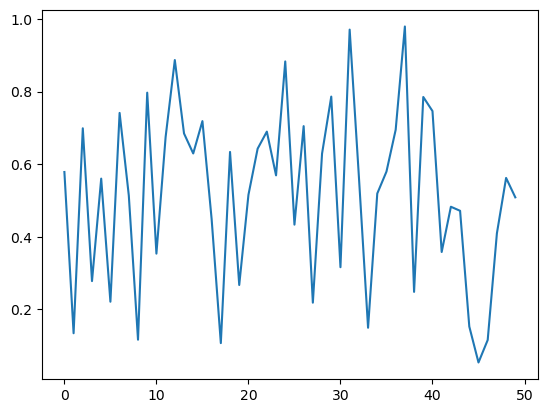

In [ ]:
plt.plot(np.arange(50), rng.uniform(0,1,50))

In [ ]:
def global_corr_v1(sims, refs, period):
    num_channels = len(sims)
    
    # compute all possible correlation maximizers
    lags = np.unique(np.concatenate([(sim[None,:] - ref[:,None]).flatten() for sim, ref in zip(sims, refs)]) % period)
    # TODO: rewrite global correlation function
    corr = np.zeros(1 + lags.size) # 1 for the case where t is empty
    for sim, ref in zip(sims, refs):
        if ((sim.shape[0] == 0) != (ref.shape[0] == 0)): # exactly one spike train is empty
            continue

        if (sim.shape[0] == 0) and (ref.shape[0] == 0): # both spike trains are empty
            corr[1:] += 1
            continue

        t = (sim[None,:] - ref[:,None]).flatten()
        corr[1:] += kernel(mod(lags[None,:] - t[:,None], period, -period/2)).sum(axis=0) / max(sim.shape[0], ref.shape[0])
    
    argmax = np.argmax(corr)
    if argmax == 0:
        return np.array(0.0), np.array(0.0)

    return corr[argmax] / num_channels, mod(lags[argmax-1], period, -period/2)

In [ ]:
def global_corr_v2(sims, refs, period):
    Z = np.maximum([ref.size for ref in refs], [sim.size for sim in sims])
    Zmax = np.max(Z)
    
    refs_arr = np.stack([np.pad(ref, (0, Zmax - ref.size),  'constant', constant_values=np.nan) for ref in refs])
    sims_arr = np.stack([np.pad(sim, (0, Zmax - sim.size),  'constant', constant_values=np.nan) for sim in sims])
    
    lags = np.concatenate([(sim[None,:] - ref[:,None]).flatten() for ref, sim in zip(refs, sims)])
    corr = np.mean(np.nansum(kernel(mod(lags[:,None,None] - (sims_arr - refs_arr)[None,:,:], period, -period/2)), axis=-1) / Z, axis=-1)
    
    argmax = np.argmax(corr)
    return corr[argmax], mod(lags[argmax], period, -period/2)

In [ ]:
global_corr_v1(sims, refs, period)

NameError: name 'kernel' is not defined

In [ ]:
global_corr_v2(sims, refs, period)

NameError: name 'kernel' is not defined

In [ ]:
global_correlation(refs, sims, period)

(0.9111111111111113, 1.0999999999999996)

In [ ]:
sim = np.concatenate([sim1, sim2 + period])

In [ ]:
ref = np.concatenate([ref1, ref2 + period])

In [ ]:
Z = np.maximum([ref.size for ref in refs], [sim.size for sim in sims])


array([3, 3, 4])

In [ ]:
eps = 1
kernel = lambda x_: (np.abs(x_) < eps) * (eps - np.abs(x_)) / eps


In [ ]:
kernel((sim - ref)[:,None] - lags[None,:])

array([[-0. , -0. , -0. , -0. ,  0. , -0. , -0. , -0. ,  0. , -0. , -0. ,
        -0. ,  0.1],
       [ 0. , -0. , -0. , -0. , -0. , -0. , -0. ,  0.3, -0. , -0. , -0. ,
        -0. , -0. ],
       [ 0. , -0. , -0. , -0. , -0. , -0. , -0. ,  0.3, -0. , -0. , -0. ,
        -0. , -0. ],
       [-0. , -0. , -0. , -0. , -0. , -0. , -0. , -0. , -0. ,  0.4, -0. ,
        -0. , -0. ],
       [ 0.1, -0. , -0. , -0. , -0. , -0. , -0. ,  0.4, -0. , -0. , -0. ,
        -0. , -0. ]])